In [ ]:
# import torch
# print("PyTorch 版本:", torch.__version__)
# print("CUDA 是否可用:", torch.cuda.is_available())
# print("PyTorch 编译的 CUDA 版本:", torch.version.cuda)
# print("显卡型号:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "无")

PyTorch 版本: 2.5.1+cu121
CUDA 是否可用: True
PyTorch 编译的 CUDA 版本: 12.1
显卡型号: NVIDIA GeForce RTX 2070 Super with Max-Q Design


In [ ]:
import os
import sys
import shutil
import torch

# --- 本地运行配置 (Local Setup) ---

# 1. 设置你的本地数据路径 (假设你把数据放在了当前目录下的 data 文件夹)
data_dir = './data'  

# 2. 设置模型保存路径
save_dir = './output'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

print(f"正在本地运行 (Local Environment)")
print(f"数据读取路径: {os.path.abspath(data_dir)}")
print(f"模型保存路径: {os.path.abspath(save_dir)}")

# 3. 检查数据是否存在
if not os.path.exists(data_dir) or not os.listdir(data_dir):
    print("❌ 错误：在指定路径下未找到数据文件，请检查 data_dir 路径！")
else:
    print(f"✅ 数据集检查通过，包含文件数: {len(os.listdir(data_dir))}")

# 4. 检查 GPU (如果有显卡)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

正在本地运行 (Local Environment)
数据读取路径: d:\PolyU\Subject\DSAI5102 Principal of DS\Mid_project\data
模型保存路径: d:\PolyU\Subject\DSAI5102 Principal of DS\Mid_project\output
✅ 数据集检查通过，包含文件数: 100
使用设备: cuda


## **Part 1: Setup - Definitions & Utilities**

### **Data Dictionaries and Constants for CWRU Bearing Dataset**

This code defines variables that help organize the CWRU Bearing Dataset, which contains vibration data from bearings with different faults, loads, and sampling rates.

**Key Variables:**

- *cwru_Normal, cwru_DE, cwru_FE*: These store file numbers for normal, Drive End, and Fan End bearing data, respectively. They are organized by fault type, size, and location.
- *sampling_rates*: Maps shorthand sampling rates ('12k', '48k') to actual values in Hz.
- *fault_types, fault_sizes, fault_zones, loads*: Lists of the different fault types, sizes, locations, and loads in the dataset.

These variables make it easier to access specific data files from the CWRU dataset for analysis.


In [3]:
# File numbers corresponding to normal baseline data
cwru_Normal = {
    '48k': ['97', '98', '99', '100']
    }

# CWRU data dictionary (filename numbers) for Drive End (DE) accelerometer data, organized by:
#   Sampling rate ('12k' or '48k')
#       -> Fault Type ('IR', 'B', 'OR')
#           -> Fault Size ('007', '014', '021', '028')
#               -> Fault Zone ('@6', '@3', '@12' - for OR only)
cwru_DE = {
    '12k': {
        'IR': { # Inner Race fault
            '007': ['105', '106', '107', '108'], # Fault size 0.007"
            '014': ['169', '170', '171', '172'], # Fault size 0.014"
            '021': ['209', '210', '211', '212'], # Fault size 0.021"
#           '028': ['3001', '3002', '3003', '3004'] # Fault size 0.028"
        },
        'B': {  # Ball fault
            '007': ['118', '119', '120', '121'],
            '014': ['185', '186', '187', '188'],
            '021': ['222', '223', '224', '225'],
#           '028': ['3005', '3006', '3007', '3008']
        },
        'OR': { # Outer Race fault - take only Fault zone 6 o'clock
            '007': ['130', '131', '132', '133'],
            '014': ['197', '198', '199', '200'],
            '021': ['234', '235', '236', '237']
        }
    },
    '48k': { # Same structure as '12k' but for 48k sampling rate
        'IR': {
            '007': ['109', '110', '111', '112'],
            '014': ['174', '175', '176', '177'],
            '021': ['213', '214', '215', '217']
        },
        'B': {
            '007': ['122', '123', '124', '125'],
            '014': ['189', '190', '191', '192'],
            '021': ['226', '227', '228', '229']
        },
        'OR': { # Outer Race fault - take only Fault zone 6 o'clock
            '007': ['135', '136', '137', '138'],
            '014': ['201', '202', '203', '204'],
            '021': ['238', '239', '240', '241']
        }
    }
}

# CWRU data dictionary (filename numbers) for Fan End (FE) accelerometer data, organized by:
#   Fault Type ('IR', 'B', 'OR')
#       -> Fault Size ('007', '014', '021', '028')
#            -> Fault Zone ('@6', '@3', '@12' - for OR only)
cwru_FE = {
    '12k': {
        'IR': {
            '007': ['278', '279', '280', '281'],
            '014': ['274', '275', '276', '277'],
            '021': ['270', '271', '272', '273']
        },
        'B': {
            '007': ['282', '283', '284', '285'],
            '014': ['286', '287', '288', '289'],
            '021': ['290', '291', '292', '293']
        },
        'OR': { # Outer Race fault - take only Fault zone 3 o'clock; 021 0HP is from @ 6 o'clock
            '007': ['298', '299', '300', '301'],
            '014': ['309', '310', '311', '312'],
            '021': ['315', '316', '317', '318']
        }
    }
}

# Dictionary mapping the shorthand sampling rate labels to their actual values in Hz
sampling_rates = {'12k': 12000, '48k': 48000}

### **Libraries and Functions**

**Imports Libraries:**

Imports necessary Python libraries for specific task.

**Defines Functions:**

Creates functions for all related task.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, accuracy_score,
    confusion_matrix, mean_absolute_percentage_error, classification_report
)
from sklearn.model_selection import StratifiedShuffleSplit
import scipy.io
from scipy.signal import resample_poly
import librosa
import time
import random
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

# ---------------------------- Data Loading and Preprocessing ----------------------------

# Function to load data from CWRU dataset and group by fault type, size, and zone (if applicable)
def load_cwru_signals(data_root, label_dicts, normal_dict, sampling_rate='12k', sensor_location='DE',
                      balance=True, min_seg_len=1024, segment_len=1024, hop_len=368, target_sr=12000, printout=False):
    """
    Loads data from the CWRU dataset and balances the categories.

    Args:
        data_root (str): Path to the CWRU dataset.
        label_dicts (dict): Dictionary containing fault data file numbers (cwru_DE, cwru_FE).
        normal_dict (dict): Dictionary containing normal data file numbers.
        sampling_rate (str, optional): Sampling rate ('12k' or '48k'). Defaults to '12k'.
        sensor_location (str, optional): Sensor location ('DE' or 'FE'). Defaults to 'DE'.
        balance (bool, optional): Whether to balance the dataset. Defaults to True.

    Returns:
        tuple: A tuple containing the data (X) and labels (y).
    """

    X_dict = {}  # Store data by fault type and size
    y_dict = {}

    # Function to segment a signal, ensuring all segments have segment_len
    def segment_signal(signal_data, segment_len, hop_len, min_segments=None):
        num_segments = (len(signal_data) - segment_len) // hop_len + 1

        # If min_segments is specified and there are fewer segments, adjust overlap
        if min_segments is not None and num_segments < min_segments:
            # Calculate required overlap percentage
            overlap_percentage = 1 - (num_segments / min_segments)

            # Adjust hop_len to achieve desired overlap
            adjusted_hop_len = int(hop_len * (1 - overlap_percentage))

            # Extract segments with adjusted overlap
            segments = [signal_data[i * adjusted_hop_len : i * adjusted_hop_len + segment_len]
                        for i in range((len(signal_data) - segment_len) // adjusted_hop_len + 1)
                        if i * adjusted_hop_len + segment_len <= len(signal_data)]

            # If the number of segments is still less than min_segments after overlap,
            # duplicate a subset of existing segments to make it exactly min_segments.
            if len(segments) < min_segments:
                num_to_duplicate = min_segments - len(segments)
                duplicated_segments = random.choices(segments, k=num_to_duplicate)
                segments.extend(duplicated_segments)

        else:
            # If min_segments not specified or enough segments, use all valid segments
            segments = [signal_data[i * hop_len : i * hop_len + segment_len]
                        for i in range(num_segments)
                        if i * hop_len + segment_len <= len(signal_data)]

        return segments[:min_segments]  # Ensure exactly min_segments are returned

    # Load normal baseline data
    for sr, file_ids in normal_dict.items():
        for file_id in file_ids:
            mat_path = os.path.join(data_root, f"{file_id}.mat")
            if os.path.exists(mat_path):
                signal = scipy.io.loadmat(mat_path)
                signal_data_key = find_signal_data_key(signal, file_id)
                signal_data = signal[signal_data_key].flatten()  # Flatten the signal data

                # Resample
                signal_data = librosa.resample(signal_data, orig_sr=int(sr.replace('k', '000')), target_sr=target_sr)

                # Segment the signal
                if balance:
                    min_segments_per_category = min_seg_len  # Use min_seg_len for balancing
                    segments = segment_signal(signal_data, segment_len, hop_len, min_segments=min_segments_per_category)
                else:
                    segments = segment_signal(signal_data, segment_len, hop_len)  # No segment limit

                label = [fault_check_map['Normal'], fault_type_map['Normal'], fault_size_cls_map['000']] # Add 3 group
                label_tuple = tuple(label)
                X_dict.setdefault(label_tuple, []).extend(segments)
                y_dict.setdefault(label_tuple, []).extend([label] * len(segments))

                if printout:
                  print(f"Fault Type: Normal, Fault Size: 0, File ID: {file_id}")

            if printout:
                print(f"Total data points so far: {sum(len(v) for v in X_dict.values())}")

    # Loop through DE and FE for other faults (Drive End and Fan End data)
    for fault_data in [label_dicts[sampling_rate]]:
        for fault_type, sizes in fault_data.items():
            if isinstance(sizes, dict):
                for fault_size, file_ids in sizes.items():
                    for file_id in file_ids:
                        mat_path = os.path.join(data_root, f"{file_id}.mat")
                        if os.path.exists(mat_path):
                            signal = scipy.io.loadmat(mat_path)
                            signal_data_key = find_signal_data_key(signal, file_id)
                            signal_data = signal[signal_data_key].flatten()

                            # Resample
                            # signal_data = librosa.resample(signal_data, orig_sr=int(sampling_rate.replace('k', '000')), target_sr=target_sr)

                            # Segment the signal
                            # ... [Inside the for loops, when calling segment_signal() for each fault category] ...
                            if balance:
                                min_segments_per_category = min_seg_len  # Use min_seg_len for balancing
                                segments = segment_signal(signal_data, segment_len, hop_len, min_segments=min_segments_per_category)
                            else:
                                segments = segment_signal(signal_data, segment_len, hop_len)  # No segment limit

                            fault_size_label = fault_size_cls_map.get(fault_size, fault_size_cls_map['000'])

                            if printout:
                                print(f"Fault Type: {fault_type}, Fault Size: {fault_size_label}, File ID: {file_id}")

                            label = [fault_check_map['Faulty'], fault_type_map[fault_type], fault_size_label]
                            label_tuple = tuple(label)
                            X_dict.setdefault(label_tuple, []).extend(segments)
                            y_dict.setdefault(label_tuple, []).extend([label] * len(segments))

                        # Print total number of data points after processing each file
                        if printout:
                            print(f"Total data points so far: {sum(len(v) for v in X_dict.values())}")

            elif isinstance(sizes, list):
                for file_id in sizes:
                    mat_path = os.path.join(data_root, f"{file_id}.mat")
                    if os.path.exists(mat_path):
                        signal = scipy.io.loadmat(mat_path)
                        signal_data_key = find_signal_data_key(signal, file_id)
                        signal_data = signal[signal_data_key].flatten()

                        # Resample
                        # signal_data = librosa.resample(signal_data, orig_sr=int(sampling_rate.replace('k', '000')), target_sr=target_sr)

                        # Segment the signal
                        if balance:
                            min_segments_per_category = min_seg_len  # Use min_seg_len for balancing
                            segments = segment_signal(signal_data, segment_len, hop_len, min_segments=min_segments_per_category)
                        else:
                            segments = segment_signal(signal_data, segment_len, hop_len)  # No segment limit

                        fault_size = next((size for size in fault_size_cls_map if size in file_id), '000')
                        fault_size_label = fault_size_cls_map.get(fault_size, fault_size_cls_map['000'])

                        if printout:
                            print(f"Fault Type: {fault_type}, Fault Size: {fault_size_label}, File ID: {file_id}")

                        label = [fault_check_map['Faulty'], fault_type_map[fault_type], fault_size_label]
                        label_tuple = tuple(label)
                        X_dict.setdefault(label_tuple, []).extend(segments)
                        y_dict.setdefault(label_tuple, []).extend([label] * len(segments))

                    # Print total number of data points after processing each file
                    if printout:
                        print(f"Total data points so far: {sum(len(v) for v in X_dict.values())}")

    # Balancing the Data (if balance=True)
    if balance:
        # Ensure all categories have min_seg_len samples:
        min_count = min(len(v) for v in X_dict.values())

        if min_count < min_seg_len:
            print(f"Warning: Some categories have fewer than {min_seg_len} samples. Balancing might be affected.")

        X_balanced = []
        y_balanced = []
        for label in X_dict:
            # If a category has more than min_seg_len samples, randomly select min_seg_len
            if len(X_dict[label]) > min_seg_len:
                selected_samples = random.sample(X_dict[label], min_seg_len)
                X_balanced.extend(selected_samples)
                y_balanced.extend([label] * min_seg_len)
            # If a category has less or equal min_seg_len samples, use all samples.
            # Note: This is necessary to use all data if any class contains less data than min_seg_len
            else:
                X_balanced.extend(X_dict[label])
                y_balanced.extend([label] * len(X_dict[label]))

        X_padded = [np.pad(x, (0, segment_len - len(x)), 'constant') if len(x) < segment_len else x for x in X_balanced]

        return np.array(X_padded), np.array(y_balanced)

    else: # If balance=False, return the original (unbalanced) data
        X_all = []
        y_all = []
        for label, segments in X_dict.items():
            X_all.extend(segments)
            y_all.extend([label] * len(segments))

        # Pad segments to segment_len if necessary
        X_padded = [np.pad(x, (0, segment_len - len(x)), 'constant') if len(x) < segment_len else x for x in X_all]

        return np.array(X_padded), np.array(y_all)

def find_signal_data_key(signal_dict, file_id, sensor_location='DE'):
    """
    Finds the key for signal data in a dictionary,
    prioritizing '_<sensor_location>_time' and falling back to '_time'.

    Args:
        signal_dict (dict): The dictionary containing signal data (from scipy.io.loadmat).
        file_id (str): The file ID to search for in the key.
        sensor_location (str): The sensor location ('DE' or 'FE'). Defaults to 'DE'.

    Returns:
        str: The key for the signal data.

    Raises:
        KeyError: If no matching key is found.
    """

    # Find keys ending with '_<sensor_location>_time' and containing file_id
    matching_keys_id_time = [
        key for key in signal_dict.keys()
        if key.endswith(f"_{sensor_location}_time") and file_id in key
    ]

    if matching_keys_id_time:
        return matching_keys_id_time[0]
    else:  # If no '_<sensor_location>_time' key is found, look for '_time'
        matching_keys_time = [
            key for key in signal_dict.keys()
            if key.endswith(f"_{sensor_location}_time")
        ]
        if matching_keys_time:
            return matching_keys_time[0]
        else:
            display(signal_dict.keys())
            raise KeyError(f"No key ending with '_{sensor_location}_time' or '_time' and containing '{file_id}' found in the .mat file.")

def filter_cwru_data(cwru_data, selected_hps, sampling_rate='12k', fault_types=None):
    """
    Filters the CWRU dataset based on selected HP values, sampling rate, and fault types.

    Parameters:
    - cwru_data (dict): The original CWRU data dictionary (either for DE or FE).
    - selected_hps (list): List of HP values to keep (e.g., [0, 1, 2]).
    - sampling_rate (str): Sampling rate to filter the data by (default '12k').
    - fault_types (list): List of fault types to filter (default None includes all fault types).

    Returns:
    - dict: Filtered CWRU dataset with selected HP values, sampling rate, and fault types.
    """
    # Initialize filtered data
    filtered_data = {sampling_rate: {}}

    # If no fault types are provided, include all fault types
    fault_types = fault_types or list(cwru_data[sampling_rate].keys())

    # Iterate over fault types, fault sizes, and the corresponding files in the data
    for fault_type in fault_types:
        if fault_type in cwru_data[sampling_rate]:
            filtered_data[sampling_rate][fault_type] = {
                fault_size: [
                    file_list[hp]  # Access the file by HP index
                    for hp in selected_hps if hp < len(file_list)
                ]
                for fault_size, file_list in cwru_data[sampling_rate][fault_type].items()
            }

    return filtered_data

def stratified_split(X, y, test_size=0.2, val_size=0.1, random_state=42):
    """
    Splits the data into train, validation, and test sets while stratifying based on fault type and size.

    Args:
        X (np.ndarray): Feature data (e.g., vibration signal segments).
        y (np.ndarray): Label data (fault type and size).
        test_size (float, optional): Proportion of the dataset to include in the test split. Defaults to 0.2.
        val_size (float, optional): Proportion of the dataset to include in the validation split. Defaults to 0.1.
        random_state (int, optional): Seed for random number generation. Defaults to 42.

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size + val_size, random_state=random_state)
    
    # Split into train and temp (val + test)
    for train_index, temp_index in sss.split(X, [tuple(label) for label in y]):
        X_train, X_temp = X[train_index], X[temp_index]
        y_train, y_temp = y[train_index], y[temp_index]

    # Now split temp into validation and test
    sss_val = StratifiedShuffleSplit(n_splits=1, test_size=test_size / (test_size + val_size), random_state=random_state)
    for val_index, test_index in sss_val.split(X_temp, [tuple(label) for label in y_temp]):
        X_val, X_test = X_temp[val_index], X_temp[test_index]
        y_val, y_test = y_temp[val_index], y_temp[test_index]

    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                                             torch.tensor(y_train, dtype=torch.long)),
                                               batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                                                           torch.tensor(y_val, dtype=torch.long)),
                                             batch_size=32, shuffle=False)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                                                            torch.tensor(y_test, dtype=torch.long)),
                                              batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader
    
# Plot first and last segments of groups
def plot_segments(X_padded, y, unique_fault_types, fault_type_sizes, fault_type_map, fault_size_cls_map):
    """
    Plots the first and last segments for each combination of fault type and size.

    Parameters:
    - X_padded: np.ndarray, the segmented vibration data (num_samples, segment_length)
    - y: np.ndarray, labels array where column 1 is fault type and column 2 is fault size
    - unique_fault_types: list of unique fault type values (from y[:, 1])
    - fault_type_sizes: dict mapping each fault type to its associated list of fault sizes
    - fault_type_map: dict mapping fault type labels (str) to numeric codes
    - fault_size_cls_map: dict mapping fault size labels (str) to numeric codes
    """

    # Identify valid subplot positions (only those with available data)
    subplots_to_use = []
    for i, fault_type in enumerate(unique_fault_types):
        for j, fault_size in enumerate(fault_type_sizes[fault_type]):
            indices = np.where((y[:, 1] == fault_type) & (y[:, 2] == fault_size))[0]
            if len(indices) > 0:
                subplots_to_use.append((i, j))

    # Determine subplot grid dimensions
    num_rows = len(unique_fault_types)
    num_cols = max(len(fault_type_sizes[fault_type]) for fault_type in unique_fault_types)

    # Create the figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), squeeze=False)
    fig.suptitle("First and Last Segments for Each Fault Type and Size", fontsize=16)

    # Plot segments for each valid subplot
    for i, j in subplots_to_use:
        fault_type = unique_fault_types[i]
        fault_size = fault_type_sizes[fault_type][j]
        indices = np.where((y[:, 1] == fault_type) & (y[:, 2] == fault_size))[0]
        if len(indices) == 0:
            continue

        first_segment_index = indices[1]
        last_segment_index = indices[-1]

        ax = axes[i, j]
        ax.plot(X_padded[first_segment_index], label="First Segment")
        ax.plot(X_padded[last_segment_index], label="Last Segment")

        # Convert numeric fault codes back to labels
        fault_type_label = next(k for k, v in fault_type_map.items() if v == fault_type)
        fault_size_label = next(k for k, v in fault_size_cls_map.items() if v == fault_size)

        ax.set_title(f"Type: {fault_type_label}, Size: {fault_size_label}")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Amplitude")
        ax.legend()

    # Remove unused subplots
    for i in range(num_rows):
        for j in range(num_cols):
            if (i, j) not in subplots_to_use:
                fig.delaxes(axes[i, j])

    # Final layout adjustment and display
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ---------------------------- Counts for each category ----------------------------
def category_counts_for_set(X, y, fault_check_map, fault_type_map, fault_size_cls_map):
  """
  Calculates and displays category counts for a given dataset (train, val, or test).

  Args:
      X (array-like): Input features.
      y (array-like): Target variables (fault type and size).
      fault_type_map (dict): Mapping of fault type codes to labels.
      fault_size_cls_map (dict): Mapping of fault size codes to labels.

  Returns:
      Pandas DataFrame: Category counts with labels.
  """
  df = pd.DataFrame(y[:, :3], columns=['fault_check', 'fault_type', 'fault_size'])
  category_counts = df.groupby(['fault_check', 'fault_type', 'fault_size']).size().reset_index(name='count')
  category_counts['fault_check_label'] = category_counts['fault_check'].map(
      {v: k for k, v in fault_check_map.items()}
  )
  category_counts['fault_type_label'] = category_counts['fault_type'].map(
      {v: k for k, v in fault_type_map.items()}
  )
  category_counts['fault_size_label'] = category_counts['fault_size'].map(
      {v: k for k, v in fault_size_cls_map.items()}
  )
  return category_counts[['fault_check_label', 'fault_type_label', 'fault_size_label', 'count']]

def plot_training_results(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(15, 5))

    # Plot for loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()

    # Plot for classification accuracy (Fault Type Accuracy)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_type_acc'], label='Type Acc')
    plt.plot(epochs, history['val_size_acc'], label='Size Acc')
    plt.title("Classification Accuracy (Fault Type)")
    plt.legend()

    # Plot for regression R² (Fault Size)
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_size_mse'], label='Size MSE')
    plt.title("Regression MSE (Fault Size)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# ==============================================================================
# 🧠 PYTORCH DEEP LEARNING FUNCTIONS
# ==============================================================================
def reshape_input_pt(X, model_name):
    model_type_map = {
        'mlp': ['MLP_pt'],
        'cnn': [
            'CNN1D_pt', 'ResNet1D_pt', 'DenseNet1D_pt', 'TinyVGG1D_pt',
            'Xception1D_pt', 'Inception1D_pt', 'MobileNet1D_pt',
            'EfficientNet1D_pt', 'DeepCNN1D_pt', 'MEAT_pt', 'DenseResNet1D_pt'
        ],
        'rnn': ['LSTM1D_pt', 'GRU1D_pt', 'BiLSTM1D_pt', 'Transformer1D_pt']
    }

    X = torch.tensor(X, dtype=torch.float32)

    if model_name in model_type_map['cnn']:
        if X.ndim == 2:
            return X.unsqueeze(1)  # [N, 1, L]
        elif X.ndim == 3:
            return X  # Already [N, 1, L]
        else:
            raise ValueError(f"Unexpected input shape for CNN: {X.shape}")

    elif model_name in model_type_map['rnn']:
        if X.ndim == 2:
            return X.unsqueeze(-1)  # [N, L, 1]
        elif X.ndim == 3:
            return X  # Already [N, L, 1]
        else:
            raise ValueError(f"Unexpected input shape for RNN: {X.shape}")

    elif model_name in model_type_map['mlp']:
        return X  # [N, L]

    else:
        raise ValueError(f"Unknown model_name: {model_name}")

def create_dataloader_pt(X, y, batch_size, model_name, num_workers=4, pin_memory=True):
    X_reshaped = reshape_input_pt(X, model_name)

    # Convert y to tensor
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # If y has multiple outputs (e.g., [fault_type, fault_size, etc.]), handle each
    y1 = y_tensor[:, 0]  # e.g., fault_check (already integer)
    y2 = y_tensor[:, 1]  # e.g., fault_type (classification)
    y3 = y_tensor[:, 2]  # e.g., fault_size (classification)
    y4 = y_tensor[:, 3]  # regression version of fault size (keep for other loss)

    dataset = TensorDataset(X_reshaped, y1.long(), y2.long(), y3.long(), y4)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

    return dataloader

def generate_dataloaders_pt(model_name, X_train, y_train, X_val, y_val, X_test, y_test, batch_size):
    train_loader = create_dataloader_pt(X_train, y_train, batch_size=batch_size, model_name=model_name)
    val_loader = create_dataloader_pt(X_val, y_val, batch_size=batch_size, model_name=model_name)
    test_loader = create_dataloader_pt(X_test, y_test, batch_size=batch_size, model_name=model_name)

    return train_loader, val_loader, test_loader

def train_evaluate_model_pt(model, train_loader, val_loader, test_loader, epochs, learning_rate, device):
    criterion_check = nn.BCEWithLogitsLoss()
    criterion_type = nn.CrossEntropyLoss()
    criterion_size_cls = nn.CrossEntropyLoss()
    criterion_size_reg = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Scheduler ReduceLROnPlateau with a Universal Loop
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',             # 'min' for loss
        factor=0.5,             # Reduce LR by half
        patience=3,             # Wait 3 epochs of no improvement
        verbose=True
    )

    train_losses, val_losses = [], []
    val_type_accs, val_size_accs = [], []
    val_size_mses, val_size_maes, val_size_r2s, val_size_mapes  = [], [], [], []
    time_elapses = []

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        total_loss = 0
        train_check_preds, train_check_targets = [], []
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        for batch_idx, batch in progress_bar:
            inputs, y_check, y_type, y_size_cls, y_size_reg = batch
            inputs = inputs.to(device).float()
            y_check = y_check.to(device).float()
            y_type = y_type.to(device).long()
            y_size_cls = y_size_cls.to(device).long()
            y_size_reg = y_size_reg.to(device).float()

            optimizer.zero_grad()
            out_check, out_type, out_size_cls, out_size_reg = model(inputs)
            if out_type.ndim == 3:
                out_type = out_type.squeeze(1)

            loss_type = criterion_type(out_type, y_type)
            
            loss_size_cls = criterion_size_cls(out_size_cls, y_size_cls)
            loss_size_reg = criterion_size_reg(out_size_reg.squeeze(), y_size_reg)

            loss = loss_type + loss_size_cls + loss_size_reg  # remove loss_check
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Live metrics during training
            pred_check = torch.round(torch.sigmoid(out_check.squeeze())).int()
            train_check_preds.extend(pred_check.cpu().numpy())                   
            train_check_targets.extend(y_check.int().cpu().numpy())              
            pred_type = torch.argmax(out_type, dim=1)              
            pred_size_cls = torch.argmax(out_size_cls, dim=1)
            pred_size_reg = out_size_reg.squeeze()

            avg_batch_loss = total_loss / (batch_idx + 1)
            progress_bar.set_postfix({
                'Batch Loss': f"{avg_batch_loss:.4f}",
                'TypeAcc': f"{(pred_type == y_type).float().mean().item():.3f}",
                'SizeAcc': f"{(pred_size_cls == y_size_cls).float().mean().item():.3f}",
                'SizeMSE': f"{mean_squared_error(y_size_reg.detach().cpu().numpy(), pred_size_reg.detach().cpu().numpy()):.3f}"
            })

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        val_type_preds, val_type_targets = [], []
        val_size_cls_preds, val_size_cls_targets = [], []
        val_size_reg_preds, val_size_reg_targets = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                inputs, y_check, y_type, y_size_cls, y_size_reg = batch
                inputs = inputs.to(device).float()
                y_check = y_check.to(device).float()
                y_type = y_type.to(device).long()
                y_size_cls = y_size_cls.to(device).long()
                y_size_reg = y_size_reg.to(device).float()

                out_check, out_type, out_size_cls, out_size_reg = model(inputs)
                if out_type.ndim == 3:
                    out_type = out_type.squeeze(1)

                # Reshape the model output
                out_size_cls = out_size_cls.squeeze(1)  # Remove the extra dimension

                loss_check = criterion_check(out_check.squeeze(), y_check)
                loss_type = criterion_type(out_type, y_type)
                loss_size_cls = criterion_size_cls(out_size_cls, y_size_cls)
                loss_size_reg = criterion_size_reg(out_size_reg.squeeze(), y_size_reg)

                loss = loss_type + loss_size_cls + loss_size_reg  # remove loss_check
                val_loss += loss.item()

                pred_type = torch.argmax(out_type, dim=1).cpu().numpy()
                pred_size_cls = torch.argmax(out_size_cls, dim=1).cpu().numpy()
                pred_size_reg = out_size_reg.squeeze().cpu().numpy()

                val_type_targets.extend(y_type.cpu().numpy())
                val_size_cls_targets.extend(y_size_cls.cpu().numpy())
                val_size_reg_targets.extend(y_size_reg.cpu().numpy())

                val_type_preds.extend(pred_type)
                val_size_cls_preds.extend(pred_size_cls)
                val_size_reg_preds.extend(pred_size_reg)

        val_type_acc = accuracy_score(val_type_targets, val_type_preds)
        val_size_acc = accuracy_score(val_size_cls_targets, val_size_cls_preds)
        val_size_mse = mean_squared_error(val_size_reg_targets, val_size_reg_preds)
        val_size_mae = mean_absolute_error(val_size_reg_targets, val_size_reg_preds)
        val_size_r2 = r2_score(val_size_reg_targets, val_size_reg_preds)
        val_size_mape = mean_absolute_percentage_error(val_size_reg_targets, val_size_reg_preds)

        val_type_accs.append(val_type_acc)
        val_size_accs.append(val_size_acc)
        val_size_mses.append(val_size_mse)
        val_size_maes.append(val_size_mae)
        val_size_r2s.append(val_size_r2)
        val_size_mapes.append(val_size_mape)

        # 🕒 Time elapsed for this epoch
        epoch_elapsed_time = time.time() - epoch_start_time
        time_elapses.append(epoch_elapsed_time)
    
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        scheduler.step(val_loss)  # 🔁 This is key
        
        print(f"\n✅ Epoch {epoch+1}/{epochs} Completed:")
        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"Validation - Type Acc: {val_type_acc:.4f}, Size: {val_type_acc:.4f}, MSE - Size: {val_size_mse:.4f}")

    train_time = time.time() - start_time

    # --- TESTING ---
    # Evaluate on test set
    model.eval()

    print("📊 Evaluating on test set...")

    # Initialize lists for ground truth and predictions
    y_check_true, y_check_pred = [], []  # For fault_check (binary)
    y_type_true, y_type_pred = [], []  # For fault_type (classification)
    y_size_cls_true, y_size_cls_pred = [], []  # For fault_size (classification)
    y_size_reg_true, y_size_reg_pred = [], []  # For fault_size (regression)

    with torch.no_grad():
        for batch in test_loader:
            inputs, y_check, y_type, y_size_cls, y_size_reg = batch
            inputs = inputs.to(device).float()
            y_check = y_check.to(device).float()
            y_type = y_type.to(device).long()
            y_size_cls = y_size_cls.to(device).long()
            y_size_reg = y_size_reg.to(device).float()

            out_check, out_type, out_size_cls, out_size_reg = model(inputs)
            if out_type.ndim == 3:
                out_type = out_type.squeeze(1)
                
            pred_check = (torch.sigmoid(out_check.squeeze()) > 0.5).int()
            pred_type = torch.argmax(out_type, dim=1)
            pred_size_cls = torch.argmax(out_size_cls, dim=1)
            pred_size_reg = out_size_reg.squeeze()

            y_check_true.extend(y_check.int().cpu().numpy())
            y_check_pred.extend(pred_check.cpu().numpy())
            y_type_true.extend(y_type.cpu().numpy())
            y_type_pred.extend(pred_type.cpu().numpy())
            y_size_cls_true.extend(y_size_cls.cpu().numpy())
            y_size_cls_pred.extend(pred_size_cls.cpu().numpy())
            y_size_reg_true.extend(y_size_reg.cpu().numpy())
            y_size_reg_pred.extend(pred_size_reg.cpu().numpy())

    acc_check = accuracy_score(y_check_true, y_check_pred)
    acc_type = accuracy_score(y_type_true, y_type_pred)
    acc_size = accuracy_score(y_size_cls_true, y_size_cls_pred)
    mse_size = mean_squared_error(y_size_reg_true, y_size_reg_pred)
    mae_size = mean_absolute_error(y_size_reg_true, y_size_reg_pred)
    r2_size = r2_score(y_size_reg_true, y_size_reg_pred)
    mape_size = mean_absolute_percentage_error(y_size_reg_true, y_size_reg_pred)

    # --- Confusion Matrix (for Type Classification) ---
    conf_matrix = confusion_matrix(y_type_true, y_type_pred)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Fault Type')
    plt.colorbar()
    tick_marks = np.arange(len(conf_matrix))
    plt.xticks(tick_marks, fault_type_map)
    plt.yticks(tick_marks, fault_type_map)

    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # --- Confusion Matrix (for Size Classification) ---
    conf_matrix = confusion_matrix(y_size_cls_true, y_size_cls_pred)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion Matrix - Fault Size')
    plt.colorbar()

    # Make sure the number of classes in the confusion matrix matches the fault size map
    tick_marks = np.arange(len(fault_size_cls_map))  # This should be 4 for the 4 fault sizes
    plt.xticks(tick_marks, list(fault_size_cls_map.keys()))  # Use the keys from the map for labels
    plt.yticks(tick_marks, list(fault_size_cls_map.keys()))  # Same for y-axis ticks

    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Ensure inputs are numpy arrays
    y_size_reg_pred = np.array(y_size_reg_pred)
    y_size_reg_true = np.array(y_size_reg_true)
    
    # Inverse transform using the scaler
    y_size_reg_pred_orig = scaler_y.inverse_transform(y_size_reg_pred.reshape(-1, 1)).flatten()
    y_size_reg_true_orig = scaler_y.inverse_transform(y_size_reg_true.reshape(-1, 1)).flatten()

    # 📊 Scatter Plot of Predicted vs. True Fault Size (Original Scale)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_size_reg_true_orig, y_size_reg_pred_orig, alpha=0.5)
    plt.plot(
        [min(y_size_reg_true_orig), max(y_size_reg_true_orig)],
        [min(y_size_reg_true_orig), max(y_size_reg_true_orig)],
        'r--', label='Ideal'
    )
    plt.title('Predicted vs. True Fault Size (in mm)')
    plt.xlabel('True Fault Size (mm)')
    plt.ylabel('Predicted Fault Size (mm)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print Metrics
    print("\n📈 Classification Metrics:")
    print(f"  ➤ Fault Check Accuracy: {acc_check:.4f}")
    print(f"  ➤ Fault Type Accuracy: {acc_type:.4f}")
    print(f"  ➤ Fault Size Accuracy: {acc_size:.4f}")
    
    # --- Regression Metrics ---
    print("\n📊 Regression Metrics for Fault Size:")
    print(f"Mean Squared Error (MSE): {mse_size:.4f}")
    print(f"Mean Absolute Error (MAE): {mae_size:.4f}")
    print(f"R2 Score: {r2_size:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape_size:.4f}")

    # Save full model to a .pt file

    # Dynamically get the class name and save the model
    class_name = model.__class__.__name__
    save_dict = os.path.join(save_dir, "PyTorch/dict_models", f"{class_name}.pth")
    save_full = os.path.join(save_dir, "PyTorch/full_models", f"{class_name}.pt")

    # Save model state_dict
    os.makedirs(os.path.dirname(save_dict), exist_ok=True)
    torch.save(model.state_dict(), save_dict)
    print(f"\n📂 Model saved to {save_dict}")

    os.makedirs(os.path.dirname(save_full), exist_ok=True)
    torch.save(model, save_full)
    print(f"📂 Model saved to {save_full}\n")

    # Save training and validation history to CSV
    history_df = pd.DataFrame({
        'Epoch': list(range(1, epochs + 1)),
        'Train_Loss': train_losses,
        'Val_Loss': val_losses,
        'Val_Acc_Type': val_type_accs,
        'Val_Acc_Size': val_size_accs,
        'Val_R2_Size': val_size_r2s,
        'Time_Elapsed(s)': time_elapses
    })
    train_val_csv = os.path.join(save_dir, "PyTorch/metrics", f"{class_name}_train_val_history.csv")
    os.makedirs(os.path.dirname(train_val_csv), exist_ok=True)
    history_df.to_csv(train_val_csv, index=False)
    print(f"📄 Training/Validation history saved to {train_val_csv}")

    # Save test results to CSV
    test_results_df = pd.DataFrame([{
        'Model': class_name,
        'Train_Time':train_time,
        'Fault_Check_Acc': acc_check,
        'Fault_Type_Acc': acc_type,
        'Fault_Size_Acc': acc_size,
        'Fault_Size_R2': r2_size,
        'Fault_Size_MSE': mse_size,
        'Fault_Size_RMSE': np.sqrt(mse_size),
        'Fault_Size_MAE': mae_size,
        'Fault_Size_MAPE': mape_size
    }])
    test_csv = os.path.join(save_dir, "PyTorch/metrics", f"{class_name}_test_results.csv")
    test_results_df.to_csv(test_csv, index=False)
    print(f"📄 Test results saved to {test_csv}")

    test_metrics = {
        'fault_check_acc': acc_check,
        'fault_type_acc': acc_type,
        'fault_size_acc': acc_size,
        'fault_size_mse': mse_size,
        'fault_size_rmse': np.sqrt(mse_size),
        'fault_size_mae': mae_size,
        'fault_size_r2': r2_size,        
        'fault_size_mape': mape_size
    }

    history_data = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'val_type_acc': val_type_accs,
        'val_size_acc': val_size_accs,
        'val_size_mse': val_size_mses,
        'val_size_mae': val_size_maes,
        'val_size_r2': val_size_r2s,
        'val_size_mape': val_size_mapes,
        'train_time': train_time
    }

    return history_data, test_metrics

# Model Definitions
# ==============================================================================
# 🧠 Model 01: MLP
# ==============================================================================
class MLP_pt(nn.Module):
    def __init__(self, input_dim=1024, num_classes=4):
        super(MLP_pt, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_check = nn.Linear(256, 1)        # Binary classification (e.g., fault/no fault)
        self.fc_type = nn.Linear(256, num_classes)  # Multi-class classification (e.g., fault types)
        self.fc_size_cls = nn.Linear(256, num_classes)  # Fault size classification (now multi-class)
        self.fc_size_reg = nn.Linear(256, 1)  # Additional regression output for another fault size

        # Xavier initialization
        init.xavier_uniform_(self.fc_check.weight)
        init.xavier_uniform_(self.fc_type.weight)
        init.xavier_uniform_(self.fc_size_cls.weight)
        init.xavier_uniform_(self.fc_size_reg.weight)

    def forward(self, x):
        x = self.shared(x)
        out_check = torch.sigmoid(self.fc_check(x))  # Apply sigmoid activation for binary classification
        out_type = self.fc_type(x)
        out_size_cls = self.fc_size_cls(x)           # Classification for fault size
        out_size_reg = F.relu(self.fc_size_reg(x))   # Additional regression output for fault size
        
        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 02: CNN
# ==============================================================================
class CNN1D_pt(nn.Module):
    def __init__(self, input_size=1024, num_classes=4):
        super(CNN1D_pt, self).__init__()

        # Convolutional + Pooling Layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # 1024 → 512

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)  # 512 → 256

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2)  # 256 → 128

        # Reduced size after 3 pools
        reduced_size = input_size // 8  # 1024 → 128

        # Shared Fully Connected Layers
        self.fc1 = nn.Linear(128 * reduced_size, 256)
        self.fc2 = nn.Linear(256, 128)

        # Output Heads
        self.fc_check = nn.Linear(128, 1)               # Binary classification
        self.fc_type = nn.Linear(128, num_classes)      # Fault type
        self.fc_size_cls = nn.Linear(128, num_classes)  # Fault size class
        self.fc_size_reg = nn.Linear(128, 1)            # Fault size regression

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward(self, x):
        # Input: (batch_size, 1, input_size)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        out_check = torch.sigmoid(self.fc_check(x))        # Binary classification
        out_type = self.fc_type(x)                         # Multi-class logits
        out_size_cls = self.fc_size_cls(x)                 # Multi-class logits
        out_size_reg = F.softplus(self.fc_size_reg(x))     # Smooth non-negative output

        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 03: ResNet
# ==============================================================================
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, downsample=False):
        super(ResidualBlock1D, self).__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=1, stride=2 if downsample else 1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=2 if downsample else 1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class ResNet1D_pt(nn.Module):
    def __init__(self, input_size=1024, num_classes=4):
        super(ResNet1D_pt, self).__init__()

        self.layer1 = ResidualBlock1D(1, 32)
        self.layer2 = ResidualBlock1D(32, 64, downsample=True)
        self.layer3 = ResidualBlock1D(64, 128, downsample=True)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 128)

        # Four separate outputs
        self.fc_check = nn.Linear(128, 1)          # Binary classification
        self.fc_type = nn.Linear(128, num_classes) # Fault type classification
        self.fc_size_cls = nn.Linear(128, num_classes) # Fault size classification (multi-class)
        self.fc_size_reg = nn.Linear(128, 1)       # Fault size regression

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.pool(x).squeeze(-1)  # Global Avg Pooling
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))

        out_check = torch.sigmoid(self.fc_check(x))  # Binary classification
        out_type = self.fc_type(x)                   # Multi-class classification
        out_size_cls = self.fc_size_cls(x)           # Fault size as classification
        out_size_reg = torch.clamp(self.fc_size_reg(x), min=0)  # Fault size regression (non-negative)

        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 04: LSTM
# ==============================================================================
class LSTM1D_pt(nn.Module):
    def __init__(self, sequence_length=1024, hidden_size=128, num_layers=2, dropout_rate=0.3, num_classes=4):
        super(LSTM1D_pt, self).__init__()
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=1,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout_rate,
                            bidirectional=False)

        self.bn = nn.BatchNorm1d(hidden_size)

        # Four output heads
        self.fc_check = nn.Linear(hidden_size, 1)        # Binary classification
        self.fc_type = nn.Linear(hidden_size, num_classes)  # Multi-class classification
        self.fc_size_cls = nn.Linear(hidden_size, num_classes)  # Fault size classification
        self.fc_size_reg = nn.Linear(hidden_size, 1)     # Fault size regression (non-negative)

        self._init_weights()

    def _init_weights(self):
        for layer in [self.fc_check, self.fc_type, self.fc_size_cls, self.fc_size_reg]:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        # Input shape handling
        if x.ndim == 2:
            x = x.unsqueeze(-1)  # (B, T) -> (B, T, 1)
        elif x.ndim == 3 and x.shape[1] == 1:
            x = x.permute(0, 2, 1)  # (B, 1, T) -> (B, T, 1)

        x = x[:, :self.sequence_length, :]  # Ensure fixed length

        lstm_out, (h_n, _) = self.lstm(x)
        last_hidden = h_n[-1]  # Shape: (B, hidden_size)

        # Normalize
        last_hidden = self.bn(last_hidden)

        # Output heads
        out_check = torch.sigmoid(self.fc_check(last_hidden))  # Binary classification
        out_type = self.fc_type(last_hidden)                   # Multi-class classification (logits)
        out_size_cls = self.fc_size_cls(last_hidden)           # Fault size classification (logits)
        out_size_reg = F.relu(self.fc_size_reg(last_hidden))   # Fault size regression (non-negative)

        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 05: GRU
# ==============================================================================
class GRU1D_pt(nn.Module):
    def __init__(self, input_size=1, seq_len=1024, hidden_size=128, num_classes=4):
        super(GRU1D_pt, self).__init__()

        self.seq_len = seq_len
        self.hidden_size = hidden_size

        # GRU Layer
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)

        # Fully Connected Layers
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)

        # Output heads
        self.fc_check = nn.Linear(32, 1)        # Binary Classification
        self.fc_type = nn.Linear(32, num_classes)    # Fault Type Classification
        self.fc_size_cls = nn.Linear(32, num_classes) # Fault Size Classification
        self.fc_size_reg = nn.Linear(32, 1)     # Fault Size Regression

        self._init_weights()

    def _init_weights(self):
        for layer in [self.fc_check, self.fc_type, self.fc_size_cls, self.fc_size_reg]:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        # Input shape normalization
        if x.ndim == 2:
            x = x.unsqueeze(-1)  # (B, T) -> (B, T, 1)
        elif x.ndim == 3 and x.shape[1] == 1:
            x = x.permute(0, 2, 1)  # (B, 1, T) -> (B, T, 1)

        x = x[:, :self.seq_len, :]

        # GRU forward
        gru_out, _ = self.gru(x)
        out = gru_out[:, -1, :]  # Take last time step

        # Fully connected layers
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))

        # Multi-head outputs
        out_check = torch.sigmoid(self.fc_check(out))        # Binary classification
        out_type = self.fc_type(out)                         # Fault type classification (logits)
        out_size_cls = self.fc_size_cls(out)                 # Fault size classification (logits)
        out_size_reg = F.relu(self.fc_size_reg(out))         # Fault size regression (non-negative)

        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 06: BiLSTM
# ==============================================================================
class BiLSTM1D_pt(nn.Module):
    def __init__(self, input_size=1024, hidden_size=128, num_classes=4):
        super(BiLSTM1D_pt, self).__init__()
        self.sequence_length = input_size
        self.hidden_size = hidden_size

        # Bidirectional LSTM layer
        self.bilstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2 * input_size, 256)  # Because bidirectional
        self.fc2 = nn.Linear(256, 128)

        # Output heads
        self.fc_check = nn.Linear(128, 1)        # Binary classification
        self.fc_type = nn.Linear(128, num_classes)    # Fault type classification
        self.fc_size_cls = nn.Linear(128, num_classes) # Fault size classification
        self.fc_size_reg = nn.Linear(128, 1)     # Fault size regression

        self._init_weights()

    def _init_weights(self):
        for layer in [self.fc_check, self.fc_type, self.fc_size_cls, self.fc_size_reg]:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        # Input shape adjustment: (B, T) or (B, 1, T) -> (B, T, 1)
        if x.ndim == 2:
            x = x.unsqueeze(-1)  # (B, T) -> (B, T, 1)
        elif x.ndim == 3 and x.shape[1] == 1:
            x = x.permute(0, 2, 1)  # (B, 1, T) -> (B, T, 1)

        x = x[:, :self.sequence_length, :]

        # Forward through BiLSTM
        lstm_out, _ = self.bilstm(x)  # Output: (B, T, 2H)
        x = lstm_out.contiguous().view(x.size(0), -1)  # Flatten: (B, T * 2H)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Multi-head outputs
        out_check = torch.sigmoid(self.fc_check(x))       # Binary classification
        out_type = self.fc_type(x)                        # Fault type classification (logits)
        out_size_cls = self.fc_size_cls(x)                # Fault size classification (logits)
        out_size_reg = F.softplus(self.fc_size_reg(x))        # Fault size regression (non-negative)

        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 07: Transformer
# ==============================================================================
class Transformer1D_pt(nn.Module):
    def __init__(self, seq_len=1024, hidden_size=32, num_heads=4, num_layers=2,
                 dropout=0.1, num_classes=4):
        super(Transformer1D_pt, self).__init__()
        self.hidden_size = hidden_size
        self.seq_len = seq_len

        # CLS token and Positional Encoding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_size))
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len + 1, hidden_size))

        # Project raw 1D input to hidden dimension
        self.input_proj = nn.Linear(1, hidden_size)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size * 2,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

        # Multi-head outputs
        self.fc_check = nn.Linear(hidden_size, 1)          # Binary classification
        self.fc_type = nn.Linear(hidden_size, num_classes) # Fault type classification
        self.fc_size_cls = nn.Linear(hidden_size, num_classes) # Fault size classification
        self.fc_size_reg = nn.Linear(hidden_size, 1)       # Fault size regression

        self._init_weights()

    def _init_weights(self):
        for layer in [self.fc_check, self.fc_type, self.fc_size_cls, self.fc_size_reg]:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        # Input shape: (B, T) or (B, 1, T) => (B, T, 1)
        if x.ndim == 2:
            x = x.unsqueeze(-1)
        elif x.ndim == 3 and x.shape[1] == 1:
            x = x.permute(0, 2, 1)

        B = x.size(0)

        # Input projection
        x = self.input_proj(x)  # (B, T, hidden)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, hidden)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, T+1, hidden)

        x = x + self.pos_encoder[:, :x.size(1), :]  # Add positional encoding
        x = self.dropout(x)

        x = self.transformer_encoder(x)  # (B, T+1, hidden)
        x = self.norm(x[:, 0])  # Use CLS token only

        x = self.dropout(x)

        # Multi-task output
        out_check = torch.sigmoid(self.fc_check(x))         # Binary classification
        out_type = self.fc_type(x)                          # Fault type classification (logits)
        out_size_cls = self.fc_size_cls(x)                  # Fault size classification (logits)
        out_size_reg = F.relu(self.fc_size_reg(x))          # Regression (non-negative)

        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 08: DenseNet
# ==============================================================================
class DenseLayer1D(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer1D, self).__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels, growth_rate, kernel_size=3, padding=1)
        )

    def forward(self, x):
        out = self.layer(x)
        return torch.cat([x, out], dim=1)

class DenseBlock1D(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock1D, self).__init__()
        layers = []
        self.channels = in_channels
        for _ in range(num_layers):
            layers.append(DenseLayer1D(self.channels, growth_rate))
            self.channels += growth_rate
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class DenseNet1D_pt(nn.Module):
    def __init__(self, input_channels=1, input_size=1024, growth_rate=32,
                 num_blocks=3, num_layers=4, num_classes=4):
        super(DenseNet1D_pt, self).__init__()
        self.growth_rate = growth_rate
        self.num_blocks = num_blocks
        self.num_layers = num_layers

        self.init_conv = nn.Conv1d(input_channels, growth_rate * 2, kernel_size=7, padding=3)
        channels = growth_rate * 2

        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            block = DenseBlock1D(channels, growth_rate, num_layers)
            self.blocks.append(block)
            channels = block.channels
            self.blocks.append(nn.MaxPool1d(kernel_size=2, stride=2))

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(channels, 256)
        self.fc2 = nn.Linear(256, 128)

        # Multi-head outputs
        self.fc_check = nn.Linear(128, 1)            # Binary classification
        self.fc_type = nn.Linear(128, num_classes)   # Fault type classification
        self.fc_size_cls = nn.Linear(128, num_classes) # Fault size classification
        self.fc_size_reg = nn.Linear(128, 1)         # Fault size regression

        self._init_weights()

    def _init_weights(self):
        for layer in [self.fc_check, self.fc_type, self.fc_size_cls, self.fc_size_reg]:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        # Input: (B, 1, T)
        x = self.init_conv(x)

        for block in self.blocks:
            x = block(x)

        x = self.global_pool(x).squeeze(-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        out_check = torch.sigmoid(self.fc_check(x))         # Binary
        out_type = self.fc_type(x)                          # Fault type (logits)
        out_size_cls = self.fc_size_cls(x)                  # Fault size classification (logits)
        out_size_reg = F.relu(self.fc_size_reg(x))          # Fault size regression (non-negative)

        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 09: TinyVGG
# ==============================================================================
class TinyVGG1D_pt(nn.Module):
    def __init__(self, input_size=1024, num_classes_type=4):
        super(TinyVGG1D_pt, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Compute the output size after 2 pooling layers (input_size // 4)
        self.flattened_size = 64 * (input_size // 4)

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)

        # Multi-head outputs
        self.fc_check = nn.Linear(128, 1)               # Binary classification
        self.fc_type = nn.Linear(128, num_classes_type) # Fault type classification
        self.fc_size_cls = nn.Linear(128, num_classes_type)  # Fault size classification
        self.fc_size_reg = nn.Linear(128, 1)            # Fault size regression

        self._init_weights()

    def _init_weights(self):
        for layer in [self.fc_check, self.fc_type, self.fc_size_cls, self.fc_size_reg]:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        out_check = torch.sigmoid(self.fc_check(x))      # Binary
        out_type = self.fc_type(x)                       # Fault type (logits)
        out_size_cls = self.fc_size_cls(x)               # Fault size classification (logits)
        out_size_reg = F.softplus(self.fc_size_reg(x))   # Fault size regression (non-negative)

        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 10: Xception
# ==============================================================================
class Xception1D_pt(nn.Module):
    def __init__(self, input_size=1024, num_classes_type=4):
        super(Xception1D_pt, self).__init__()

        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)

        self.dwconv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, groups=64)
        self.pwconv1 = nn.Conv1d(64, 128, kernel_size=1)

        self.dwconv2 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, groups=128)
        self.pwconv2 = nn.Conv1d(128, 256, kernel_size=1)

        # Global average pooling to reduce the dimension
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Output: (batch, 256, 1)

        # Fully connected layers
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 256)

        # Output heads
        self.fc_check = nn.Linear(256, 1)         # Binary classification (fault check)
        self.fc_type = nn.Linear(256, num_classes_type)  # Multi-class classification (fault type)
        self.fc_size_cls = nn.Linear(256, 4)      # Classification of fault size (4 classes)
        self.fc_size_reg = nn.Linear(256, 1)      # Regression output for fault size

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=2)

        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2)

        x = F.relu(self.dwconv1(x))
        x = F.relu(self.pwconv1(x))

        x = F.relu(self.dwconv2(x))
        x = F.relu(self.pwconv2(x))

        x = self.global_pool(x)  # Shape: (batch, 256, 1)
        x = x.view(x.size(0), -1)  # Shape: (batch, 256)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output heads
        out_check = torch.sigmoid(self.fc_check(x))     # Binary classification
        out_type = self.fc_type(x)                      # Multi-class classification
        out_size_cls = self.fc_size_cls(x)              # Fault size classification
        out_size_reg = self.fc_size_reg(x)              # Fault size regression

        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 11: Inception
# ==============================================================================
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Inception1D_pt(nn.Module):
    def __init__(self, input_size=1024, num_classes_type=4):
        super(Inception1D_pt, self).__init__()

        self.act = Swish()

        # Inception Module with more channels
        self.conv1x1_1 = nn.Conv1d(1, 32, kernel_size=1)
        self.conv3x3_1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv5x5_1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.pool1x1 = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(1, 32, kernel_size=1)
        )

        self.downsample = nn.MaxPool1d(kernel_size=2)

        # SE block
        self.se_fc1 = nn.Linear(128, 32)
        self.se_fc2 = nn.Linear(32, 128)

        # Placeholder
        self.flattened_size = None
        self.fc1 = None
        self.fc2 = None
        self.dropout = None
        self.bn1 = None
        self.bn2 = None

        # Heads
        self.fc_check = None
        self.fc_type = None
        self.fc_size_cls = None
        self.reg_head = None

        self.num_classes_type = num_classes_type

    def _squeeze_excitation(self, x):
        b, c, _ = x.shape
        y = F.adaptive_avg_pool1d(x, 1).view(b, c)
        y = self.act(self.se_fc1(y))
        y = torch.sigmoid(self.se_fc2(y)).view(b, c, 1)
        return x * y

    def _init_fc_layers(self, x):
        x = x.to(next(self.parameters()).device)

        # Inception forward
        x1 = self.act(self.conv1x1_1(x))
        x2 = self.act(self.conv3x3_1(x))
        x3 = self.act(self.conv5x5_1(x))
        x4 = self.act(self.pool1x1(x))

        x = torch.cat((x1, x2, x3, x4), dim=1)  # shape: (B, 128, L)
        x = self._squeeze_excitation(x)
        x = self.downsample(x)

        self.flattened_size = x.view(x.size(0), -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.4)

        self.fc_check = nn.Linear(256, 1)
        self.fc_type = nn.Linear(256, self.num_classes_type)
        self.fc_size_cls = nn.Linear(256, 4)

        self.reg_head = nn.Sequential(
            nn.Linear(256, 128),
            self.act,
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            self.act,
            nn.Linear(64, 1)
        )

        device = next(self.parameters()).device
        self.fc1.to(device)
        self.bn1.to(device)
        self.fc2.to(device)
        self.bn2.to(device)
        self.dropout.to(device)
        self.fc_check.to(device)
        self.fc_type.to(device)
        self.fc_size_cls.to(device)
        self.reg_head.to(device)

    def forward(self, x):
        if self.fc1 is None:
            self._init_fc_layers(x)

        x1 = self.act(self.conv1x1_1(x))
        x2 = self.act(self.conv3x3_1(x))
        x3 = self.act(self.conv5x5_1(x))
        x4 = self.act(self.pool1x1(x))

        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self._squeeze_excitation(x)
        x = self.downsample(x)
        x = x.view(x.size(0), -1)

        x = self.act(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.act(self.bn2(self.fc2(x)))
        # Do not dropout here to preserve info
        
        out_check = torch.sigmoid(self.fc_check(x))
        out_type = self.fc_type(x)
        out_size_cls = self.fc_size_cls(x)
        out_size_reg = self.reg_head(x)  # Now gets richer features
        
        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 12: MobileNet
# ==============================================================================
class MobileNet1D_pt(nn.Module):
    def __init__(self, input_size=1024, num_classes_type=4):
        super(MobileNet1D_pt, self).__init__()

        # Depthwise separable convolution (MobileNet architecture)
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=2, padding=1)
        self.dwconv1 = nn.Conv1d(32, 32, kernel_size=3, padding=1, groups=32)
        self.pointwise1 = nn.Conv1d(32, 64, kernel_size=1)

        # Additional layers
        self.fc1 = nn.Linear(64 * input_size // 4, 512)
        self.fc2 = nn.Linear(512, 256)

        # Output heads
        self.fc_check = nn.Linear(256, 1)  # Binary classification (fault check)
        self.fc_type = nn.Linear(256, num_classes_type)  # Multi-class classification (fault type)
        self.fc_size_cls = nn.Linear(256, 4)  # Classification for fault size (e.g., 4 classes)
        self.fc_size_reg = nn.Linear(256, 1)  # Regression for fault size

    def forward(self, x):
        # Depthwise separable convolution
        x = F.relu(self.conv1(x))
        x = F.relu(self.dwconv1(x))
        x = F.relu(self.pointwise1(x))

        x = F.max_pool1d(x, kernel_size=2)  # Downsampling
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output heads
        out_check = torch.sigmoid(self.fc_check(x))  # Apply sigmoid activation for binary classification
        out_type = self.fc_type(x)  # Multi-class classification for fault type
        out_size_cls = self.fc_size_cls(x)  # Classification for fault size (e.g., 4 classes)
        out_size_reg = self.fc_size_reg(x)  # Regression output for fault size

        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 13: EfficientNet
# ==============================================================================
class EfficientNet1D_pt(nn.Module):
    def __init__(self, input_size=1024, num_classes_type=4):
        super(EfficientNet1D_pt, self).__init__()

        # EfficientNet architecture: using depthwise separable convolutions
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=2, padding=1)
        self.dwconv1 = nn.Conv1d(32, 32, kernel_size=3, padding=1, groups=32)
        self.pointwise1 = nn.Conv1d(32, 64, kernel_size=1)

        # Additional layers to simulate efficient network scaling
        self.fc1 = nn.Linear(64 * input_size // 4, 512)
        self.fc2 = nn.Linear(512, 256)

        # Output heads
        self.fc_check = nn.Linear(256, 1)  # Binary classification (fault check)
        self.fc_type = nn.Linear(256, num_classes_type)  # Multi-class classification (fault type)
        self.fc_size_cls = nn.Linear(256, 4)  # Classification for fault size (e.g., 4 classes)
        self.fc_size_reg = nn.Linear(256, 1)  # Regression for fault size

    def forward(self, x):
        # Depthwise separable convolution
        x = F.relu(self.conv1(x))
        x = F.relu(self.dwconv1(x))
        x = F.relu(self.pointwise1(x))

        x = F.max_pool1d(x, kernel_size=2)  # Downsampling
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output heads
        out_check = torch.sigmoid(self.fc_check(x))  # Apply sigmoid activation for binary classification
        out_type = self.fc_type(x)  # Multi-class classification for fault type
        out_size_cls = self.fc_size_cls(x)  # Classification for fault size (e.g., 4 classes)
        out_size_reg = self.fc_size_reg(x)  # Regression output for fault size

        return out_check, out_type, out_size_cls, out_size_reg
        
# ==============================================================================
# 🧠 Model 14: DeepCNN
# ==============================================================================
class DeepCNN1D_pt(nn.Module):
    def __init__(self, input_size=1024, num_classes_type=4):
        super(DeepCNN1D_pt, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)

        # Calculate the flattened dimension
        self.flatten_dim = self._get_flatten_dim(input_size)

        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 128)

        # Output heads
        self.fc_check = nn.Linear(128, 1)   # Binary Classification
        self.fc_type = nn.Linear(128, num_classes_type)  # Multi-Class Classification
        self.fc_size_cls = nn.Linear(128, 4)  # Classification for fault size (e.g., 4 classes)
        self.fc_size_reg = nn.Linear(128, 1)  # Regression for fault size

    def _get_flatten_dim(self, input_size):
        # Pass a dummy tensor through the layers to calculate the flattened size
        dummy_input = torch.randn(1, 1, input_size)  # Batch size of 1, 1 channel, input size
        dummy_output = self._forward_conv(dummy_input)
        return dummy_output.view(1, -1).size(1)

    def _forward_conv(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output heads
        out_check = torch.sigmoid(self.fc_check(x))  # Apply sigmoid activation for binary classification
        out_type = self.fc_type(x)  # Multi-class classification for fault type
        out_size_cls = self.fc_size_cls(x)  # Classification for fault size (e.g., 4 classes)
        out_size_reg = self.fc_size_reg(x)  # Regression output for fault size

        return out_check, out_type, out_size_cls, out_size_reg
        
# ==============================================================================
# 🧠 Model 15: MEAT
# ==============================================================================
class HierarchicalAttention(nn.Module):
    def __init__(self, in_channels, num_heads=3):
        super(HierarchicalAttention, self).__init__()
        self.attention_weights = nn.Linear(in_channels, 1)  # One score per head
    
    def forward(self, x):
        # x shape: [B, C, num_heads, L]
        B, C, H, L = x.shape
        
        # Reshape to apply attention per head over the feature dimension
        x_perm = x.permute(0, 2, 3, 1)  # [B, H, L, C]
        scores = self.attention_weights(x_perm)  # [B, H, L, 1]
        attn = F.softmax(scores, dim=1)  # [B, H, L, 1]
        
        # Weighted sum over heads
        x_weighted = x_perm * attn  # [B, H, L, C]
        x_out = x_weighted.sum(dim=1)  # [B, L, C]
        x_out = x_out.permute(0, 2, 1)  # [B, C, L]
        return x_out

class MEAT_pt(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MEAT_pt, self).__init__()

        # Multi-Scale Convolution Layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(1, 64, kernel_size=7, padding=3)

        # Hierarchical Attention Mechanism
        self.attention = HierarchicalAttention(in_channels=64)

        # Fully Connected Layers for Multi-Task Learning
        self.fc_shared = nn.Linear(64 * input_size, 128)

        self.fc_check = nn.Linear(128, 1)  # Binary classification
        self.fc_type = nn.Linear(128, num_classes)
        self.fc_size_cls = nn.Linear(128, num_classes)  # Multi class
        self.fc_size_reg = nn.Linear(128, 1) # Regression

        self._init_weights()

    def _init_weights(self):
        for layer in [self.fc_check, self.fc_type, self.fc_size_cls, self.fc_size_reg]:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)  # [B, 1024] -> [B, 1, 1024]
        elif x.shape[1] != 1:
            raise ValueError(f"Expected 1 input channel, got {x.shape[1]}")

        # Multi-scale feature extraction
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)

        # Stack and attention
        x = torch.stack([x1, x2, x3], dim=-2)  # [B, 64, 3, L]
        x = self.attention(x)                 # [B, 64, L]

        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc_shared(x))

        # Output heads
        out_check = torch.sigmoid(self.fc_check(x))  # Apply sigmoid activation for binary classification
        out_type = self.fc_type(x)  # Multi-class classification for fault type
        out_size_cls = self.fc_size_cls(x)  # Classification for fault size (e.g., 4 classes)
        out_size_reg = self.fc_size_reg(x)  # Regression output for fault size

        return out_check, out_type, out_size_cls, out_size_reg

# ==============================================================================
# 🧠 Model 16: DenseResNet1D - New Method (This Research)
# ==============================================================================
# Squeeze-and-Excitation Block for attention
# SEBlock1D (Squeeze-and-Excitation block)
class SEBlock1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock1D, self).__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y

# Dense layer for DenseNet
class DenseLayer1D(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer1D, self).__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels, growth_rate, kernel_size=3, padding=1)
        )

    def forward(self, x):
        out = self.layer(x)
        return torch.cat([x, out], dim=1)

# Dense Block for DenseNet
class DenseBlock1D(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock1D, self).__init__()
        layers = []
        self.channels = in_channels
        for _ in range(num_layers):
            layers.append(DenseLayer1D(self.channels, growth_rate))
            self.channels += growth_rate
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# Residual Block
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock1D, self).__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

# DenseResNet1D Model
class DenseResNet1D_pt(nn.Module):
    def __init__(self, input_channels=1, input_size=1024, num_classes=4,
                 growth_rate=32, num_dense_layers=4, num_dense_blocks=2,
                 res_channels=[64, 128], se_reduction=16, dropout_rate=0.3):
        super(DenseResNet1D_pt, self).__init__()

        # Initial Convolution
        self.init_conv = nn.Conv1d(input_channels, growth_rate * 2, kernel_size=7, padding=3)
        channels = growth_rate * 2

        # Dense Blocks
        self.dense_blocks = nn.ModuleList()
        for _ in range(num_dense_blocks):
            dense_block = DenseBlock1D(channels, growth_rate, num_dense_layers)
            self.dense_blocks.append(dense_block)
            channels = dense_block.channels
            self.dense_blocks.append(nn.MaxPool1d(kernel_size=2, stride=2))

        # Residual Blocks
        self.res_blocks = nn.Sequential(
            *[ResidualBlock1D(channels if i == 0 else res_channels[i-1], res_channels[i], downsample=True)
              for i in range(len(res_channels))]
        )
        channels = res_channels[-1]

        # SE Attention Block
        self.se = SEBlock1D(channels, reduction=se_reduction)

        # Fully Connected Layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(channels, 256)
        self.fc2 = nn.Linear(256, 128)

        # Output heads
        self.fc_check = nn.Linear(128, 1)
        self.fc_type = nn.Linear(128, num_classes)
        self.fc_size_cls = nn.Linear(128, num_classes)
        self.fc_size_reg = nn.Linear(128, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.init_conv(x)
        for block in self.dense_blocks:
            x = block(x)
        x = self.res_blocks(x)
        x = self.se(x)
        x = self.global_pool(x).squeeze(-1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))

        out_check = torch.sigmoid(self.fc_check(x))  # Binary classification output
        out_type = self.fc_type(x)                   # Fault type output
        out_size_cls = self.fc_size_cls(x)           # Fault size classification output
        out_size_reg = F.relu(self.fc_size_reg(x))   # Fault size regression output

        return out_check, out_type, out_size_cls, out_size_reg


## **Part 2: Data Processing**

### **Data Loading and Preparation**


Balanced Data: X.shape = (13000, 1024), y.shape = (13000, 3)
Train: torch.Size([8320, 1, 1024]) torch.Size([8320, 4])
Val  : torch.Size([2080, 1, 1024]) torch.Size([2080, 4])
Test : torch.Size([2600, 1, 1024]) torch.Size([2600, 4])


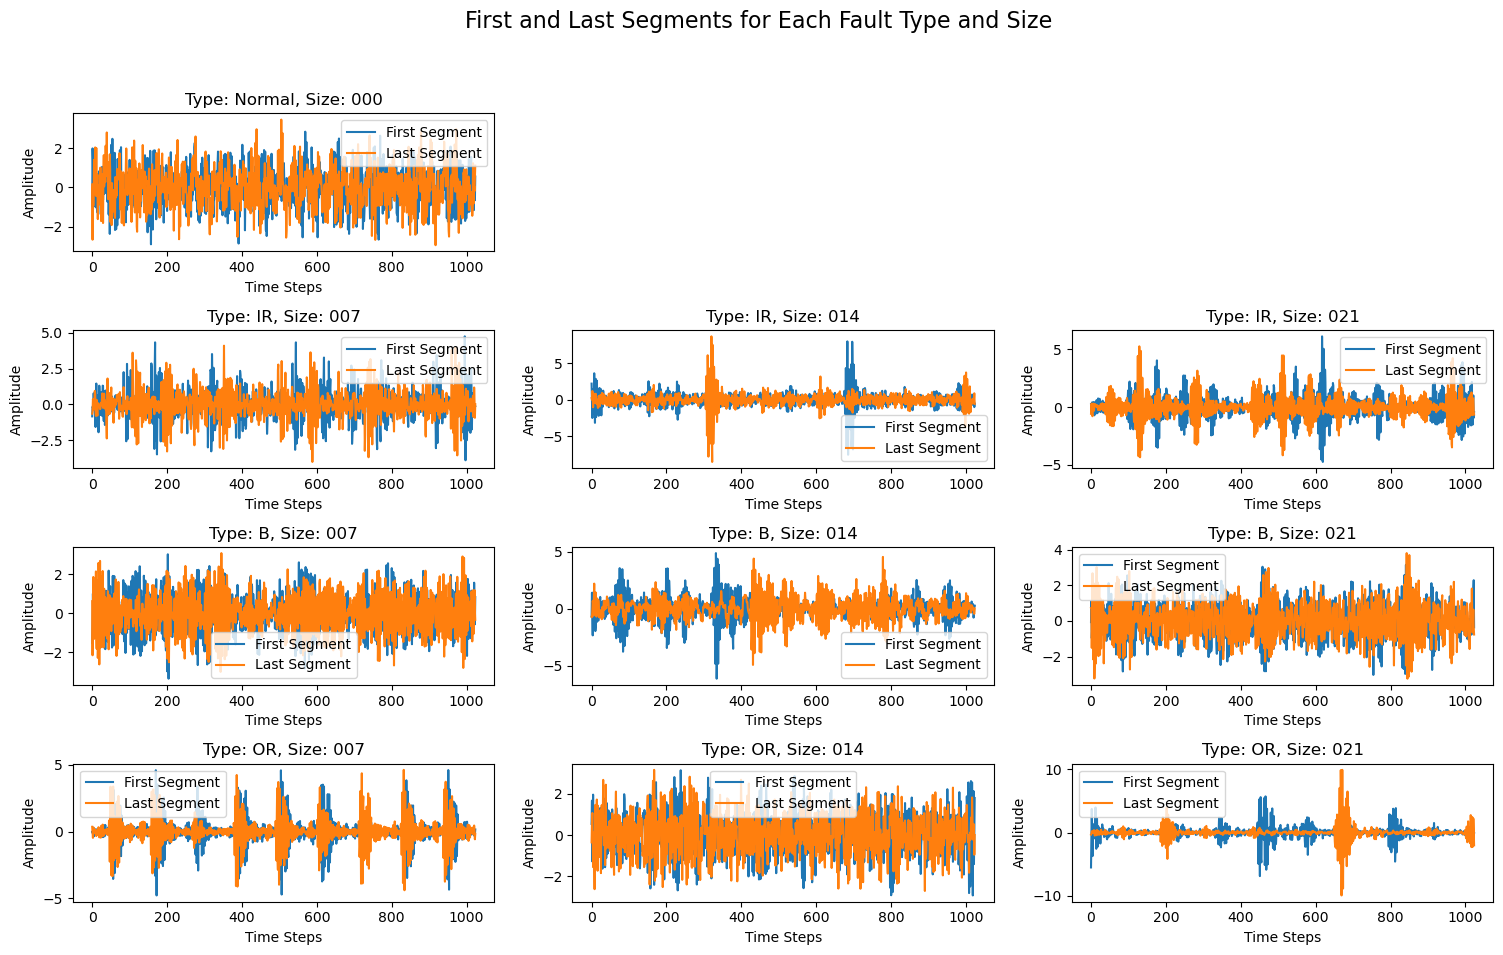


Train Category Counts:
   fault_check_label fault_type_label fault_size_label  count
0            Normal           Normal              000    832
1            Faulty               IR              007    832
2            Faulty               IR              014    832
3            Faulty               IR              021    832
4            Faulty                B              007    832
5            Faulty                B              014    832
6            Faulty                B              021    832
7            Faulty               OR              007    832
8            Faulty               OR              014    832
9            Faulty               OR              021    832
Val Category Counts:
   fault_check_label fault_type_label fault_size_label  count
0            Normal           Normal              000    208
1            Faulty               IR              007    208
2            Faulty               IR              014    208
3            Faulty               IR  

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -----------------------------
# Mappings
# -----------------------------
fault_check_map = {'Normal': 0, 'Faulty': 1}
fault_type_map = {'Normal': 0, 'IR': 1, 'B': 2, 'OR': 3}
fault_size_cls_map = {'000': 0, '007': 1, '014': 2, '021': 3}
fault_size_reg_map = {'000': 0.0, '007': 0.1778, '014': 0.3556, '021': 0.5334}

# -----------------------------
# Paths and Configs
# -----------------------------
target_sr = 12000
segment_len = 1024
hop_len = 368

# Universal hyperparameters
EPOCHS = 10
BATCH_SIZE = 64
NUM_WORKERS = 4
LEARNING_RATE = 1e-3
INPUT_DIM = 1024
NUM_CLASSES = 4   # For fault type classification

# Enable cuDNN benchmark mode
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load and Balance Signals
# -----------------------------
X, y = load_cwru_signals(data_dir, cwru_DE, cwru_Normal, segment_len=segment_len, min_seg_len=1300)

print(f"\nBalanced Data: X.shape = {X.shape}, y.shape = {y.shape}")

# -----------------------------
# Normalize Signals
# -----------------------------
scaler = StandardScaler()
X_scaled = np.array([scaler.fit_transform(sig.reshape(-1, 1)).flatten() for sig in X])

# -----------------------------
# Append Regression Target
# -----------------------------
fault_size_new_reg_map = {
    0: 0.0, 1: 0.1778, 2: 0.3556, 3: 0.5334
}
fault_size_reg = np.vectorize(lambda x: fault_size_new_reg_map.get(x, -1.0))(y[:, 2])
y = np.hstack((y, fault_size_reg.reshape(-1, 1)))

# Scale fault size regression to [0, 1]
scaler_y = MinMaxScaler()
y[:, 3] = scaler_y.fit_transform(y[:, 3].reshape(-1, 1)).flatten()

# -----------------------------
# Padding
# -----------------------------
max_len = max(len(x) for x in X_scaled)
X_padded = np.array([np.pad(x, (0, max_len - len(x))) for x in X_scaled])

# -----------------------------
# Create Combined Labels for Stratification
# -----------------------------
combined_labels = [f"{int(t)}_{int(s)}" for t, s in zip(y[:, 1], y[:, 2])]

# -----------------------------
# Train/Test Split (80/20)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, stratify=combined_labels, random_state=42
)

# -----------------------------
# Train/Validation Split (80/20 of Train)
# -----------------------------
combined_labels_train = [f"{int(t)}_{int(s)}" for t, s in zip(y_train[:, 1], y_train[:, 2])]
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, stratify=combined_labels_train, random_state=42
)

# -----------------------------
# Convert to PyTorch Tensors
# -----------------------------
def to_tensor(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # [N, 1, L]
    y_tensor = torch.tensor(y, dtype=torch.float32)               # Use float32 for mixed targets
    return X_tensor, y_tensor

X_train_tensor, y_train_tensor = to_tensor(X_train_split, y_train_split)
X_val_tensor, y_val_tensor = to_tensor(X_val_split, y_val_split)
X_test_tensor, y_test_tensor = to_tensor(X_test, y_test)

# -----------------------------
# DataLoaders
# -----------------------------
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# -----------------------------
# Debug Prints
# -----------------------------
print("Train:", X_train_tensor.shape, y_train_tensor.shape)
print("Val  :", X_val_tensor.shape, y_val_tensor.shape)
print("Test :", X_test_tensor.shape, y_test_tensor.shape)

# -----------------------------
# Optional: Plot Segments
# -----------------------------
unique_fault_types = np.unique(y[:, 1])
fault_type_sizes = {0: [0], 1: [1, 2, 3], 2: [1, 2, 3], 3: [1, 2, 3]}

plot_segments(X_padded, y, unique_fault_types, fault_type_sizes, fault_type_map, fault_size_cls_map)

# -----------------------------
# Optional: Category Counts
# -----------------------------
train_counts = category_counts_for_set(X_train_split, y_train_split, fault_check_map, fault_type_map, fault_size_cls_map)
val_counts = category_counts_for_set(X_val_split, y_val_split, fault_check_map, fault_type_map, fault_size_cls_map)
test_counts = category_counts_for_set(X_test, y_test, fault_check_map, fault_type_map, fault_size_cls_map)

print("\nTrain Category Counts:\n", train_counts)
print("Val Category Counts:\n", val_counts)
print("Test Category Counts:\n", test_counts)

In [6]:
# Example debug print to inspect fault size distribution in each dataset
for name, y in zip(['Train', 'Val', 'Test'], [y_train, y_val_split, y_test]):
    print(f"{name} set distribution:", dict(zip(*np.unique(y, return_counts=True))))


Train set distribution: {0.0: 4160, 0.33333333333333337: 3120, 0.6666666666666667: 3120, 1.0: 18720, 2.0: 6240, 3.0: 6240}
Val set distribution: {0.0: 832, 0.33333333333333337: 624, 0.6666666666666667: 624, 1.0: 3744, 2.0: 1248, 3.0: 1248}
Test set distribution: {0.0: 1040, 0.33333333333333337: 780, 0.6666666666666667: 780, 1.0: 4680, 2.0: 1560, 3.0: 1560}


## **PyTorch**

### 1. MLP

Validating: 100%|██████████| 33/33 [00:02<00:00, 11.62it/s]



✅ Epoch 1/10 Completed:
Train Loss: 1.6387, Val Loss: 0.6833
Validation - Type Acc: 0.9236, Size: 0.9236, MSE - Size: 0.0462


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.31it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.6124, Val Loss: 0.3060
Validation - Type Acc: 0.9736, Size: 0.9736, MSE - Size: 0.0379


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.88it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.2706, Val Loss: 0.1300
Validation - Type Acc: 0.9957, Size: 0.9957, MSE - Size: 0.0235


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.36it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.1393, Val Loss: 0.0858
Validation - Type Acc: 0.9947, Size: 0.9947, MSE - Size: 0.0200


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.44it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0847, Val Loss: 0.0561
Validation - Type Acc: 0.9923, Size: 0.9923, MSE - Size: 0.0150


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.59it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0913, Val Loss: 0.0779
Validation - Type Acc: 0.9894, Size: 0.9894, MSE - Size: 0.0220


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.66it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0781, Val Loss: 0.0856
Validation - Type Acc: 0.9913, Size: 0.9913, MSE - Size: 0.0131


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.83it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.1075, Val Loss: 0.0992
Validation - Type Acc: 0.9856, Size: 0.9856, MSE - Size: 0.0188


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.34it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0988, Val Loss: 0.0798
Validation - Type Acc: 0.9957, Size: 0.9957, MSE - Size: 0.0156


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.76it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0290, Val Loss: 0.0091
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0069
📊 Evaluating on test set...


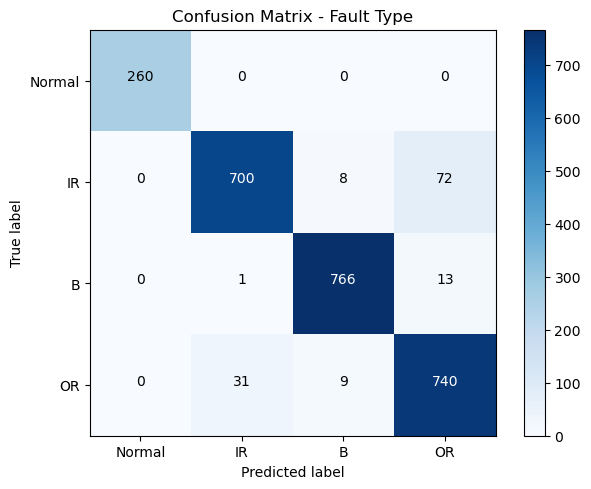

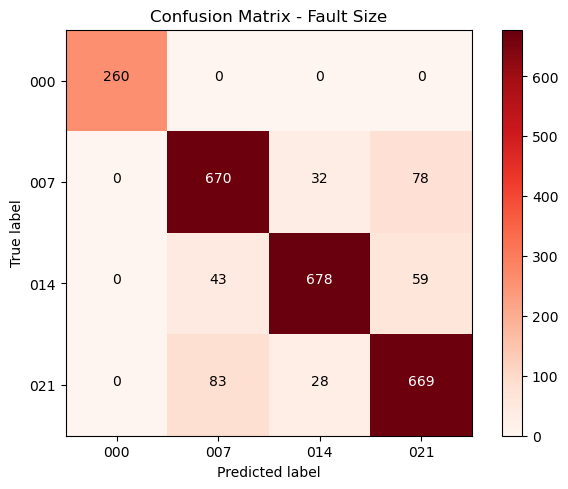

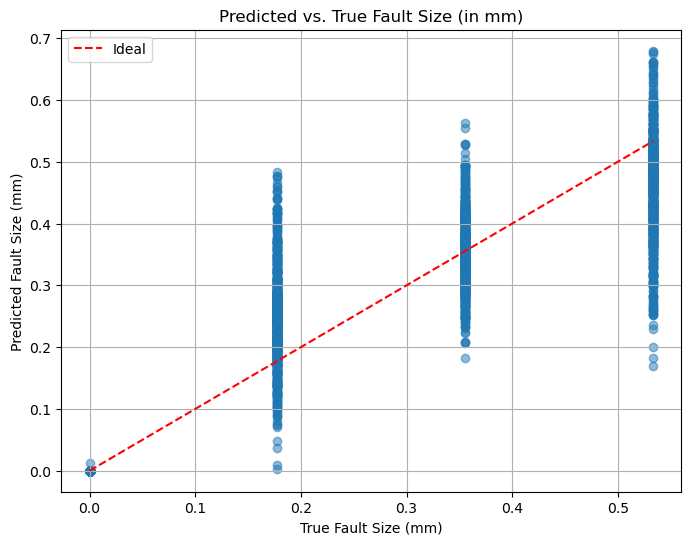


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9485
  ➤ Fault Size Accuracy: 0.8758

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0291
Mean Absolute Error (MAE): 0.1247
R2 Score: 0.7268
Mean Absolute Percentage Error (MAPE): 41643392469.6971

📂 Model saved to ./output\PyTorch/dict_models\MLP_pt.pth
📂 Model saved to ./output\PyTorch/full_models\MLP_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\MLP_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\MLP_pt_test_results.csv


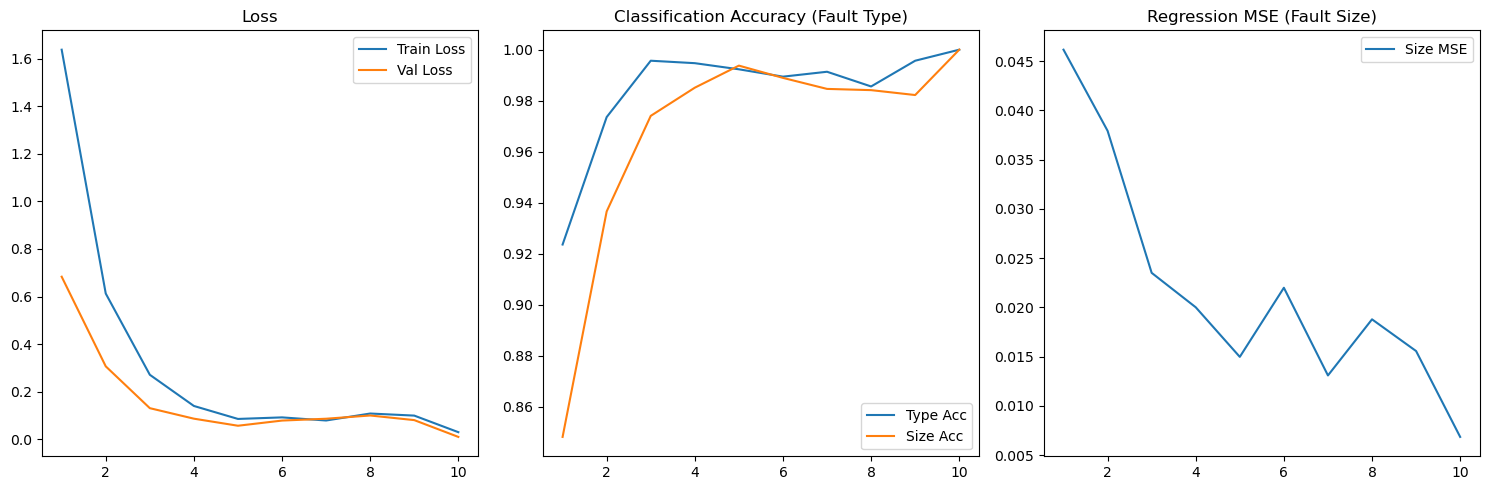

In [7]:
mlp_model = MLP_pt(input_dim=INPUT_DIM, num_classes=NUM_CLASSES).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'MLP_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
mlp_history, mlp_metrics = train_evaluate_model_pt(
        model=mlp_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
# print(mlp_metrics)
plot_training_results(mlp_history)

### 2. CNN

Validating: 100%|██████████| 33/33 [00:03<00:00, 10.80it/s]



✅ Epoch 1/10 Completed:
Train Loss: 0.9411, Val Loss: 0.1843
Validation - Type Acc: 0.9995, Size: 0.9995, MSE - Size: 0.0184


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.35it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.1290, Val Loss: 0.0442
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0081


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.55it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.0513, Val Loss: 0.0199
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0064


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0228, Val Loss: 0.0325
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0053


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0142, Val Loss: 0.0175
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0133


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.81it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0079, Val Loss: 0.0035
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0023


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.89it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0043, Val Loss: 0.0021
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0014


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.45it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0023, Val Loss: 0.0020
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0015


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0017, Val Loss: 0.0013
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0009


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.17it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0017, Val Loss: 0.0015
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0012
📊 Evaluating on test set...


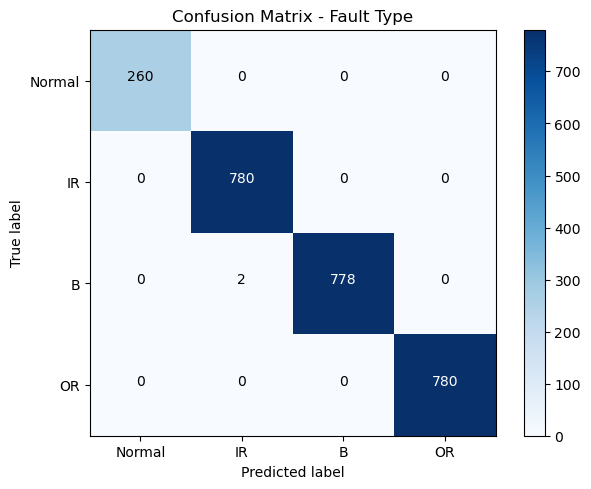

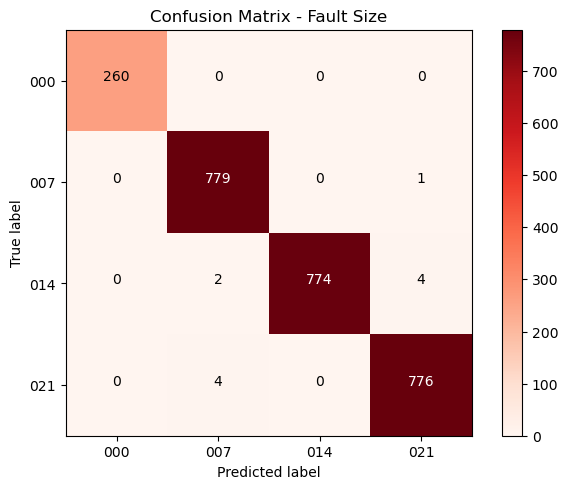

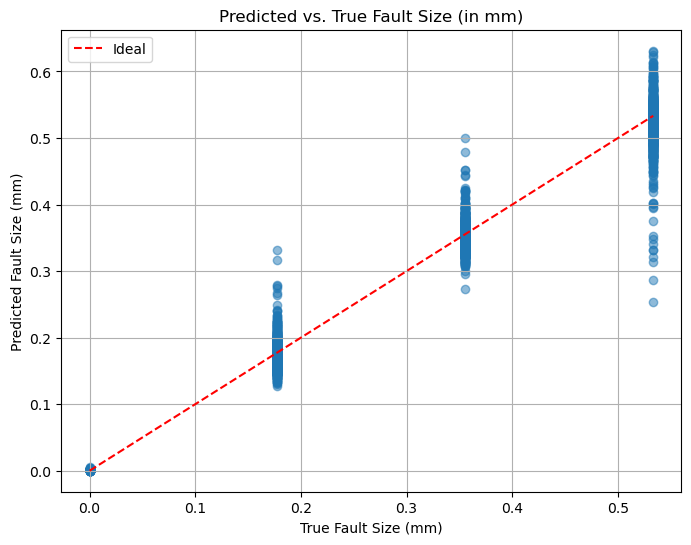


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9992
  ➤ Fault Size Accuracy: 0.9958

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0029
Mean Absolute Error (MAE): 0.0352
R2 Score: 0.9724
Mean Absolute Percentage Error (MAPE): 879382697889.5350

📂 Model saved to ./output\PyTorch/dict_models\CNN1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\CNN1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\CNN1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\CNN1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.9992307692307693, 'fault_size_acc': 0.9957692307692307, 'fault_size_mse': 0.002941487288856416, 'fault_size_rmse': 0.054235479981801726, 'fault_size_mae': 0.03524283894933223, 'fault_size_r2': 0.9724235564615106, 'fault_size_mape': 879382697889.535}


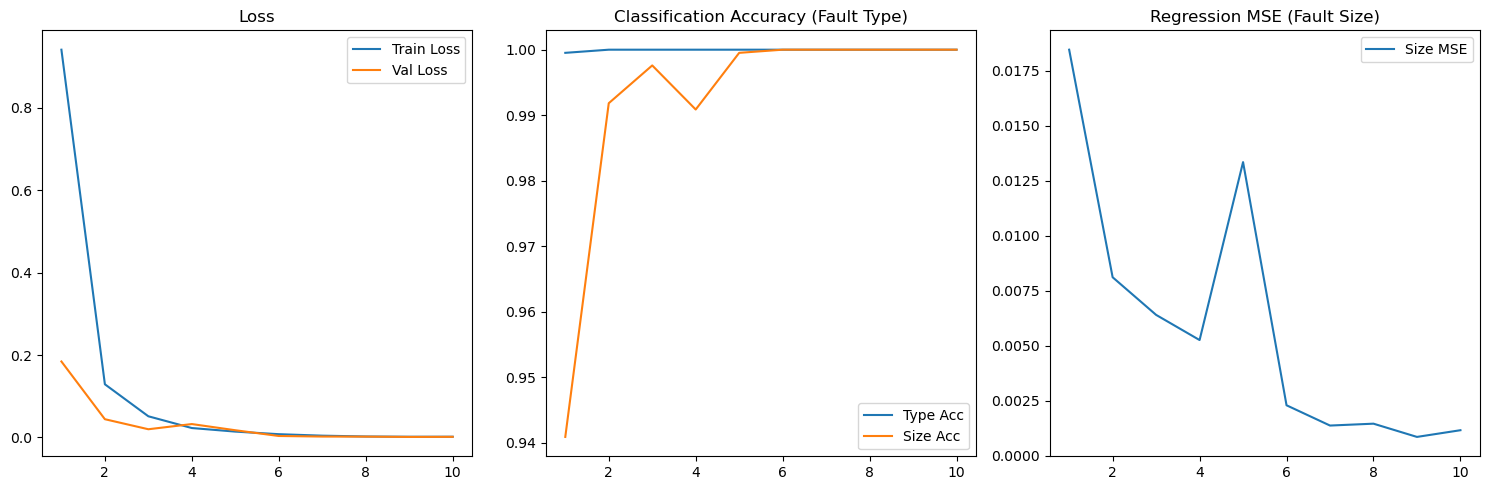

In [8]:
cnn_model = CNN1D_pt(input_size=INPUT_DIM).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'CNN1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
cnn_history, cnn_metrics = train_evaluate_model_pt(
        model=cnn_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(cnn_metrics)
plot_training_results(cnn_history)

### 3. ResNet

Validating: 100%|██████████| 33/33 [00:03<00:00, 10.93it/s]



✅ Epoch 1/10 Completed:
Train Loss: 0.6170, Val Loss: 0.0360
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0148


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.86it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.0560, Val Loss: 0.0259
Validation - Type Acc: 0.9981, Size: 0.9981, MSE - Size: 0.0101


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.86it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.0350, Val Loss: 0.0366
Validation - Type Acc: 0.9966, Size: 0.9966, MSE - Size: 0.0123


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.01it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0325, Val Loss: 0.0100
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0071


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.12it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0137, Val Loss: 0.0064
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0059


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.98it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0372, Val Loss: 0.0039
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0025


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.10it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0090, Val Loss: 0.0029
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0021


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.87it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0079, Val Loss: 0.0016
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0014


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.36it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0082, Val Loss: 0.0049
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0045


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.56it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0060, Val Loss: 0.0014
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0014
📊 Evaluating on test set...


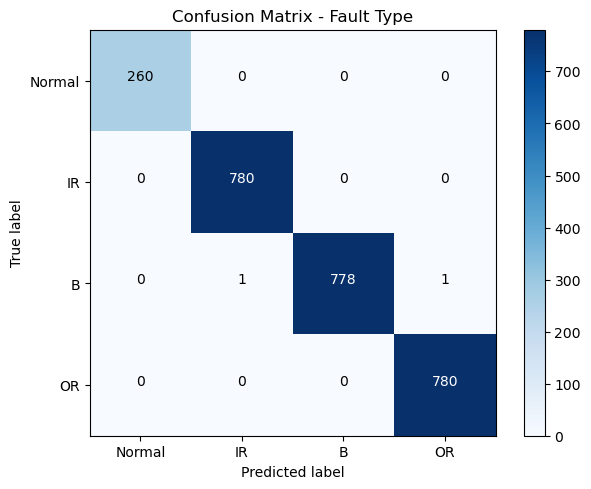

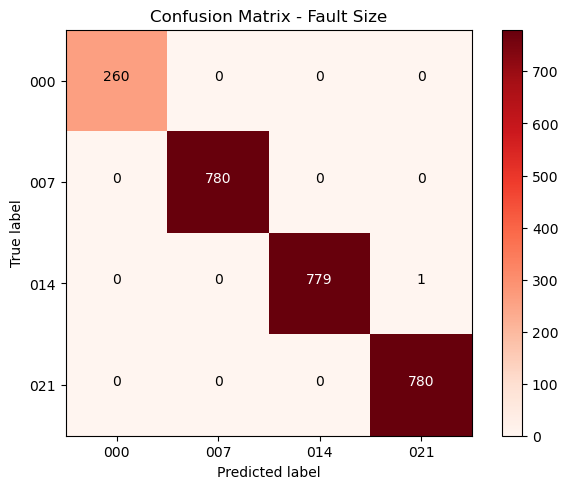

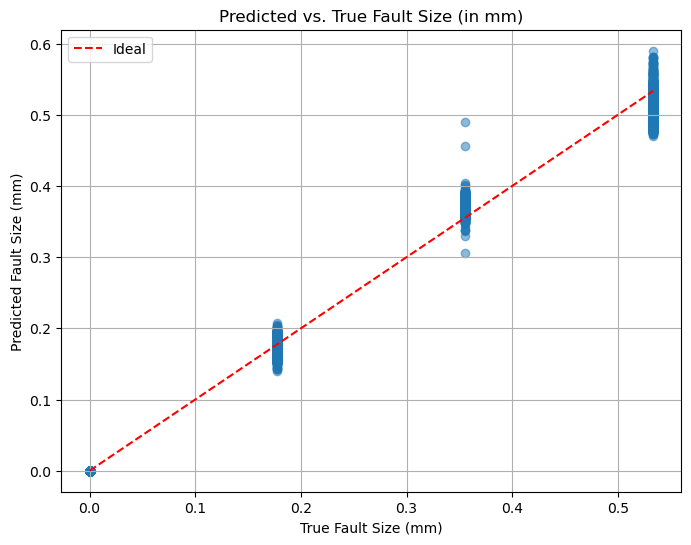


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9992
  ➤ Fault Size Accuracy: 0.9996

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0015
Mean Absolute Error (MAE): 0.0279
R2 Score: 0.9864
Mean Absolute Percentage Error (MAPE): 0.0429

📂 Model saved to ./output\PyTorch/dict_models\ResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\ResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\ResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\ResNet1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.9992307692307693, 'fault_size_acc': 0.9996153846153846, 'fault_size_mse': 0.0014552482484570032, 'fault_size_rmse': 0.03814771616305494, 'fault_size_mae': 0.02787929585346809, 'fault_size_r2': 0.9863570475690677, 'fault_size_mape': 0.04294549255596117}


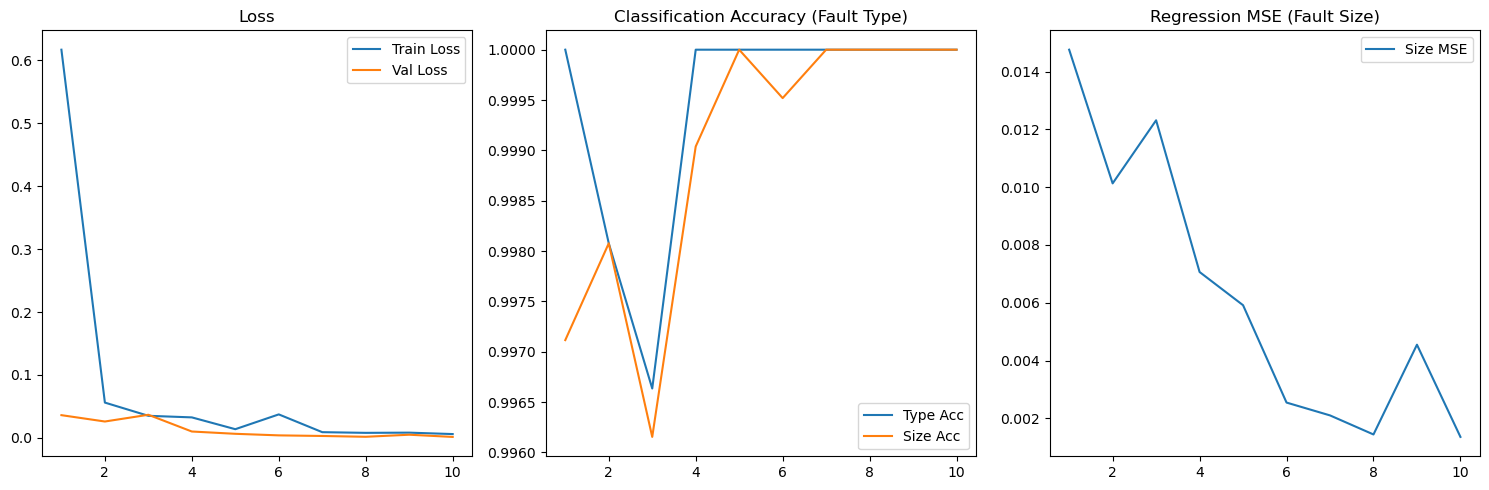

In [9]:
resnet_model = ResNet1D_pt(input_size=INPUT_DIM).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'ResNet1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
resnet_history, resnet_metrics = train_evaluate_model_pt(
        model=resnet_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(resnet_metrics)
plot_training_results(resnet_history)

### 4. LSTM***

Validating: 100%|██████████| 33/33 [00:02<00:00, 11.02it/s]



✅ Epoch 1/10 Completed:
Train Loss: 3.1381, Val Loss: 2.8037
Validation - Type Acc: 0.3202, Size: 0.3202, MSE - Size: 0.1131


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.97it/s]



✅ Epoch 2/10 Completed:
Train Loss: 2.6041, Val Loss: 2.3963
Validation - Type Acc: 0.3909, Size: 0.3909, MSE - Size: 0.0979


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.20it/s]



✅ Epoch 3/10 Completed:
Train Loss: 2.2418, Val Loss: 2.1221
Validation - Type Acc: 0.4587, Size: 0.4587, MSE - Size: 0.0858


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.13it/s]



✅ Epoch 4/10 Completed:
Train Loss: 2.0839, Val Loss: 2.2906
Validation - Type Acc: 0.3990, Size: 0.3990, MSE - Size: 0.1156


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.25it/s]



✅ Epoch 5/10 Completed:
Train Loss: 1.9584, Val Loss: 2.6067
Validation - Type Acc: 0.4707, Size: 0.4707, MSE - Size: 0.0922


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.17it/s]



✅ Epoch 6/10 Completed:
Train Loss: 1.9413, Val Loss: 3.7917
Validation - Type Acc: 0.3630, Size: 0.3630, MSE - Size: 0.1028


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.23it/s]



✅ Epoch 7/10 Completed:
Train Loss: 1.9063, Val Loss: 1.8972
Validation - Type Acc: 0.5197, Size: 0.5197, MSE - Size: 0.0758


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.88it/s]



✅ Epoch 8/10 Completed:
Train Loss: 1.8427, Val Loss: 2.3071
Validation - Type Acc: 0.4327, Size: 0.4327, MSE - Size: 0.1254


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.90it/s]



✅ Epoch 9/10 Completed:
Train Loss: 1.8949, Val Loss: 2.7258
Validation - Type Acc: 0.3091, Size: 0.3091, MSE - Size: 0.1876


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.68it/s]



✅ Epoch 10/10 Completed:
Train Loss: 1.9067, Val Loss: 1.8069
Validation - Type Acc: 0.5380, Size: 0.5380, MSE - Size: 0.0688
📊 Evaluating on test set...


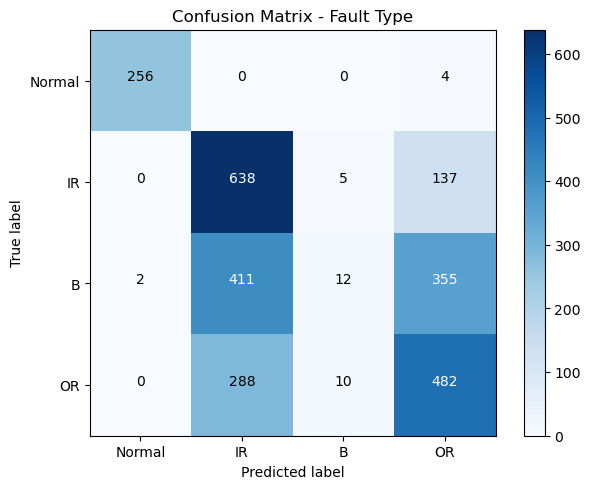

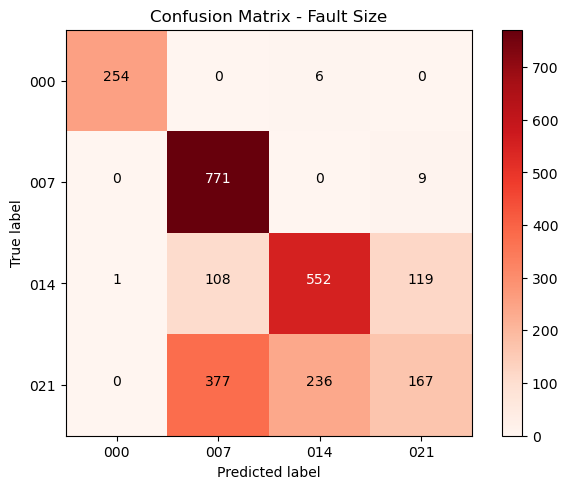

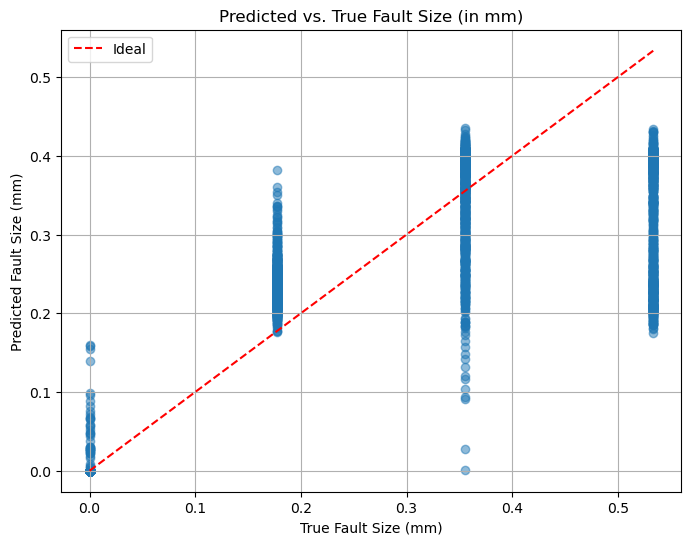


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.5338
  ➤ Fault Size Accuracy: 0.6708

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0669
Mean Absolute Error (MAE): 0.1885
R2 Score: 0.3725
Mean Absolute Percentage Error (MAPE): 7369378912716.2812

📂 Model saved to ./output\PyTorch/dict_models\LSTM1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\LSTM1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\LSTM1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\LSTM1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.5338461538461539, 'fault_size_acc': 0.6707692307692308, 'fault_size_mse': 0.06693442321715441, 'fault_size_rmse': 0.25871687849298586, 'fault_size_mae': 0.18852782158897474, 'fault_size_r2': 0.3724897776638624, 'fault_size_mape': 7369378912716.281}


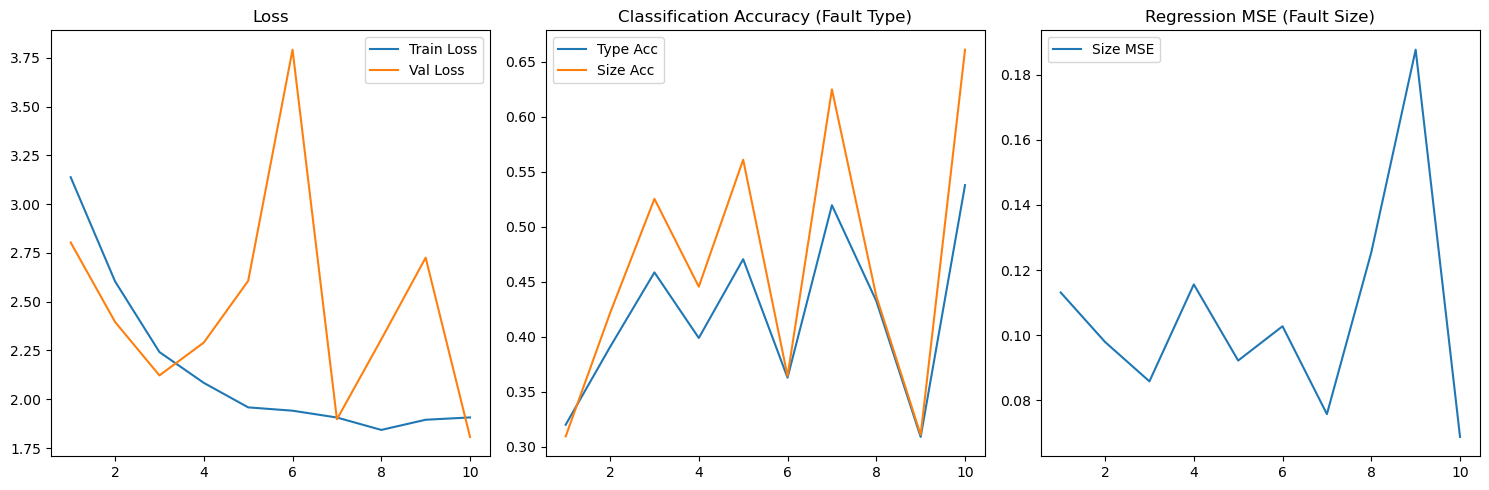

In [15]:
lstm_model = LSTM1D_pt(sequence_length=INPUT_DIM, hidden_size=32).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'LSTM1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
lstm_history, lstm_metrics = train_evaluate_model_pt(
        model=lstm_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(lstm_metrics)
plot_training_results(lstm_history)

### 5. GRU

Validating: 100%|██████████| 33/33 [00:03<00:00, 10.60it/s]



✅ Epoch 1/10 Completed:
Train Loss: 2.7743, Val Loss: 2.7340
Validation - Type Acc: 0.2938, Size: 0.2938, MSE - Size: 0.1062


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.87it/s]



✅ Epoch 2/10 Completed:
Train Loss: 2.7293, Val Loss: 2.7336
Validation - Type Acc: 0.3236, Size: 0.3236, MSE - Size: 0.1077


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.73it/s]



✅ Epoch 3/10 Completed:
Train Loss: 2.7022, Val Loss: 2.5428
Validation - Type Acc: 0.3630, Size: 0.3630, MSE - Size: 0.1047


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.92it/s]



✅ Epoch 4/10 Completed:
Train Loss: 2.0845, Val Loss: 1.8492
Validation - Type Acc: 0.5692, Size: 0.5692, MSE - Size: 0.0781


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.26it/s]



✅ Epoch 5/10 Completed:
Train Loss: 1.6717, Val Loss: 1.3954
Validation - Type Acc: 0.7981, Size: 0.7981, MSE - Size: 0.0653


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.05it/s]



✅ Epoch 6/10 Completed:
Train Loss: 1.1167, Val Loss: 1.0652
Validation - Type Acc: 0.8562, Size: 0.8562, MSE - Size: 0.0465


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.33it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.7375, Val Loss: 0.5953
Validation - Type Acc: 0.9404, Size: 0.9404, MSE - Size: 0.0370


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.84it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.3995, Val Loss: 0.2662
Validation - Type Acc: 0.9788, Size: 0.9788, MSE - Size: 0.0177


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.59it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.2523, Val Loss: 0.1852
Validation - Type Acc: 0.9870, Size: 0.9870, MSE - Size: 0.0148


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.58it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.1739, Val Loss: 0.1623
Validation - Type Acc: 0.9933, Size: 0.9933, MSE - Size: 0.0130
📊 Evaluating on test set...


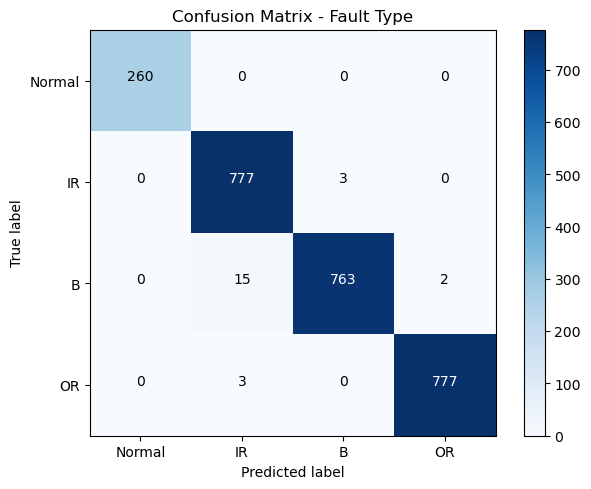

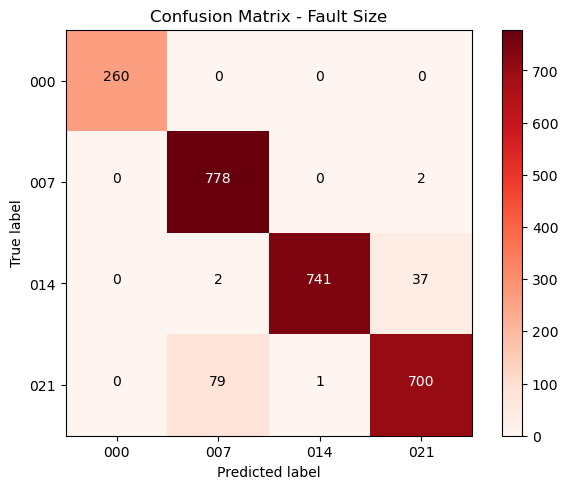

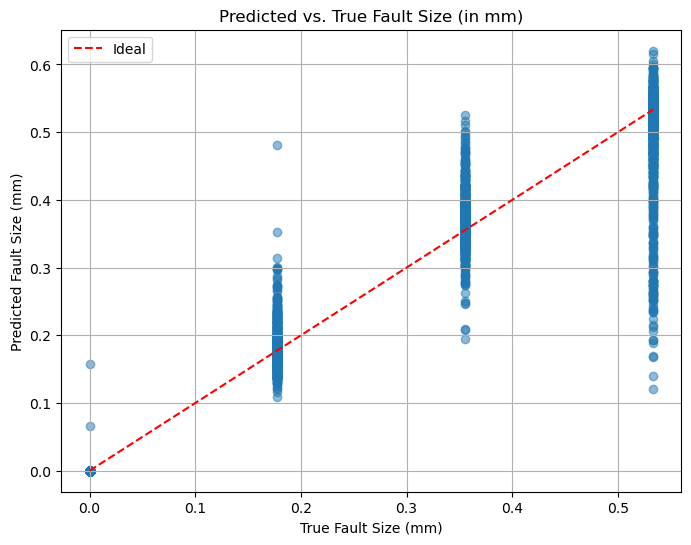


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9912
  ➤ Fault Size Accuracy: 0.9535

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0132
Mean Absolute Error (MAE): 0.0650
R2 Score: 0.8759
Mean Absolute Percentage Error (MAPE): 726709763491.1512

📂 Model saved to ./output\PyTorch/dict_models\GRU1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\GRU1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\GRU1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\GRU1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.9911538461538462, 'fault_size_acc': 0.9534615384615385, 'fault_size_mse': 0.013232665076854555, 'fault_size_rmse': 0.11503332159359111, 'fault_size_mae': 0.06503609489506254, 'fault_size_r2': 0.8759437639801977, 'fault_size_mape': 726709763491.1512}


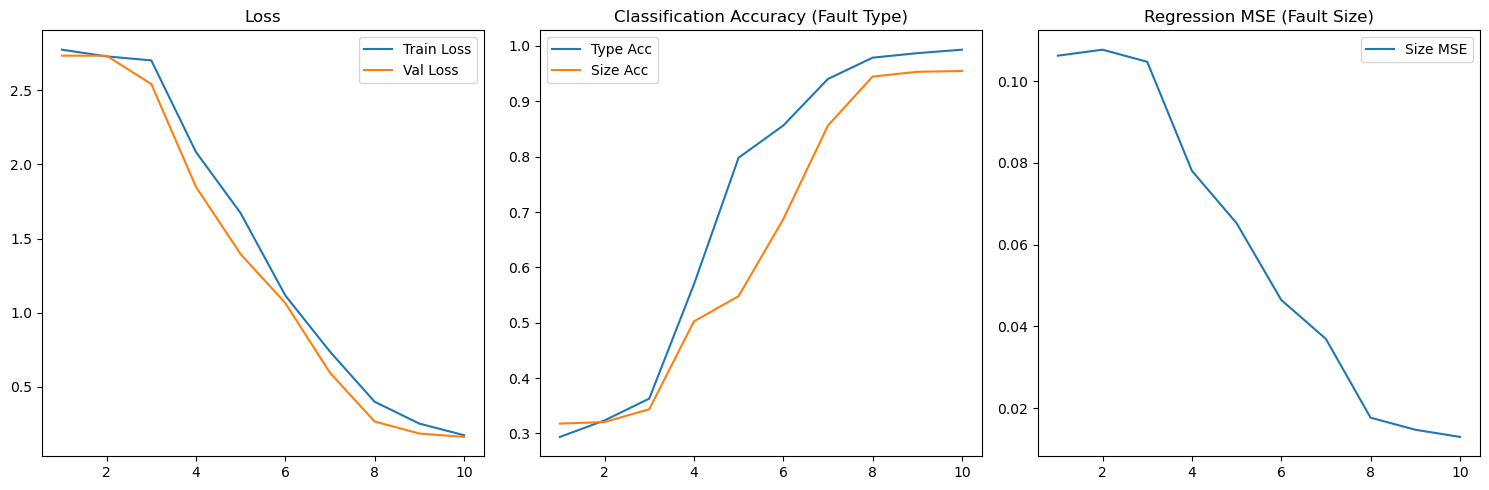

In [16]:
gru_model = GRU1D_pt(seq_len=INPUT_DIM).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'GRU1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
gru_history, gru_metrics = train_evaluate_model_pt(
        model=gru_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(gru_metrics)
plot_training_results(gru_history)

### 6. BiLSTM

Validating: 100%|██████████| 33/33 [00:04<00:00,  7.88it/s]



✅ Epoch 1/10 Completed:
Train Loss: 2.3572, Val Loss: 1.5834
Validation - Type Acc: 0.6817, Size: 0.6817, MSE - Size: 0.0770


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.90it/s]



✅ Epoch 2/10 Completed:
Train Loss: 1.3910, Val Loss: 0.9782
Validation - Type Acc: 0.8591, Size: 0.8591, MSE - Size: 0.0636


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.79it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.9039, Val Loss: 0.6509
Validation - Type Acc: 0.9130, Size: 0.9130, MSE - Size: 0.0475


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.58it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.5168, Val Loss: 0.3515
Validation - Type Acc: 0.9673, Size: 0.9673, MSE - Size: 0.0353


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.69it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.2124, Val Loss: 0.1054
Validation - Type Acc: 0.9947, Size: 0.9947, MSE - Size: 0.0268


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.83it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.1381, Val Loss: 0.1230
Validation - Type Acc: 0.9918, Size: 0.9918, MSE - Size: 0.0356


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.77it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0558, Val Loss: 0.0368
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0292


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.46it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0230, Val Loss: 0.0100
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0072


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.28it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0096, Val Loss: 0.0106
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0089


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.68it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0069, Val Loss: 0.0136
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0128
📊 Evaluating on test set...


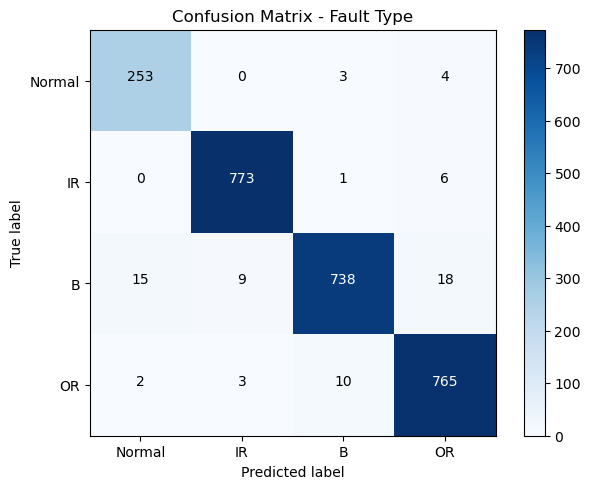

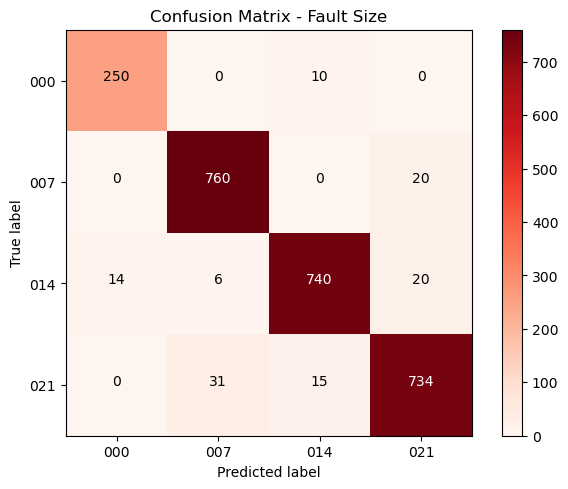

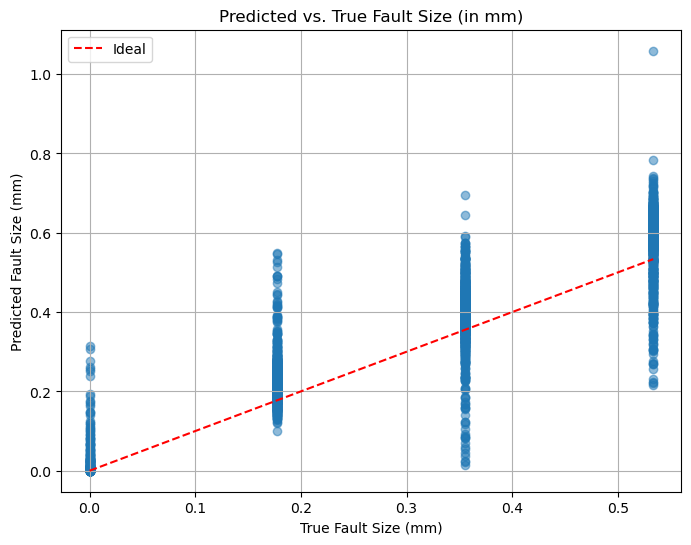


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9727
  ➤ Fault Size Accuracy: 0.9554

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0286
Mean Absolute Error (MAE): 0.1275
R2 Score: 0.7322
Mean Absolute Percentage Error (MAPE): 26397637811814.6016

📂 Model saved to ./output\PyTorch/dict_models\BiLSTM1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\BiLSTM1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\BiLSTM1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\BiLSTM1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.9726923076923077, 'fault_size_acc': 0.9553846153846154, 'fault_size_mse': 0.028563227377555282, 'fault_size_rmse': 0.16900658974594832, 'fault_size_mae': 0.1275005839287587, 'fault_size_r2': 0.7322197413403011, 'fault_size_mape': 26397637811814.6}


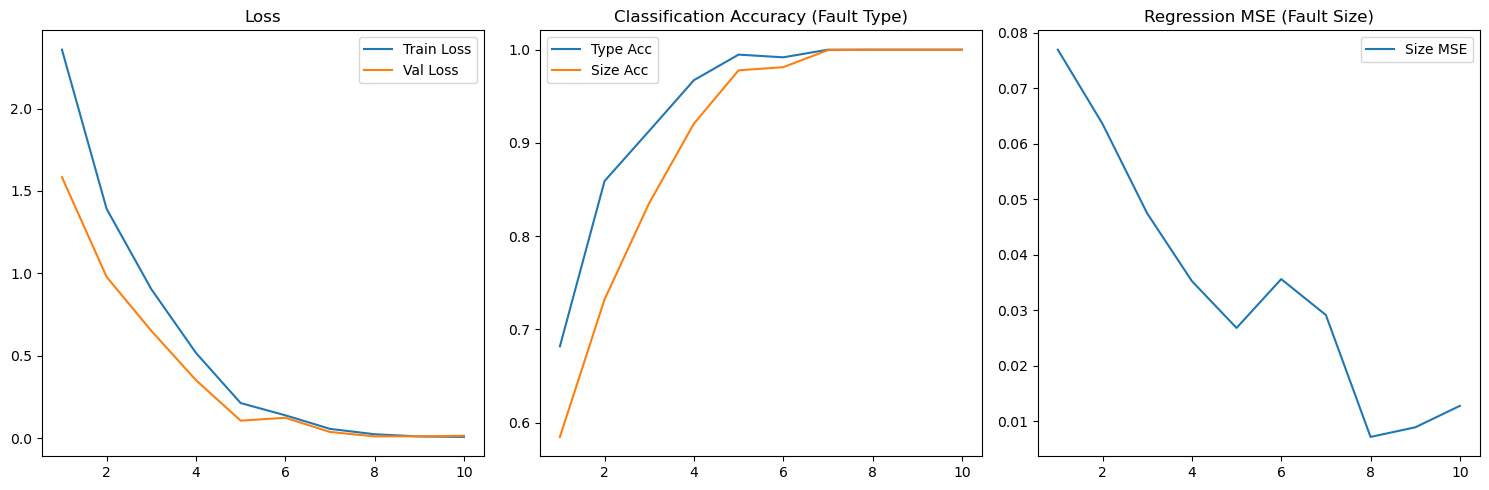

In [17]:
bilstm_model = BiLSTM1D_pt(input_size=INPUT_DIM).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'BiLSTM1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
bilstm_history, bilstm_metrics = train_evaluate_model_pt(
        model=bilstm_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(bilstm_metrics)
plot_training_results(bilstm_history)

### 7. Transformer***

Validating: 100%|██████████| 33/33 [00:04<00:00,  7.79it/s]



✅ Epoch 1/10 Completed:
Train Loss: 3.2026, Val Loss: 3.1759
Validation - Type Acc: 0.4356, Size: 0.4356, MSE - Size: 0.4667


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.74it/s]



✅ Epoch 2/10 Completed:
Train Loss: 2.4571, Val Loss: 2.0556
Validation - Type Acc: 0.6404, Size: 0.6404, MSE - Size: 0.1087


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.59it/s]



✅ Epoch 3/10 Completed:
Train Loss: 2.0872, Val Loss: 1.8488
Validation - Type Acc: 0.7111, Size: 0.7111, MSE - Size: 0.0809


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.52it/s]



✅ Epoch 4/10 Completed:
Train Loss: 1.9199, Val Loss: 1.8586
Validation - Type Acc: 0.7168, Size: 0.7168, MSE - Size: 0.0968


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.34it/s]



✅ Epoch 5/10 Completed:
Train Loss: 1.8497, Val Loss: 1.6949
Validation - Type Acc: 0.7322, Size: 0.7322, MSE - Size: 0.0789


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.72it/s]



✅ Epoch 6/10 Completed:
Train Loss: 1.7425, Val Loss: 1.5997
Validation - Type Acc: 0.7356, Size: 0.7356, MSE - Size: 0.0740


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.66it/s]



✅ Epoch 7/10 Completed:
Train Loss: 1.6086, Val Loss: 1.8591
Validation - Type Acc: 0.5861, Size: 0.5861, MSE - Size: 0.0766


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.58it/s]



✅ Epoch 8/10 Completed:
Train Loss: 1.5721, Val Loss: 1.4800
Validation - Type Acc: 0.7562, Size: 0.7562, MSE - Size: 0.0711


Validating: 100%|██████████| 33/33 [00:04<00:00,  8.06it/s]



✅ Epoch 9/10 Completed:
Train Loss: 1.5050, Val Loss: 1.3897
Validation - Type Acc: 0.7534, Size: 0.7534, MSE - Size: 0.0646


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.92it/s]



✅ Epoch 10/10 Completed:
Train Loss: 1.5235, Val Loss: 1.4690
Validation - Type Acc: 0.7529, Size: 0.7529, MSE - Size: 0.0660
📊 Evaluating on test set...


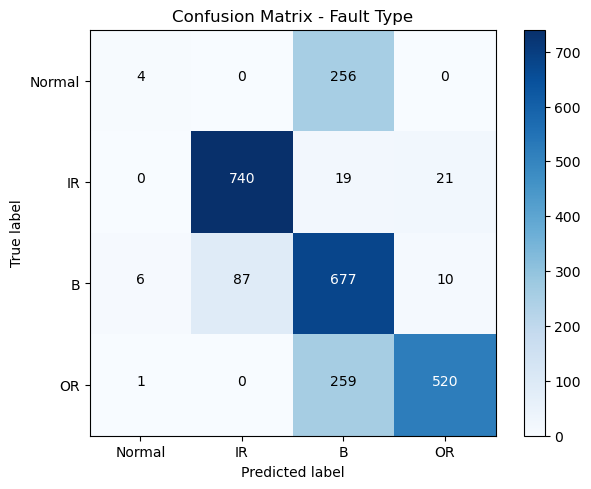

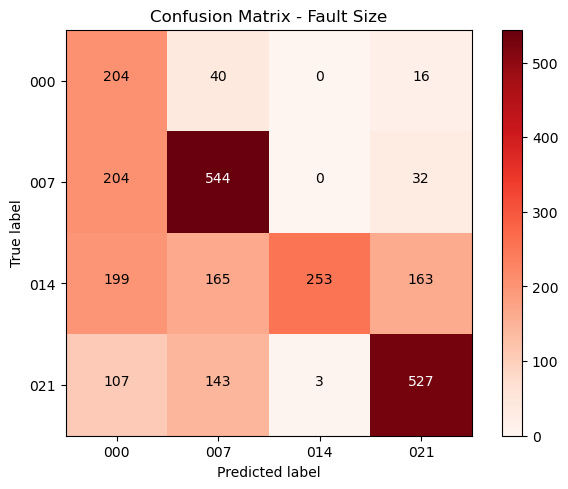

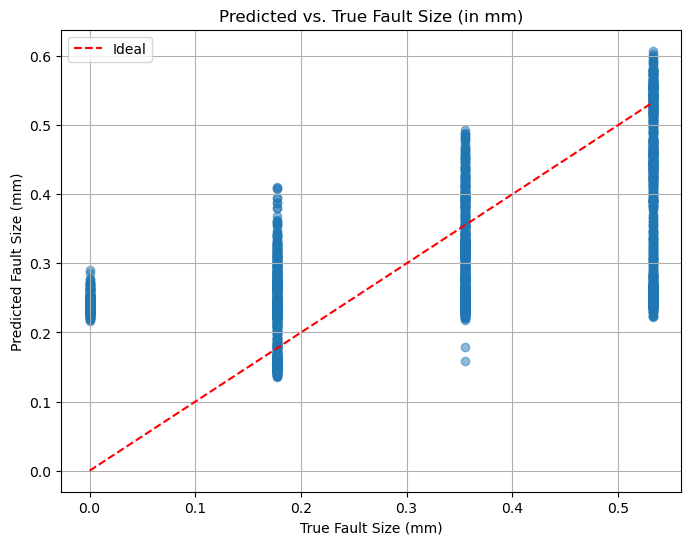


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.7465
  ➤ Fault Size Accuracy: 0.5877

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0680
Mean Absolute Error (MAE): 0.2040
R2 Score: 0.3624
Mean Absolute Percentage Error (MAPE): 204490232439868.1250

📂 Model saved to ./output\PyTorch/dict_models\Transformer1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\Transformer1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\Transformer1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\Transformer1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.7465384615384615, 'fault_size_acc': 0.5876923076923077, 'fault_size_mse': 0.06800773279001249, 'fault_size_rmse': 0.2607829227346233, 'fault_size_mae': 0.20399739223030897, 'fault_size_r2': 0.36242750034334803, 'fault_size_mape': 204490232439868.12}


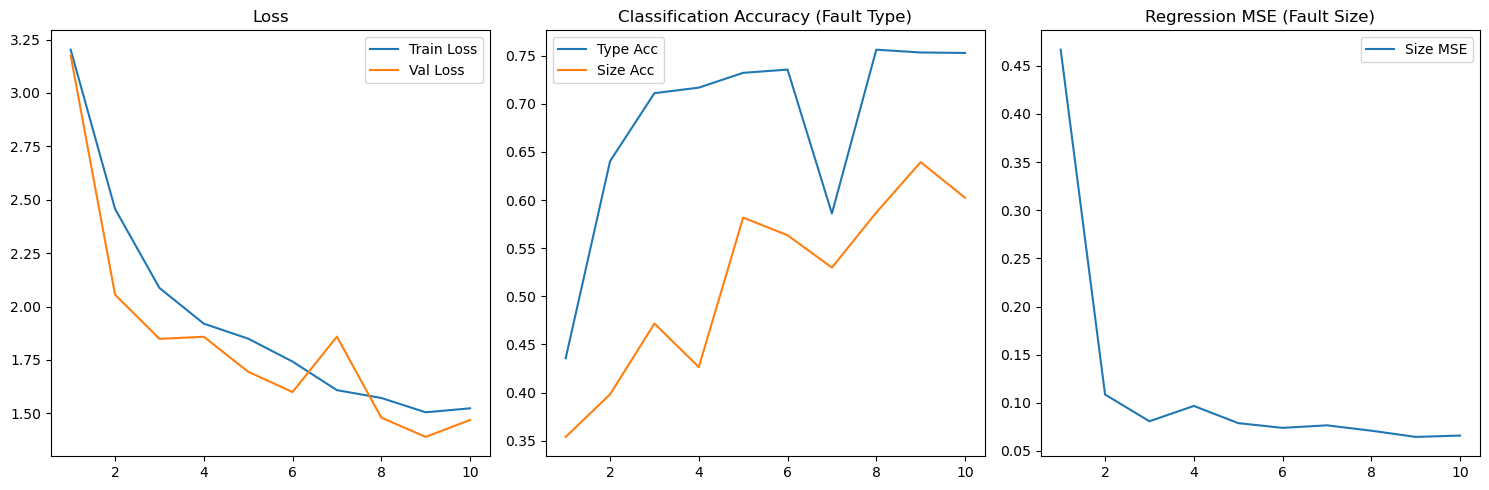

In [10]:
transformer_model = Transformer1D_pt(seq_len=INPUT_DIM, hidden_size=64, num_heads=4, num_layers=2, dropout=0.1, num_classes=NUM_CLASSES).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'Transformer1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
transformer_history, transformer_metrics = train_evaluate_model_pt(
        model=transformer_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(transformer_metrics)
plot_training_results(transformer_history)

### 8. DenseNet

Validating: 100%|██████████| 33/33 [00:03<00:00,  9.64it/s]



✅ Epoch 1/10 Completed:
Train Loss: 0.6575, Val Loss: 0.0969
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0120


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.99it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.1339, Val Loss: 0.6694
Validation - Type Acc: 0.9231, Size: 0.9231, MSE - Size: 0.0534


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.34it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.0216, Val Loss: 0.0062
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0033


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.01it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0083, Val Loss: 0.0364
Validation - Type Acc: 0.9981, Size: 0.9981, MSE - Size: 0.0141


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.56it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0134, Val Loss: 0.0033
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0010


Validating: 100%|██████████| 33/33 [00:03<00:00,  8.49it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0057, Val Loss: 0.0057
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0048


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.53it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0071, Val Loss: 0.0034
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0020


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.41it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0071, Val Loss: 0.0284
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0089


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.54it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0511, Val Loss: 0.0032
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0019


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.28it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0036, Val Loss: 0.0021
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0018
📊 Evaluating on test set...


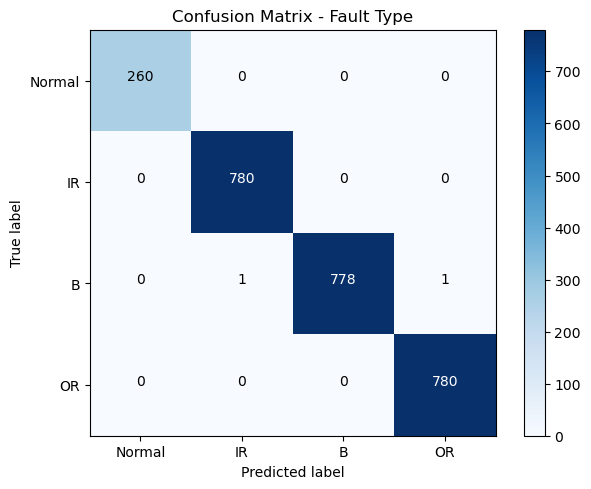

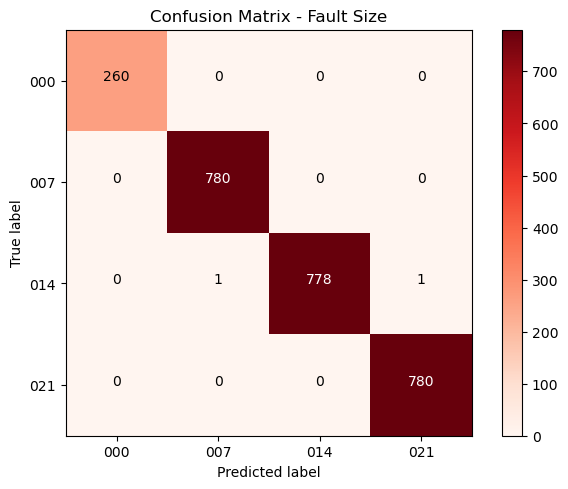

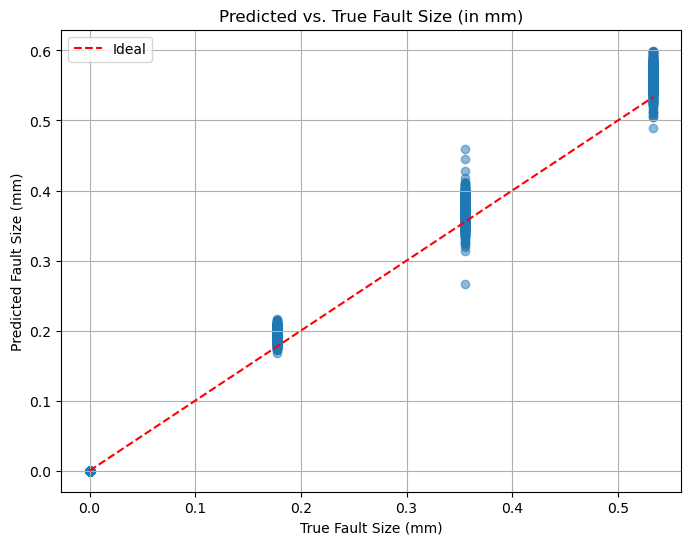


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9992
  ➤ Fault Size Accuracy: 0.9992

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0018
Mean Absolute Error (MAE): 0.0346
R2 Score: 0.9830
Mean Absolute Percentage Error (MAPE): 0.0588

📂 Model saved to ./output\PyTorch/dict_models\DenseNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseNet1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.9992307692307693, 'fault_size_acc': 0.9992307692307693, 'fault_size_mse': 0.0018151117978271228, 'fault_size_rmse': 0.042604128882387945, 'fault_size_mae': 0.03455238993351276, 'fault_size_r2': 0.9829833267685867, 'fault_size_mape': 0.058818590433660084}


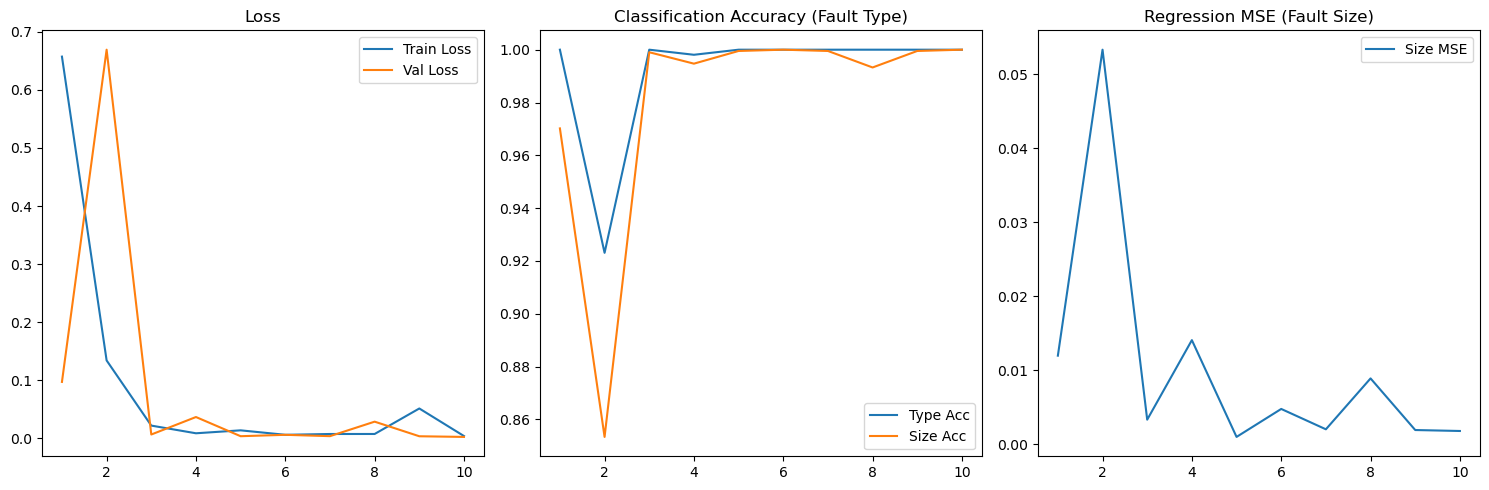

In [18]:
densenet_model = DenseNet1D_pt(input_size=INPUT_DIM).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'DenseNet1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
densenet_history, densenet_metrics = train_evaluate_model_pt(
        model=densenet_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(densenet_metrics)
plot_training_results(densenet_history)

### 9. TinyVGG

Validating: 100%|██████████| 33/33 [00:03<00:00,  9.67it/s]



✅ Epoch 1/10 Completed:
Train Loss: 1.3361, Val Loss: 0.3685
Validation - Type Acc: 0.9889, Size: 0.9889, MSE - Size: 0.0705


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.74it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.1834, Val Loss: 0.0705
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0124


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.78it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.0665, Val Loss: 0.0325
Validation - Type Acc: 0.9995, Size: 0.9995, MSE - Size: 0.0086


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.22it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0285, Val Loss: 0.0193
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0065


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.14it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0121, Val Loss: 0.0088
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0056


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.22it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0049, Val Loss: 0.0032
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0021


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.77it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0028, Val Loss: 0.0032
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0024


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.84it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0026, Val Loss: 0.0017
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0011


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.12it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0020, Val Loss: 0.0016
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0011


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.00it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0025, Val Loss: 0.0025
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0021
📊 Evaluating on test set...


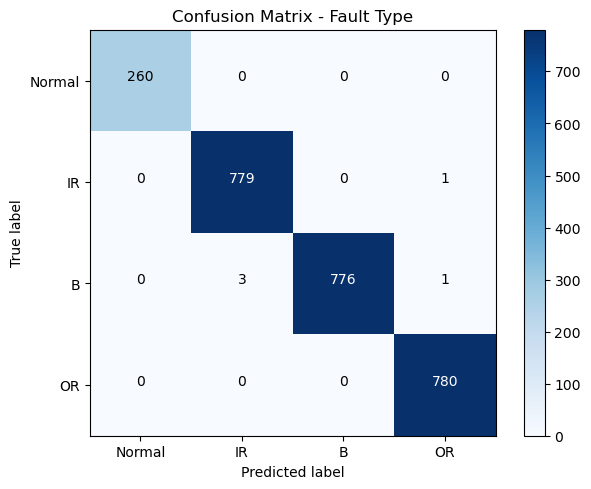

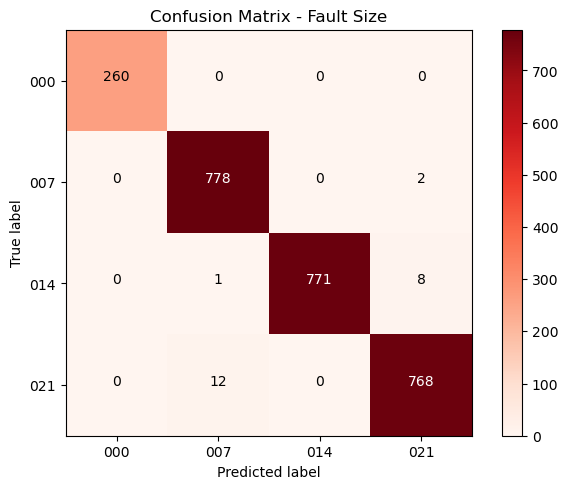

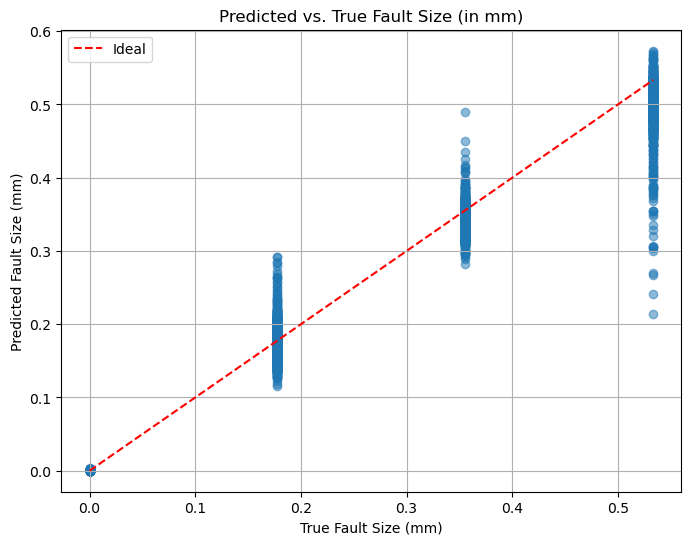


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9981
  ➤ Fault Size Accuracy: 0.9912

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0049
Mean Absolute Error (MAE): 0.0458
R2 Score: 0.9539
Mean Absolute Percentage Error (MAPE): 599225695499.8893

📂 Model saved to ./output\PyTorch/dict_models\TinyVGG1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\TinyVGG1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\TinyVGG1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\TinyVGG1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.9980769230769231, 'fault_size_acc': 0.9911538461538462, 'fault_size_mse': 0.004916243577636774, 'fault_size_rmse': 0.0701159295569614, 'fault_size_mae': 0.045790334971870135, 'fault_size_r2': 0.9539102161162596, 'fault_size_mape': 599225695499.8893}


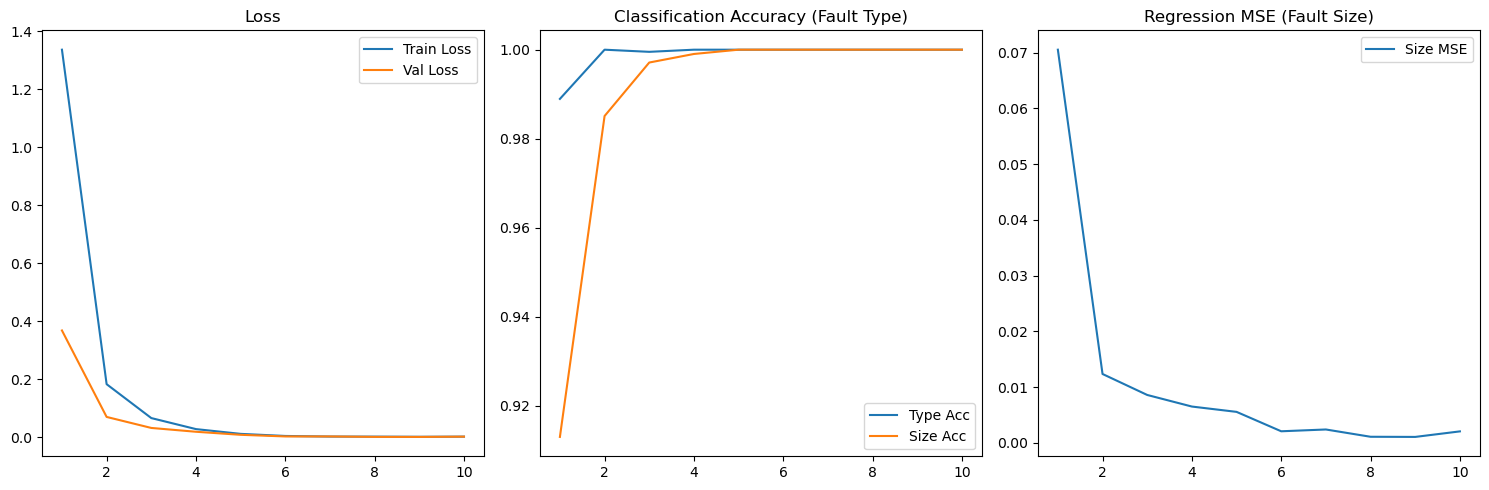

In [19]:
tinyvgg_model = TinyVGG1D_pt(input_size=INPUT_DIM).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'TinyVGG1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
tinyvgg_history, tinyvgg_metrics = train_evaluate_model_pt(
        model=tinyvgg_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(tinyvgg_metrics)
plot_training_results(tinyvgg_history)

### 10. Xception

Validating: 100%|██████████| 33/33 [00:02<00:00, 11.45it/s]



✅ Epoch 1/10 Completed:
Train Loss: 2.4581, Val Loss: 1.8636
Validation - Type Acc: 0.4462, Size: 0.4462, MSE - Size: 0.0664


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.12it/s]



✅ Epoch 2/10 Completed:
Train Loss: 1.4535, Val Loss: 1.1078
Validation - Type Acc: 0.7673, Size: 0.7673, MSE - Size: 0.0464


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.41it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.7600, Val Loss: 0.4122
Validation - Type Acc: 0.9500, Size: 0.9500, MSE - Size: 0.0439


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.53it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.3215, Val Loss: 0.3380
Validation - Type Acc: 0.9596, Size: 0.9596, MSE - Size: 0.0200


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.99it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.1978, Val Loss: 0.2222
Validation - Type Acc: 0.9798, Size: 0.9798, MSE - Size: 0.0167


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.62it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.1800, Val Loss: 0.1486
Validation - Type Acc: 0.9779, Size: 0.9779, MSE - Size: 0.0100


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.33it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.1313, Val Loss: 0.1124
Validation - Type Acc: 0.9837, Size: 0.9837, MSE - Size: 0.0107


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.04it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.1389, Val Loss: 0.0882
Validation - Type Acc: 0.9885, Size: 0.9885, MSE - Size: 0.0109


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.03it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.1310, Val Loss: 0.1220
Validation - Type Acc: 0.9870, Size: 0.9870, MSE - Size: 0.0364


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.20it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.1028, Val Loss: 0.1059
Validation - Type Acc: 0.9856, Size: 0.9856, MSE - Size: 0.0068
📊 Evaluating on test set...


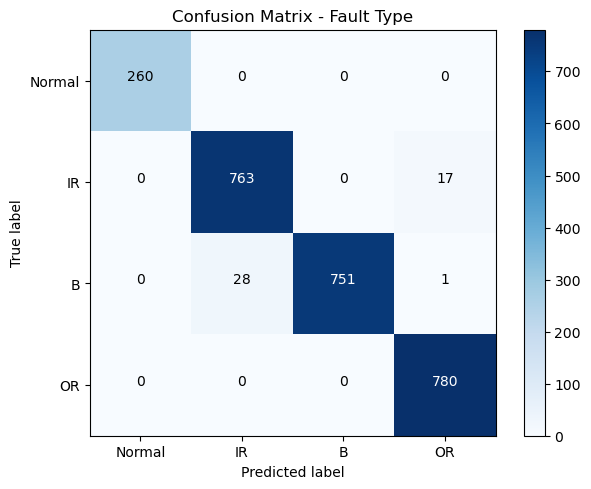

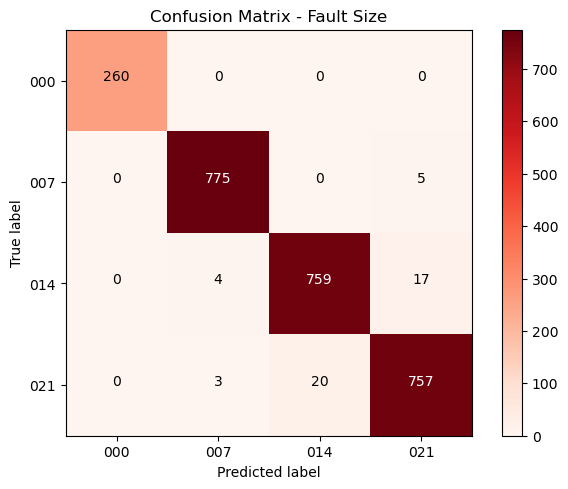

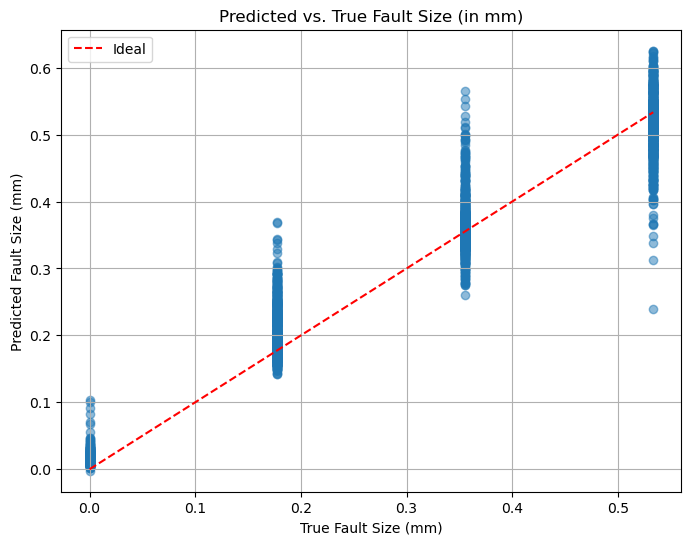


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9823
  ➤ Fault Size Accuracy: 0.9812

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0071
Mean Absolute Error (MAE): 0.0600
R2 Score: 0.9331
Mean Absolute Percentage Error (MAPE): 15530683163455.9082

📂 Model saved to ./output\PyTorch/dict_models\Xception1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\Xception1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\Xception1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\Xception1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.9823076923076923, 'fault_size_acc': 0.9811538461538462, 'fault_size_mse': 0.00713988777718949, 'fault_size_rmse': 0.08449785664257697, 'fault_size_mae': 0.05996901804724565, 'fault_size_r2': 0.9330635515901332, 'fault_size_mape': 15530683163455.908}


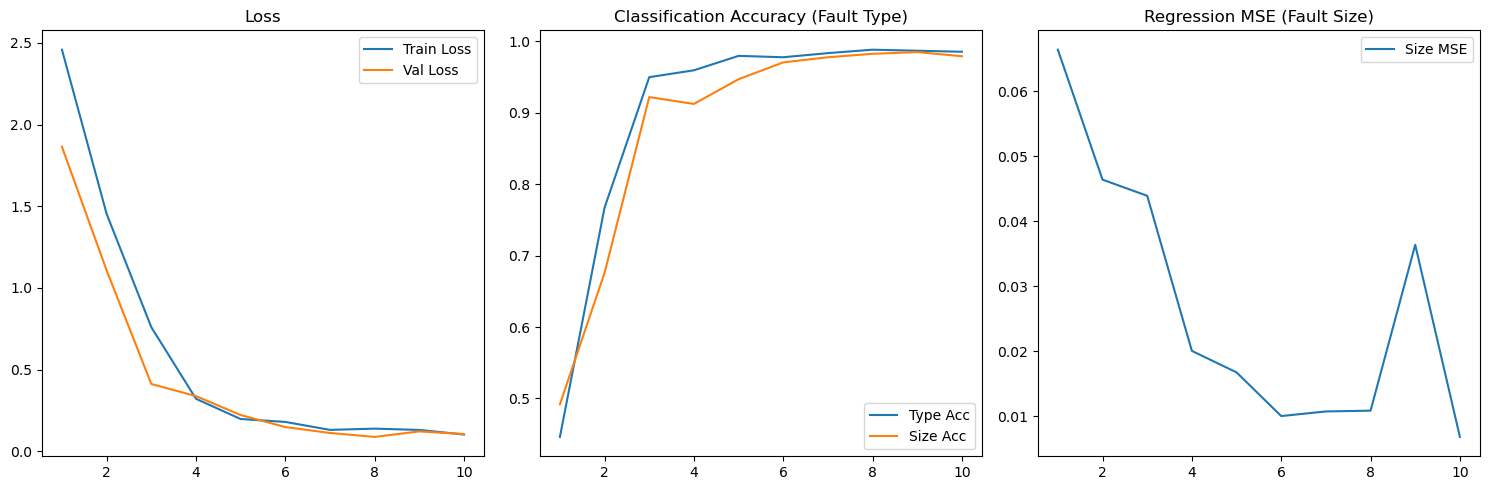

In [20]:
xception_model = Xception1D_pt(input_size=INPUT_DIM).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'Xception1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
xception_history, xception_metrics = train_evaluate_model_pt(
        model=xception_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(xception_metrics)
plot_training_results(xception_history)

### 11. Inception

Validating: 100%|██████████| 33/33 [00:02<00:00, 11.60it/s]



✅ Epoch 1/10 Completed:
Train Loss: 3.3853, Val Loss: 3.3176
Validation - Type Acc: 0.2885, Size: 0.2885, MSE - Size: 0.5515


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.51it/s]



✅ Epoch 2/10 Completed:
Train Loss: 3.2779, Val Loss: 3.1198
Validation - Type Acc: 0.4341, Size: 0.4341, MSE - Size: 0.5532


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.40it/s]



✅ Epoch 3/10 Completed:
Train Loss: 3.0038, Val Loss: 2.7742
Validation - Type Acc: 0.5505, Size: 0.5505, MSE - Size: 0.5367


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.49it/s]



✅ Epoch 4/10 Completed:
Train Loss: 2.8097, Val Loss: 2.6848
Validation - Type Acc: 0.5264, Size: 0.5264, MSE - Size: 0.5424


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.27it/s]



✅ Epoch 5/10 Completed:
Train Loss: 2.6777, Val Loss: 2.5324
Validation - Type Acc: 0.6389, Size: 0.6389, MSE - Size: 0.5440


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.48it/s]



✅ Epoch 6/10 Completed:
Train Loss: 2.5473, Val Loss: 2.4315
Validation - Type Acc: 0.7615, Size: 0.7615, MSE - Size: 0.5428


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.23it/s]



✅ Epoch 7/10 Completed:
Train Loss: 2.4662, Val Loss: 2.3400
Validation - Type Acc: 0.8481, Size: 0.8481, MSE - Size: 0.5385


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.02it/s]



✅ Epoch 8/10 Completed:
Train Loss: 2.4098, Val Loss: 2.3044
Validation - Type Acc: 0.8952, Size: 0.8952, MSE - Size: 0.5406


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.62it/s]



✅ Epoch 9/10 Completed:
Train Loss: 2.3608, Val Loss: 2.2905
Validation - Type Acc: 0.9308, Size: 0.9308, MSE - Size: 0.5416


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.48it/s]



✅ Epoch 10/10 Completed:
Train Loss: 2.3223, Val Loss: 2.2303
Validation - Type Acc: 0.9596, Size: 0.9596, MSE - Size: 0.5430
📊 Evaluating on test set...


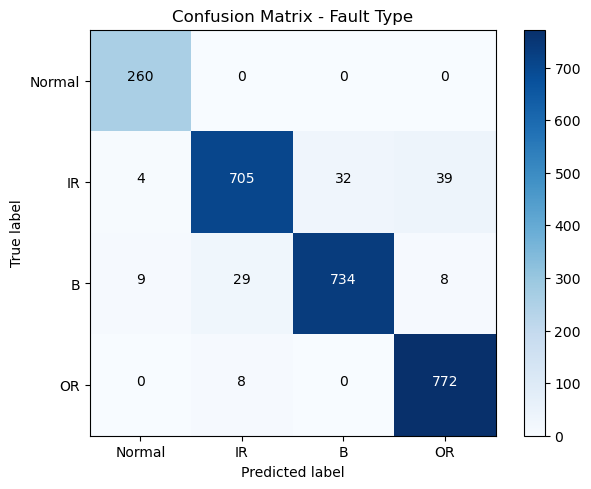

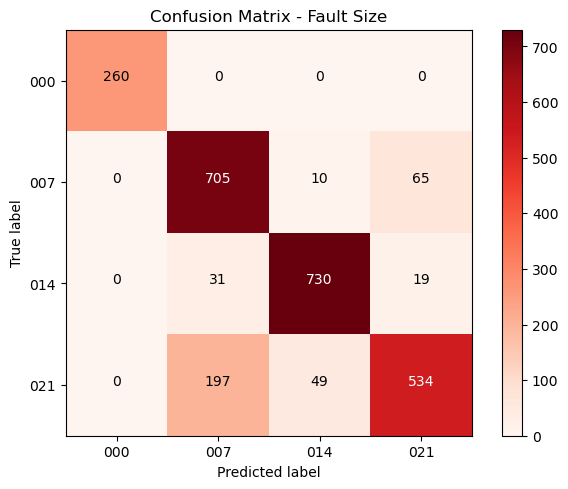

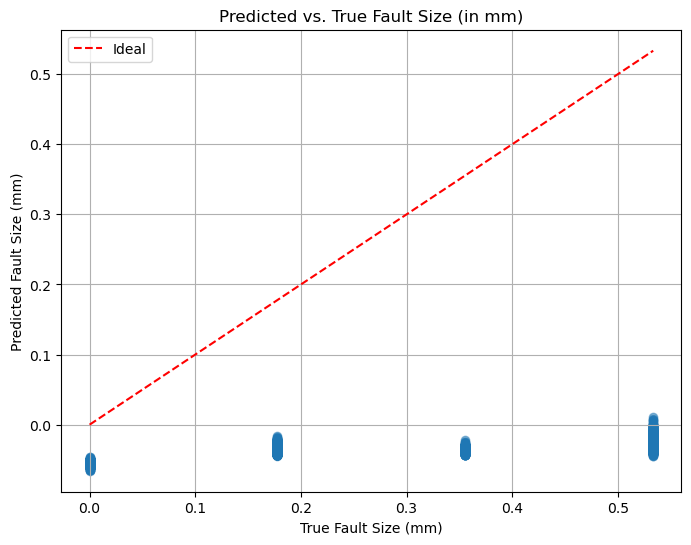


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9504
  ➤ Fault Size Accuracy: 0.8573

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.5429
Mean Absolute Error (MAE): 0.6659
R2 Score: -4.0894
Mean Absolute Percentage Error (MAPE): 46121892997114.7031

📂 Model saved to ./output\PyTorch/dict_models\Inception1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\Inception1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\Inception1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\Inception1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.9503846153846154, 'fault_size_acc': 0.8573076923076923, 'fault_size_mse': 0.5428656656263031, 'fault_size_rmse': 0.7367941813195209, 'fault_size_mae': 0.6659138909490923, 'fault_size_r2': -4.089365653165317, 'fault_size_mape': 46121892997114.7}


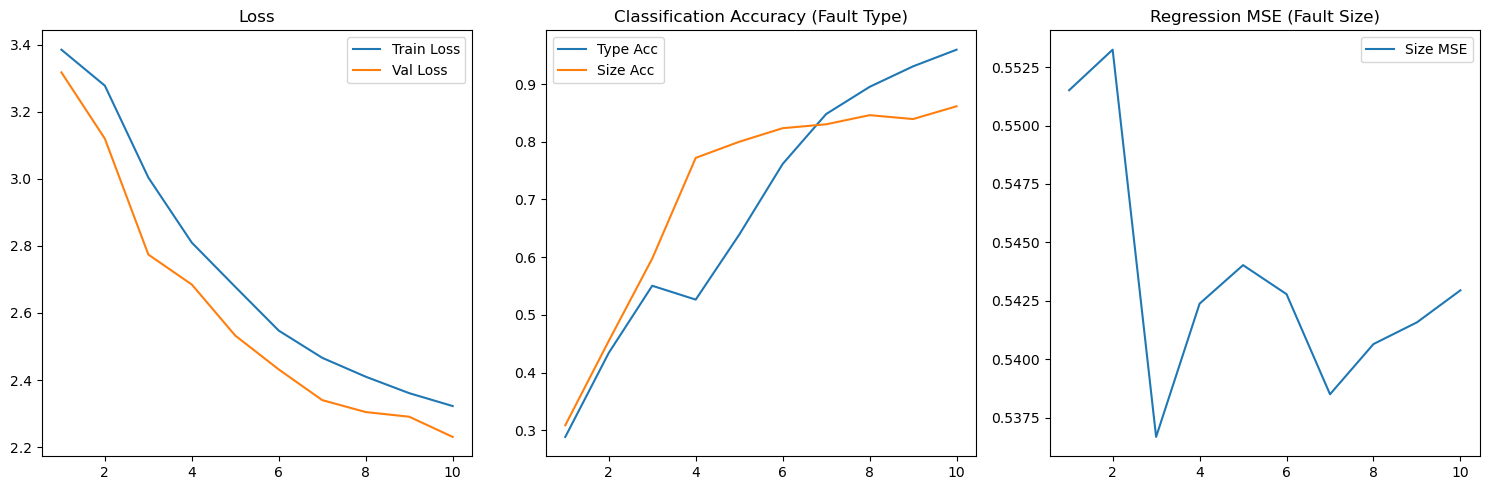

In [21]:
inception_model = Inception1D_pt(input_size=INPUT_DIM).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'Inception1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
inception_history, inception_metrics = train_evaluate_model_pt(
        model=inception_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(inception_metrics)
plot_training_results(inception_history)

### 12. MobileNet

Validating: 100%|██████████| 33/33 [00:02<00:00, 11.42it/s]



✅ Epoch 1/10 Completed:
Train Loss: 2.0228, Val Loss: 1.2010
Validation - Type Acc: 0.8409, Size: 0.8409, MSE - Size: 0.0546


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.54it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.6331, Val Loss: 0.2636
Validation - Type Acc: 0.9846, Size: 0.9846, MSE - Size: 0.0158


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.57it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.1652, Val Loss: 0.1201
Validation - Type Acc: 0.9952, Size: 0.9952, MSE - Size: 0.0186


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.67it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0931, Val Loss: 0.0582
Validation - Type Acc: 0.9966, Size: 0.9966, MSE - Size: 0.0106


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.11it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0841, Val Loss: 0.0841
Validation - Type Acc: 0.9865, Size: 0.9865, MSE - Size: 0.0118


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.15it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0337, Val Loss: 0.0325
Validation - Type Acc: 0.9995, Size: 0.9995, MSE - Size: 0.0117


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.87it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0169, Val Loss: 0.0108
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0035


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.50it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0098, Val Loss: 0.0082
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0042


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.90it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0071, Val Loss: 0.0042
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0021


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.04it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0049, Val Loss: 0.0034
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0017
📊 Evaluating on test set...


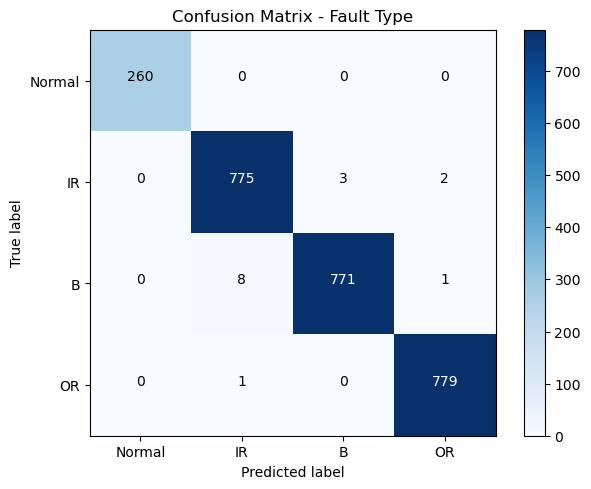

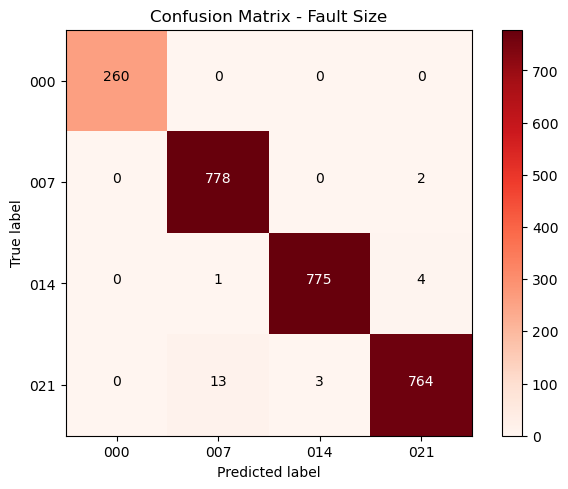

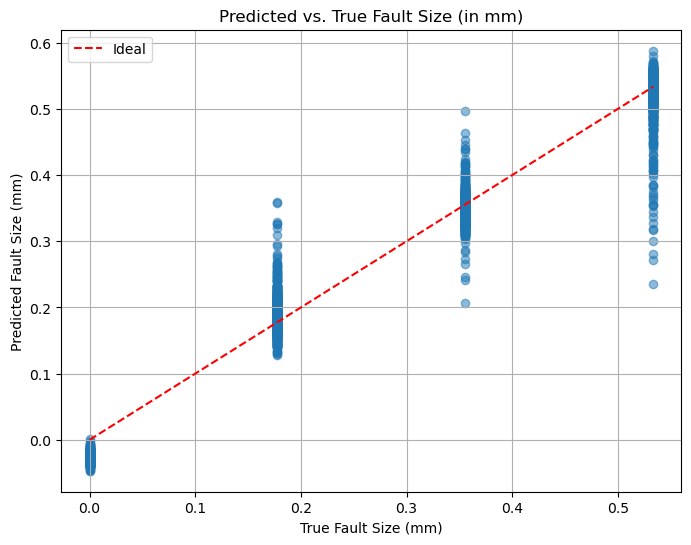


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9942
  ➤ Fault Size Accuracy: 0.9912

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0038
Mean Absolute Error (MAE): 0.0401
R2 Score: 0.9645
Mean Absolute Percentage Error (MAPE): 21657332879700.3438

📂 Model saved to ./output\PyTorch/dict_models\MobileNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\MobileNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\MobileNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\MobileNet1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.9942307692307693, 'fault_size_acc': 0.9911538461538462, 'fault_size_mse': 0.003785329887511552, 'fault_size_rmse': 0.061525034640474215, 'fault_size_mae': 0.04005914105532261, 'fault_size_r2': 0.964512532040177, 'fault_size_mape': 21657332879700.344}


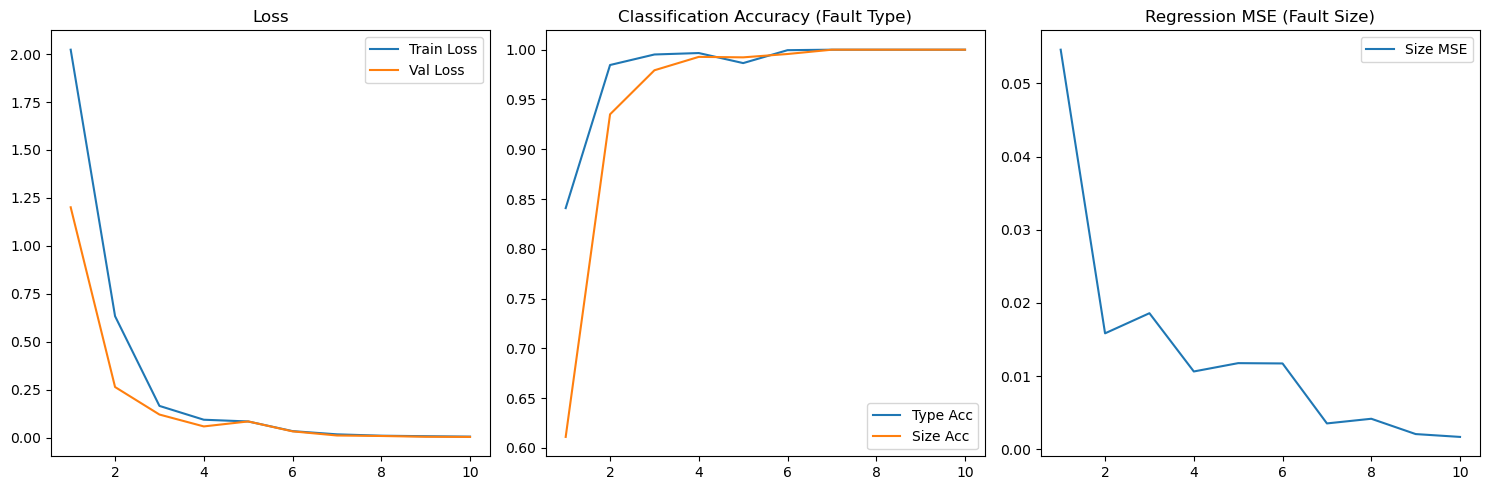

In [22]:
mobilenet_model = MobileNet1D_pt(input_size=INPUT_DIM).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'MobileNet1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
mobilenet_history, mobilenet_metrics = train_evaluate_model_pt(
        model=mobilenet_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(mobilenet_metrics)
plot_training_results(mobilenet_history)

### 13. EfficientNet

Validating: 100%|██████████| 33/33 [00:02<00:00, 12.10it/s]



✅ Epoch 1/10 Completed:
Train Loss: 2.3004, Val Loss: 1.4556
Validation - Type Acc: 0.6452, Size: 0.6452, MSE - Size: 0.0689


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.21it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.7542, Val Loss: 0.3108
Validation - Type Acc: 0.9870, Size: 0.9870, MSE - Size: 0.0516


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.03it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.2579, Val Loss: 0.2434
Validation - Type Acc: 0.9904, Size: 0.9904, MSE - Size: 0.0622


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.50it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.1558, Val Loss: 0.1184
Validation - Type Acc: 0.9981, Size: 0.9981, MSE - Size: 0.0223


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.64it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0842, Val Loss: 0.0692
Validation - Type Acc: 0.9986, Size: 0.9986, MSE - Size: 0.0305


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.99it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0731, Val Loss: 0.0679
Validation - Type Acc: 0.9981, Size: 0.9981, MSE - Size: 0.0142


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.73it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0568, Val Loss: 0.0364
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0094


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.04it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0264, Val Loss: 0.0140
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0041


Validating: 100%|██████████| 33/33 [00:02<00:00, 12.14it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0379, Val Loss: 0.0248
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0085


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.45it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.1576, Val Loss: 0.0336
Validation - Type Acc: 0.9986, Size: 0.9986, MSE - Size: 0.0074
📊 Evaluating on test set...


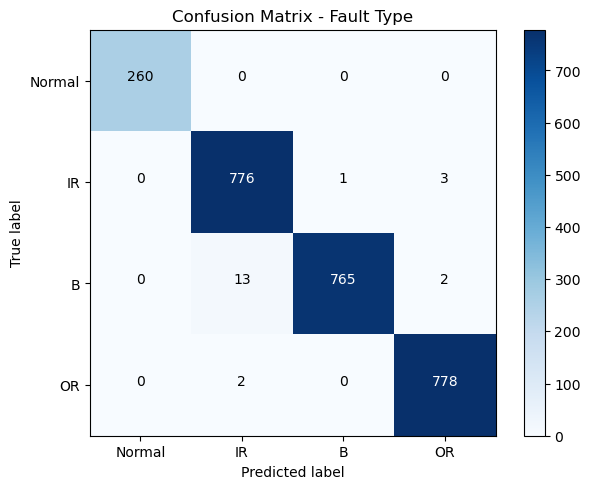

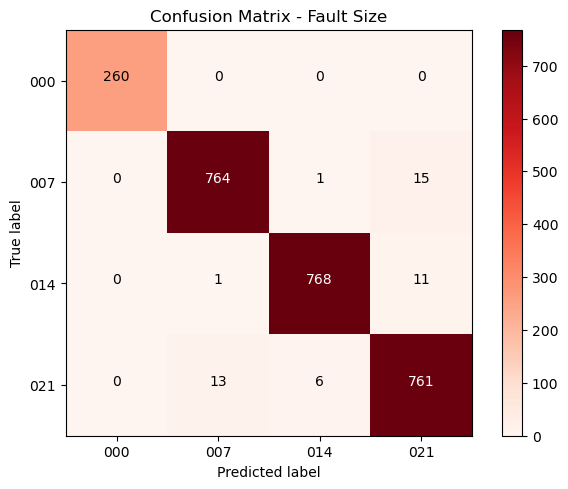

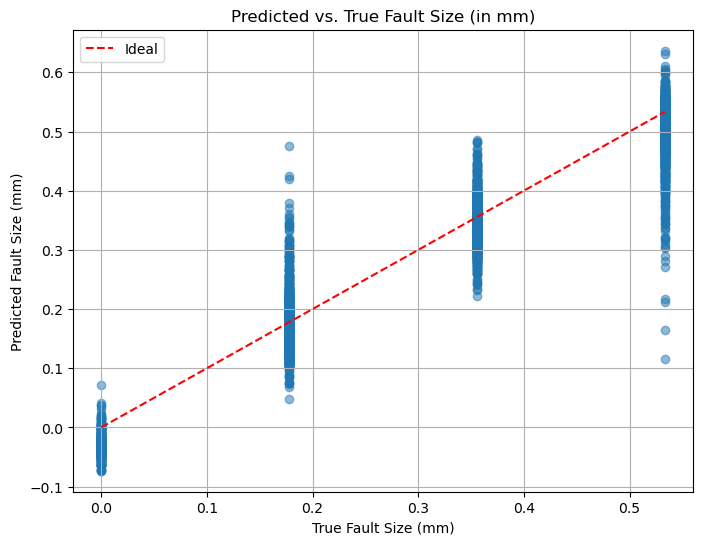


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9919
  ➤ Fault Size Accuracy: 0.9819

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0107
Mean Absolute Error (MAE): 0.0755
R2 Score: 0.8994
Mean Absolute Percentage Error (MAPE): 25292713062563.9648

📂 Model saved to ./output\PyTorch/dict_models\EfficientNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\EfficientNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\EfficientNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\EfficientNet1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.9919230769230769, 'fault_size_acc': 0.9819230769230769, 'fault_size_mse': 0.01072950392525602, 'fault_size_rmse': 0.10358331875961506, 'fault_size_mae': 0.07545875883088089, 'fault_size_r2': 0.8994108999512777, 'fault_size_mape': 25292713062563.965}


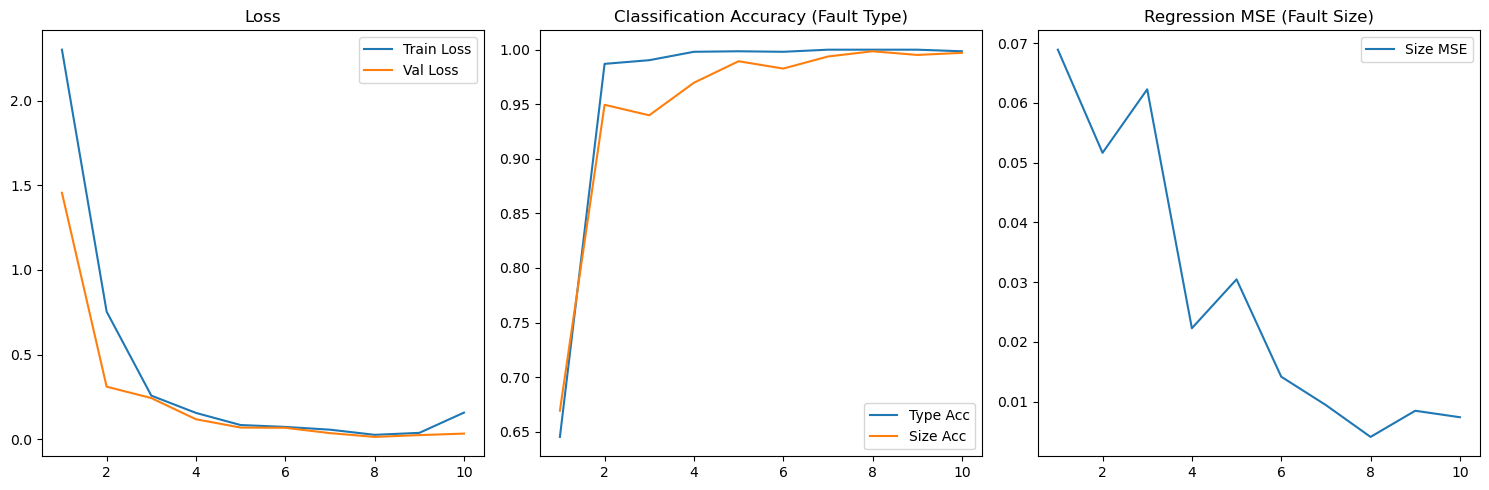

In [23]:
efficientnet_model = EfficientNet1D_pt(input_size=INPUT_DIM).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'EfficientNet1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
efficientnet_history, efficientnet_metrics = train_evaluate_model_pt(
        model=efficientnet_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(efficientnet_metrics)
plot_training_results(efficientnet_history)

### 14. DeepCNN

Validating: 100%|██████████| 33/33 [00:02<00:00, 11.33it/s]



✅ Epoch 1/10 Completed:
Train Loss: 1.3301, Val Loss: 0.3681
Validation - Type Acc: 0.9774, Size: 0.9774, MSE - Size: 0.0281


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.48it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.1832, Val Loss: 0.1321
Validation - Type Acc: 0.9909, Size: 0.9909, MSE - Size: 0.0322


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.34it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.1420, Val Loss: 0.0573
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0239


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.97it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0336, Val Loss: 0.0117
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0065


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.37it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0129, Val Loss: 0.0058
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0031


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.95it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0054, Val Loss: 0.0028
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0022


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.97it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0024, Val Loss: 0.0027
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0023


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.19it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0018, Val Loss: 0.0017
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0015


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.86it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0018, Val Loss: 0.0092
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0089


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.96it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0019, Val Loss: 0.0014
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0012
📊 Evaluating on test set...


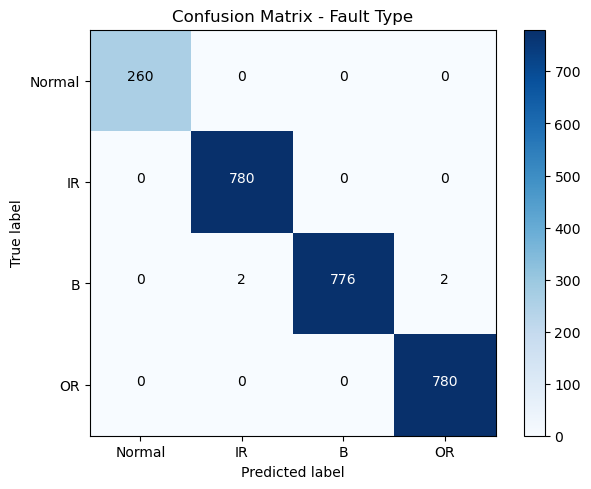

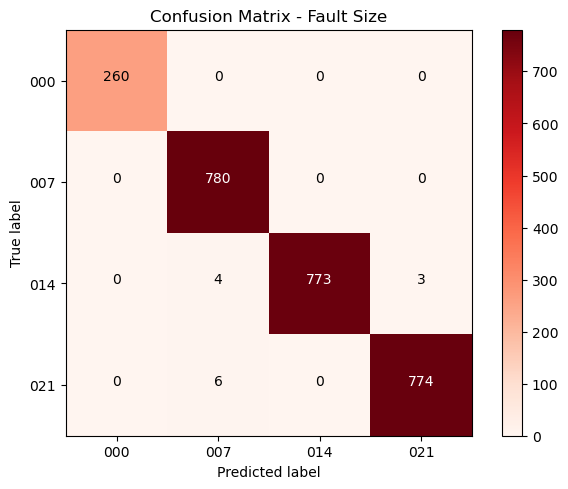

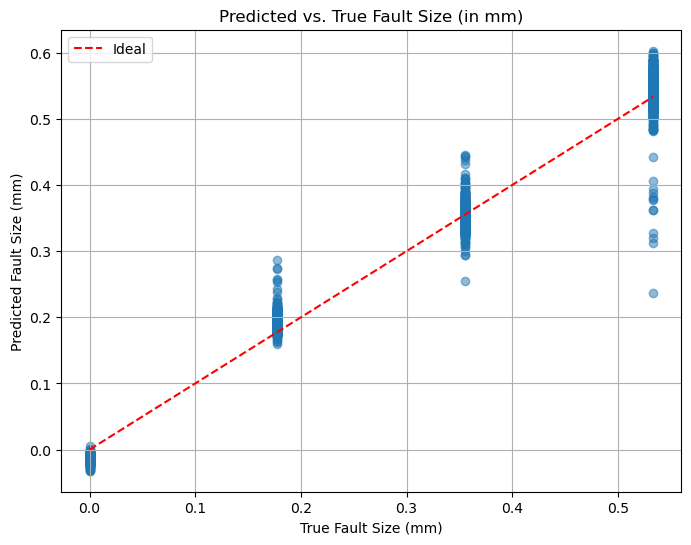


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9985
  ➤ Fault Size Accuracy: 0.9950

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0021
Mean Absolute Error (MAE): 0.0331
R2 Score: 0.9801
Mean Absolute Percentage Error (MAPE): 11909935626372.3848

📂 Model saved to ./output\PyTorch/dict_models\DeepCNN1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DeepCNN1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DeepCNN1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DeepCNN1D_pt_test_results.csv
{'fault_check_acc': 0.9, 'fault_type_acc': 0.9984615384615385, 'fault_size_acc': 0.995, 'fault_size_mse': 0.002124634132224071, 'fault_size_rmse': 0.04609375372243045, 'fault_size_mae': 0.03307266572060493, 'fault_size_r2': 0.9800815548619953, 'fault_size_mape': 11909935626372.385}


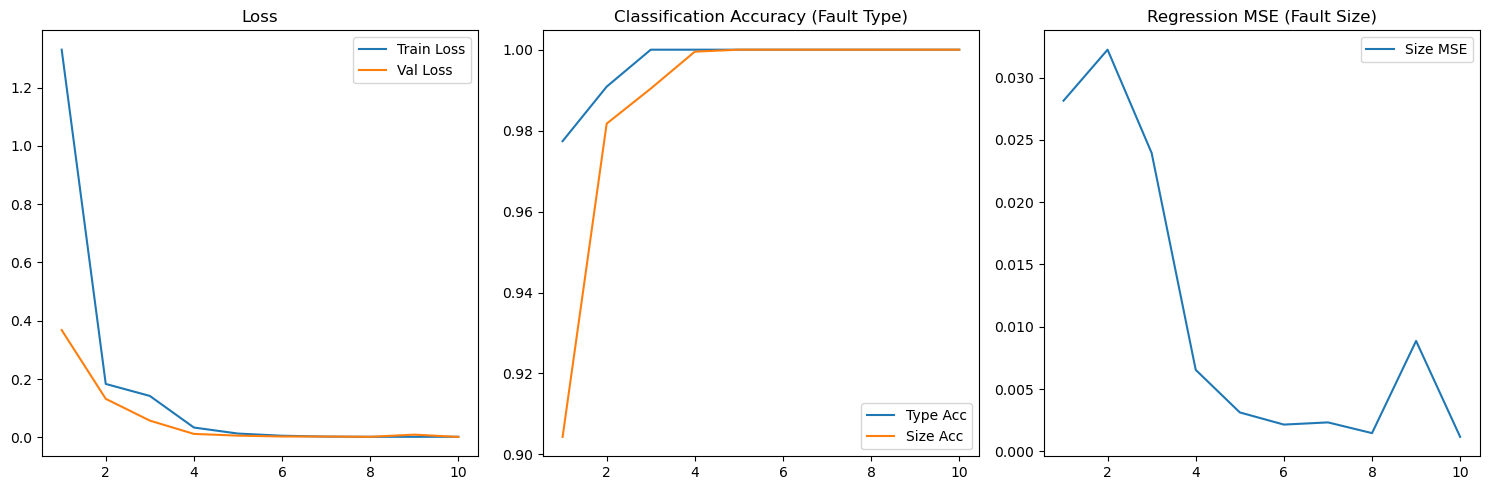

In [24]:
deepcnn_model = DeepCNN1D_pt(input_size=INPUT_DIM).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'DeepCNN1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
deepcnn_history, deepcnn_metrics = train_evaluate_model_pt(
        model=deepcnn_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
print(deepcnn_metrics)
plot_training_results(deepcnn_history)

### **Added From Article (Comparison)**

###  15. MEAT

Validating: 100%|██████████| 33/33 [00:03<00:00, 10.96it/s]



✅ Epoch 1/10 Completed:
Train Loss: 18.5137, Val Loss: 1.7028
Validation - Type Acc: 0.6687, Size: 0.6687, MSE - Size: 0.1175


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.61it/s]



✅ Epoch 2/10 Completed:
Train Loss: 1.6175, Val Loss: 1.3235
Validation - Type Acc: 0.7519, Size: 0.7519, MSE - Size: 0.1090


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.53it/s]



✅ Epoch 3/10 Completed:
Train Loss: 1.3318, Val Loss: 1.1114
Validation - Type Acc: 0.8269, Size: 0.8269, MSE - Size: 0.0995


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.29it/s]



✅ Epoch 4/10 Completed:
Train Loss: 1.0592, Val Loss: 0.8256
Validation - Type Acc: 0.9149, Size: 0.9149, MSE - Size: 0.1143


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.06it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.7947, Val Loss: 0.6317
Validation - Type Acc: 0.9514, Size: 0.9514, MSE - Size: 0.0793


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.35it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.6165, Val Loss: 0.4892
Validation - Type Acc: 0.9736, Size: 0.9736, MSE - Size: 0.0846


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.98it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.5007, Val Loss: 0.3972
Validation - Type Acc: 0.9841, Size: 0.9841, MSE - Size: 0.0655


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.05it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.4162, Val Loss: 0.3946
Validation - Type Acc: 0.9798, Size: 0.9798, MSE - Size: 0.0673


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.05it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.3509, Val Loss: 0.2742
Validation - Type Acc: 0.9885, Size: 0.9885, MSE - Size: 0.0622


Validating: 100%|██████████| 33/33 [00:02<00:00, 11.08it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.3049, Val Loss: 0.2330
Validation - Type Acc: 0.9909, Size: 0.9909, MSE - Size: 0.0614
📊 Evaluating on test set...


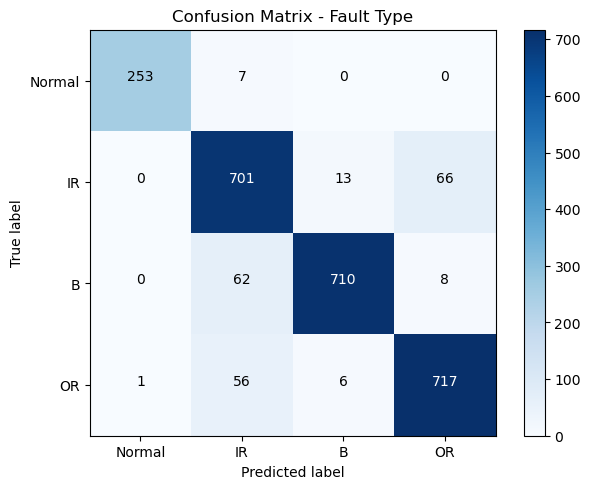

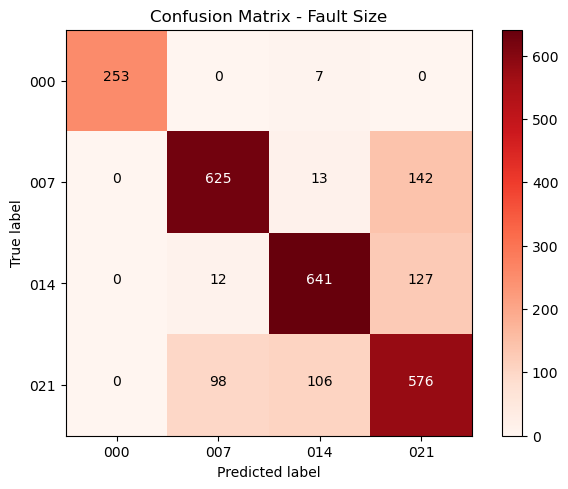

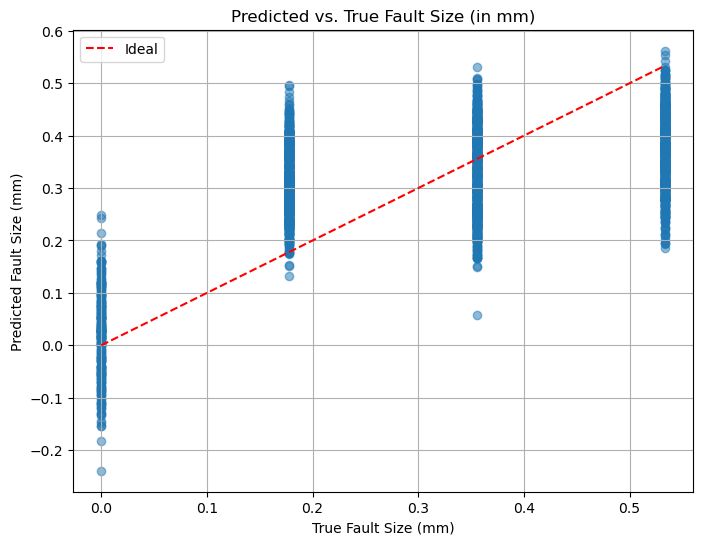


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.2373
  ➤ Fault Type Accuracy: 0.9158
  ➤ Fault Size Accuracy: 0.8058

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0651
Mean Absolute Error (MAE): 0.2178
R2 Score: 0.3900
Mean Absolute Percentage Error (MAPE): 59581159940071.1719

📂 Model saved to ./output\PyTorch/dict_models\MEAT_pt.pth
📂 Model saved to ./output\PyTorch/full_models\MEAT_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\MEAT_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\MEAT_pt_test_results.csv


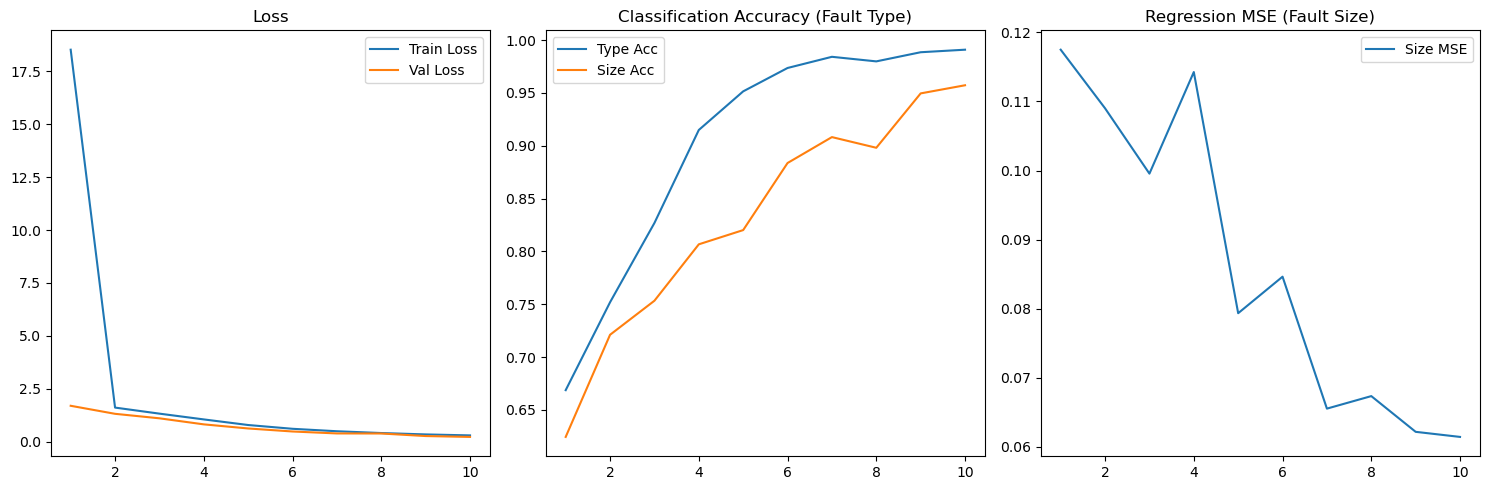

In [25]:
meat_model = MEAT_pt(input_size=INPUT_DIM, num_classes=NUM_CLASSES).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'MEAT_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, BATCH_SIZE
)
meat_history, meat_metrics = train_evaluate_model_pt(
        model=meat_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device
    )
# print(plot_training_results(meat_history)_metrics)
plot_training_results(meat_history)


### **New Novel Method**

###  16. DenseResNet1D - AutoML

Validating: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]



✅ Epoch 1/10 Completed:
Train Loss: 2.2438, Val Loss: 1.1879
Validation - Type Acc: 0.9885, Size: 0.9885, MSE - Size: 0.0312


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.48it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.6871, Val Loss: 0.2097
Validation - Type Acc: 0.9942, Size: 0.9942, MSE - Size: 0.0115


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.45it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.2002, Val Loss: 0.0600
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0121


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0984, Val Loss: 0.0251
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0048


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0667, Val Loss: 0.0214
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0068


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0488, Val Loss: 0.0186
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0091


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.13it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0387, Val Loss: 0.0101
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0048


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0325, Val Loss: 0.0084
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0042


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0281, Val Loss: 0.0089
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0052


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.98it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0265, Val Loss: 0.0086
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0038
📊 Evaluating on test set...


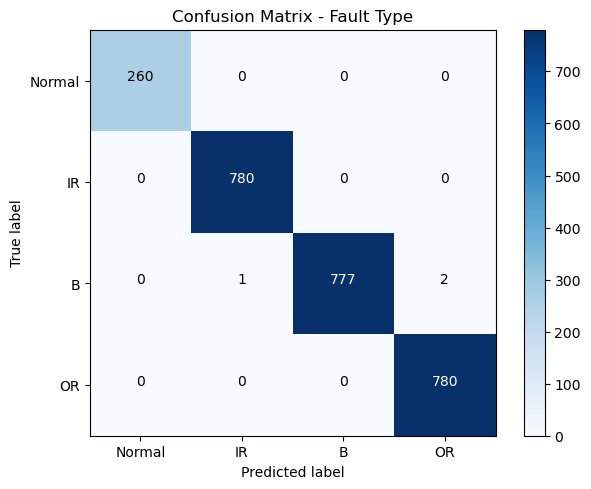

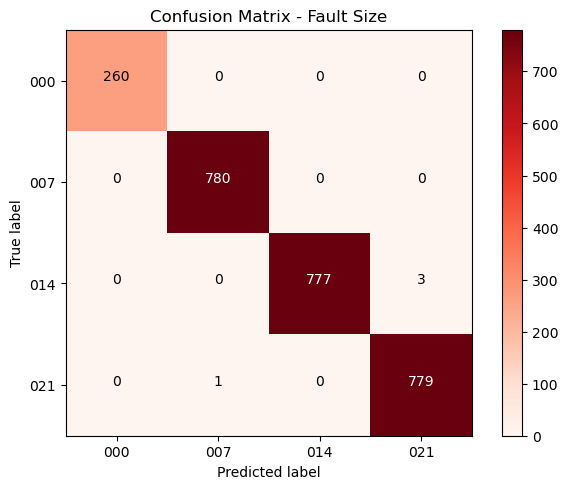

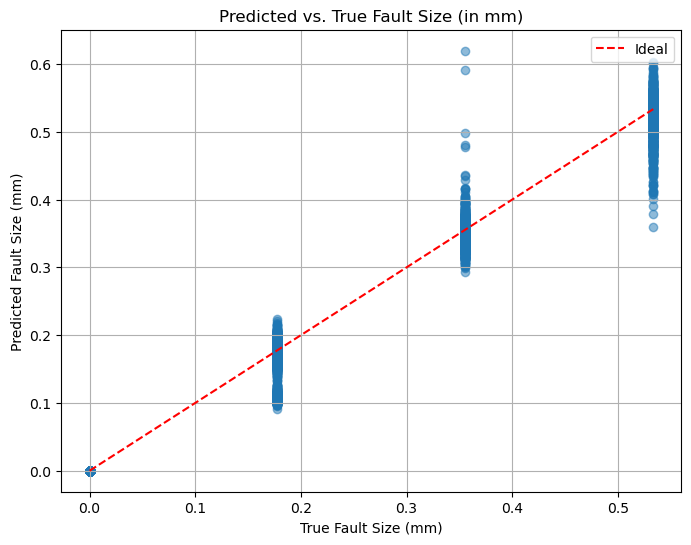


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9988
  ➤ Fault Size Accuracy: 0.9985

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0043
Mean Absolute Error (MAE): 0.0458
R2 Score: 0.9601
Mean Absolute Percentage Error (MAPE): 0.0897

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv


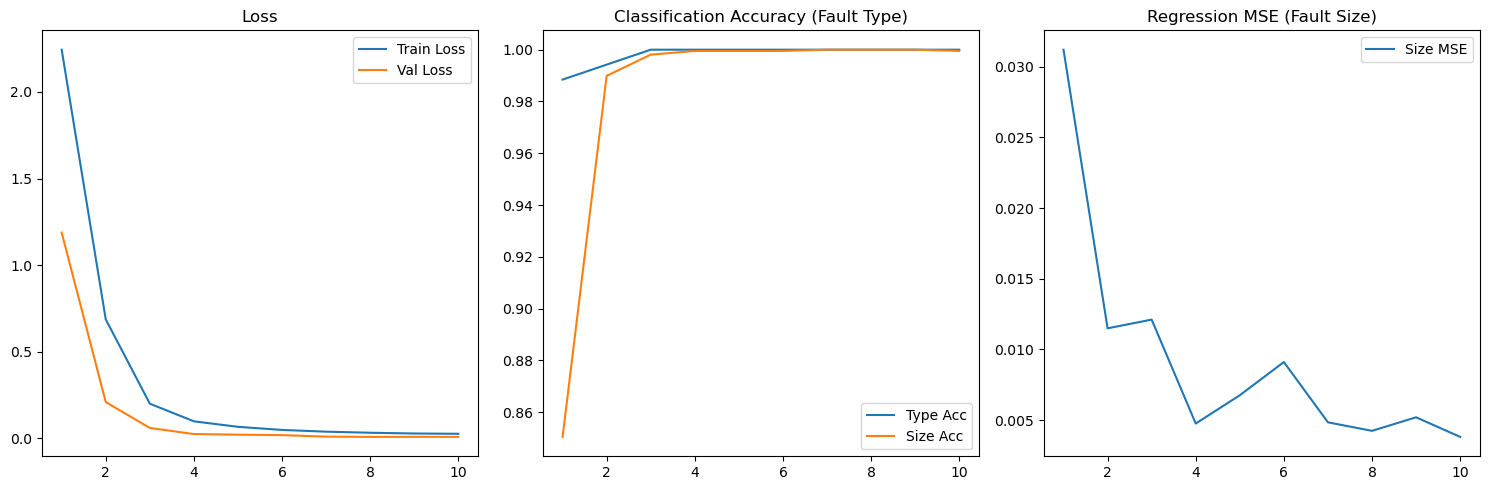

In [26]:
new_batch_size = 128
new_lr = 1e-4

denseresnet_model = DenseResNet1D_pt(input_size=INPUT_DIM, num_classes=NUM_CLASSES).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'DenseResNet1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, new_batch_size
)
denseresnet_history, denseresnet_metrics = train_evaluate_model_pt(
        model=denseresnet_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=new_lr,
        device=device
    )
# print(denseresnet_metrics)
plot_training_results(denseresnet_history)


In [27]:
print(denseresnet_metrics)

{'fault_check_acc': 0.9, 'fault_type_acc': 0.9988461538461538, 'fault_size_acc': 0.9984615384615385, 'fault_size_mse': 0.004257638025858462, 'fault_size_rmse': 0.06525057873964385, 'fault_size_mae': 0.04578684171805015, 'fault_size_r2': 0.9600846432101844, 'fault_size_mape': 0.08970500217474248}


[I 2025-11-19 14:38:37,098] A new study created in memory with name: no-name-69cce2d5-2a30-4af4-a804-ceea45508968
Validating: 100%|██████████| 17/17 [00:03<00:00,  5.17it/s]



✅ Epoch 1/10 Completed:
Train Loss: 0.5916, Val Loss: 0.0197
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0116


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.0428, Val Loss: 0.0104
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0047


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.48it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.0203, Val Loss: 0.0111
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0092


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.06it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0129, Val Loss: 0.0060
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0055


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0087, Val Loss: 0.0037
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0029


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0078, Val Loss: 0.0047
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0041


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0065, Val Loss: 0.0074
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0034


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0256, Val Loss: 0.3560
Validation - Type Acc: 0.9981, Size: 0.9981, MSE - Size: 0.0261


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0421, Val Loss: 0.0056
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0045


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.06it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0075, Val Loss: 0.0013
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0012
📊 Evaluating on test set...


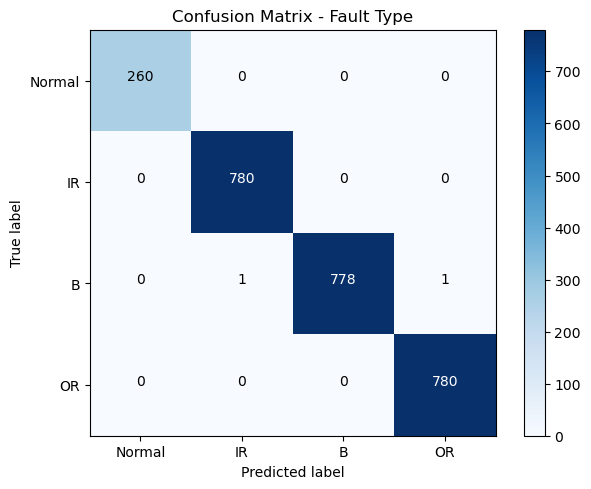

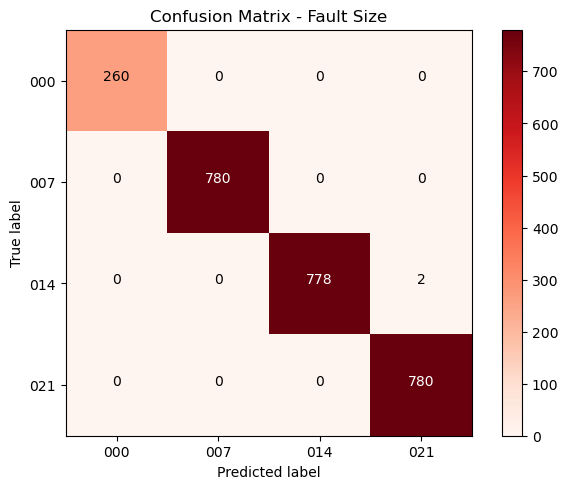

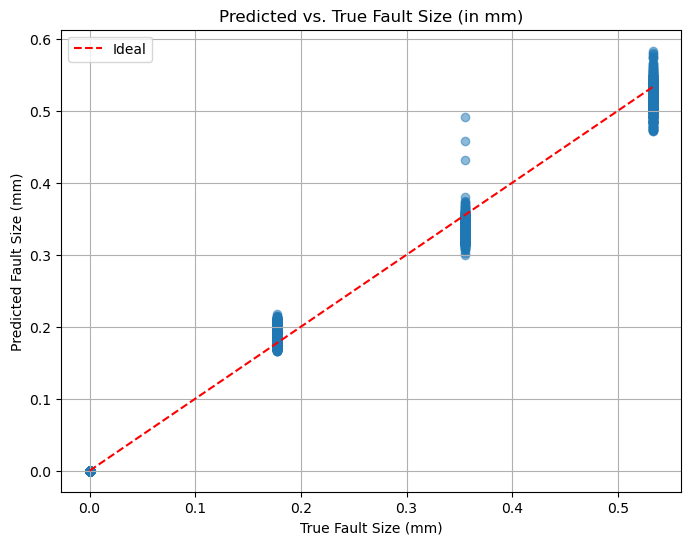

[I 2025-11-19 14:40:39,248] Trial 0 finished with value: 0.0012805968684367925 and parameters: {'batch_size': 128, 'learning_rate': 0.001193729822076992}. Best is trial 0 with value: 0.0012805968684367925.



📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9992
  ➤ Fault Size Accuracy: 0.9992

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0013
Mean Absolute Error (MAE): 0.0269
R2 Score: 0.9880
Mean Absolute Percentage Error (MAPE): 0.0427

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]



✅ Epoch 1/10 Completed:
Train Loss: 2.4274, Val Loss: 1.6805
Validation - Type Acc: 0.8639, Size: 0.8639, MSE - Size: 0.0441


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.06it/s]



✅ Epoch 2/10 Completed:
Train Loss: 1.2910, Val Loss: 0.6930
Validation - Type Acc: 0.9981, Size: 0.9981, MSE - Size: 0.0185


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.02it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.5930, Val Loss: 0.2657
Validation - Type Acc: 0.9986, Size: 0.9986, MSE - Size: 0.0141


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.47it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.3006, Val Loss: 0.1153
Validation - Type Acc: 0.9995, Size: 0.9995, MSE - Size: 0.0083


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.83it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.1729, Val Loss: 0.0573
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0079


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.08it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.1159, Val Loss: 0.0338
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0052


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.89it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0840, Val Loss: 0.0226
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0056


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.12it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0657, Val Loss: 0.0232
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0052


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.03it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0544, Val Loss: 0.0112
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0028


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0461, Val Loss: 0.0112
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0042
📊 Evaluating on test set...


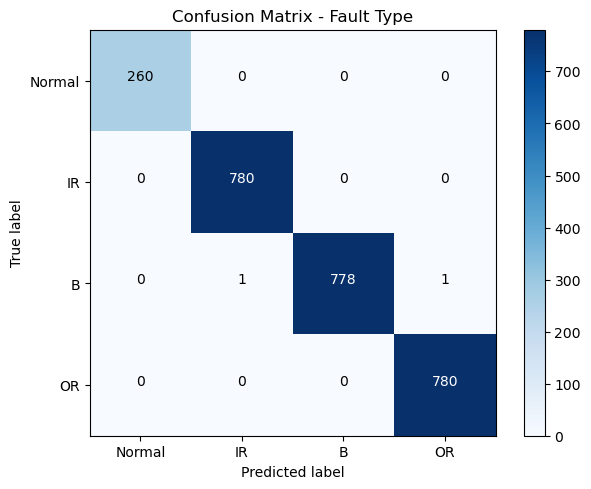

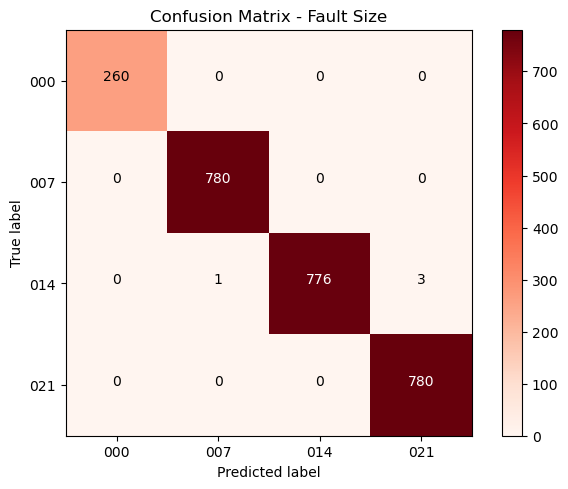

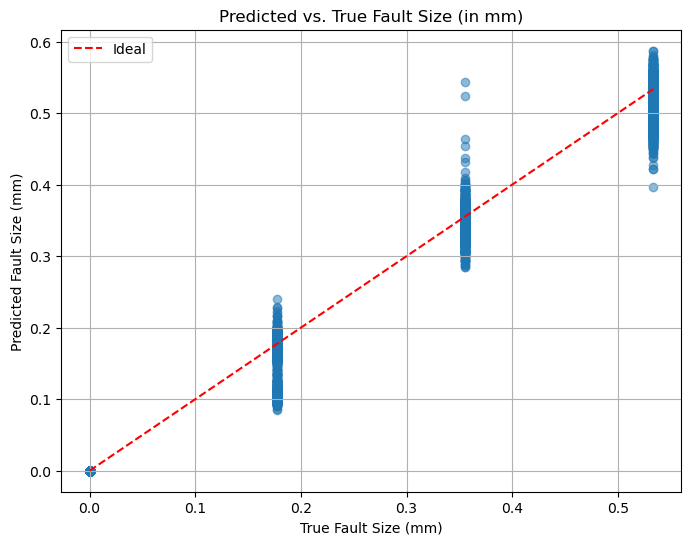


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9992
  ➤ Fault Size Accuracy: 0.9985

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0044
Mean Absolute Error (MAE): 0.0487
R2 Score: 0.9587
Mean Absolute Percentage Error (MAPE): 0.0893

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv


[I 2025-11-19 14:42:45,558] Trial 1 finished with value: 0.0044099475762232635 and parameters: {'batch_size': 128, 'learning_rate': 6.274822109288569e-05}. Best is trial 0 with value: 0.0012805968684367925.
Validating: 100%|██████████| 17/17 [00:03<00:00,  4.98it/s]



✅ Epoch 1/10 Completed:
Train Loss: 0.5502, Val Loss: 0.0719
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0212


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.79it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.0348, Val Loss: 0.0693
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0105


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.88it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.0169, Val Loss: 0.0032
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0024


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.02it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0182, Val Loss: 2.4638
Validation - Type Acc: 0.7793, Size: 0.7793, MSE - Size: 0.0237


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.89it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0182, Val Loss: 0.0042
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0031


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.97it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0184, Val Loss: 0.0170
Validation - Type Acc: 0.9971, Size: 0.9971, MSE - Size: 0.0056


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.92it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0078, Val Loss: 0.0023
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0019


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.99it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0050, Val Loss: 0.0015
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0014


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.90it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0041, Val Loss: 0.0081
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0078


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0036, Val Loss: 0.0072
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0071
📊 Evaluating on test set...


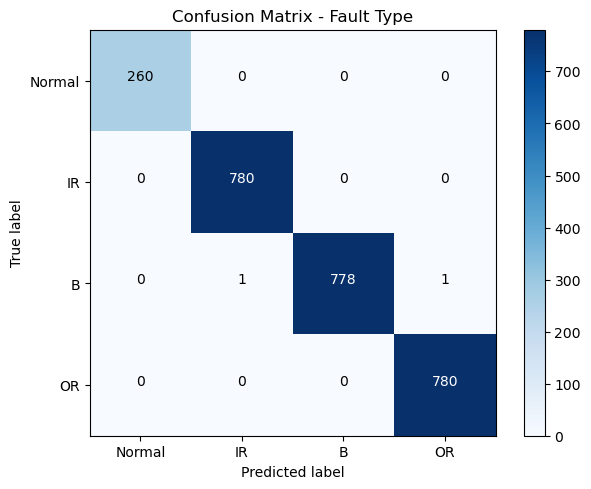

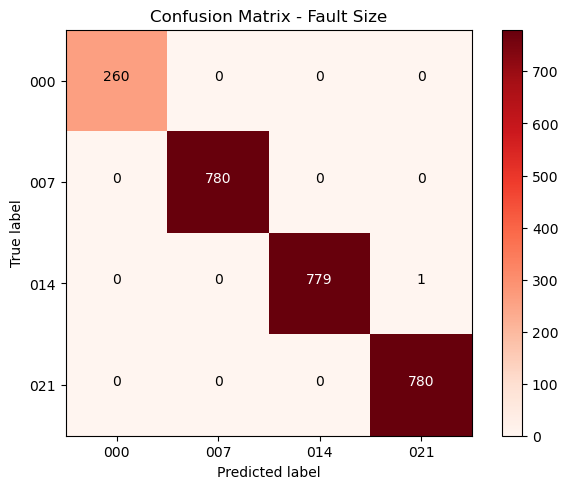

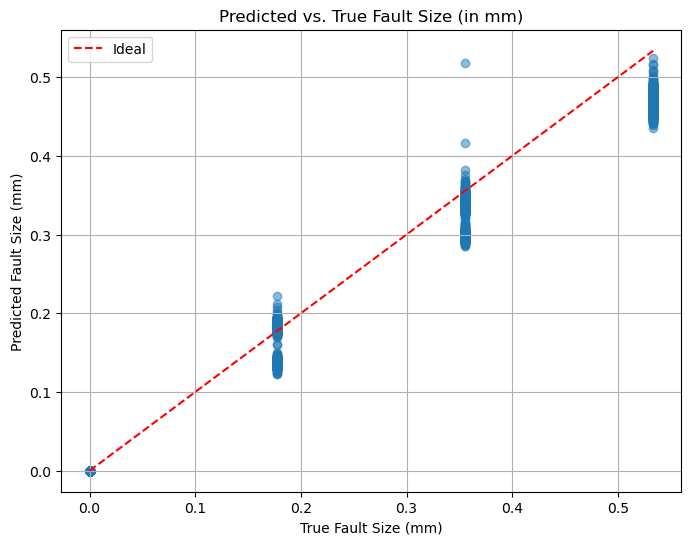

[I 2025-11-19 14:44:52,142] Trial 2 finished with value: 0.006983428636674623 and parameters: {'batch_size': 128, 'learning_rate': 0.0012838766951231287}. Best is trial 0 with value: 0.0012805968684367925.



📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9992
  ➤ Fault Size Accuracy: 0.9996

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0070
Mean Absolute Error (MAE): 0.0645
R2 Score: 0.9345
Mean Absolute Percentage Error (MAPE): 0.0923

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]



✅ Epoch 1/10 Completed:
Train Loss: 3.0120, Val Loss: 2.7948
Validation - Type Acc: 0.6327, Size: 0.6327, MSE - Size: 0.1353


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.06it/s]



✅ Epoch 2/10 Completed:
Train Loss: 2.6809, Val Loss: 2.5015
Validation - Type Acc: 0.6750, Size: 0.6750, MSE - Size: 0.0742


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.79it/s]



✅ Epoch 3/10 Completed:
Train Loss: 2.4193, Val Loss: 2.2197
Validation - Type Acc: 0.8202, Size: 0.8202, MSE - Size: 0.0538


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.94it/s]



✅ Epoch 4/10 Completed:
Train Loss: 2.1426, Val Loss: 1.9089
Validation - Type Acc: 0.8784, Size: 0.8784, MSE - Size: 0.0409


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.06it/s]



✅ Epoch 5/10 Completed:
Train Loss: 1.8582, Val Loss: 1.6127
Validation - Type Acc: 0.9399, Size: 0.9399, MSE - Size: 0.0322


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.12it/s]



✅ Epoch 6/10 Completed:
Train Loss: 1.5892, Val Loss: 1.3324
Validation - Type Acc: 0.9668, Size: 0.9668, MSE - Size: 0.0275


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]



✅ Epoch 7/10 Completed:
Train Loss: 1.3542, Val Loss: 1.1039
Validation - Type Acc: 0.9827, Size: 0.9827, MSE - Size: 0.0223


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.01it/s]



✅ Epoch 8/10 Completed:
Train Loss: 1.1465, Val Loss: 0.8965
Validation - Type Acc: 0.9899, Size: 0.9899, MSE - Size: 0.0196


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.9686, Val Loss: 0.7410
Validation - Type Acc: 0.9938, Size: 0.9938, MSE - Size: 0.0166


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.11it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.8170, Val Loss: 0.5872
Validation - Type Acc: 0.9966, Size: 0.9966, MSE - Size: 0.0136
📊 Evaluating on test set...


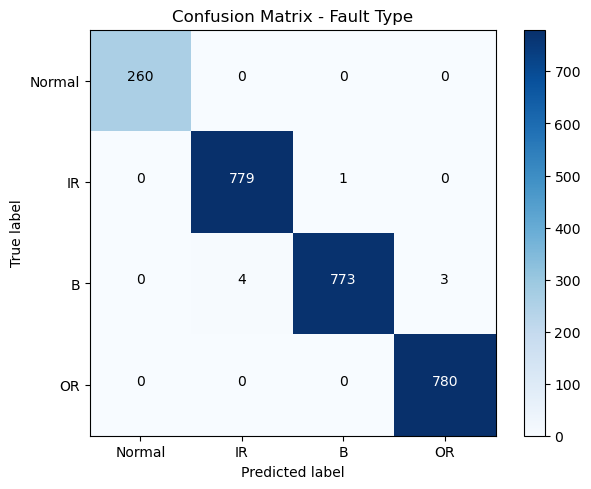

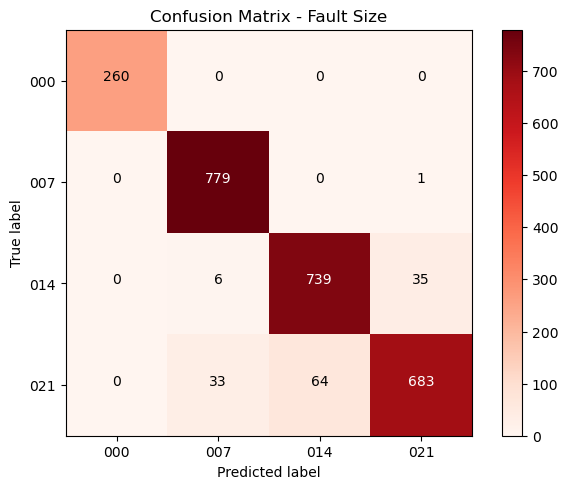

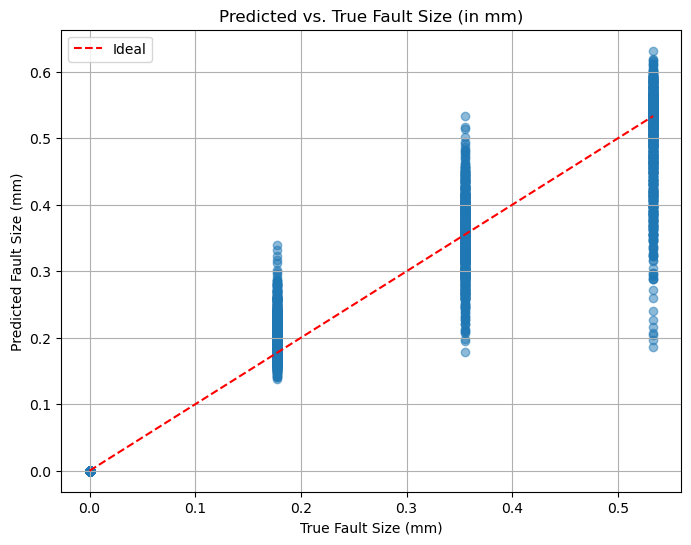

[I 2025-11-19 14:46:56,566] Trial 3 finished with value: 0.01380509467781207 and parameters: {'batch_size': 128, 'learning_rate': 1.0981751708295679e-05}. Best is trial 0 with value: 0.0012805968684367925.



📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9969
  ➤ Fault Size Accuracy: 0.9465

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0138
Mean Absolute Error (MAE): 0.0811
R2 Score: 0.8706
Mean Absolute Percentage Error (MAPE): 0.1301

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.01it/s]



✅ Epoch 1/10 Completed:
Train Loss: 0.6468, Val Loss: 0.0311
Validation - Type Acc: 0.9995, Size: 0.9995, MSE - Size: 0.0205


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.97it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.0365, Val Loss: 0.0285
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0226


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.01it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.0224, Val Loss: 0.0072
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0061


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.96it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0140, Val Loss: 0.0044
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0038


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.06it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0100, Val Loss: 0.0103
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0064


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.19it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0564, Val Loss: 0.0124
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0101


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.76it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0130, Val Loss: 0.0125
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0058


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0083, Val Loss: 0.0032
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0028


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0060, Val Loss: 0.0018
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0016


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.73it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0046, Val Loss: 0.0020
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0018
📊 Evaluating on test set...


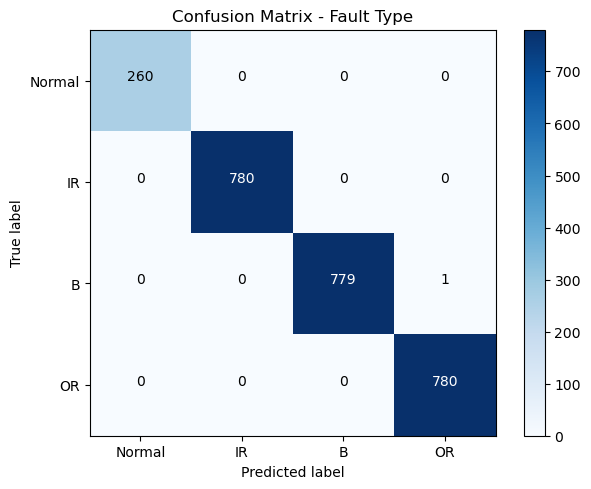

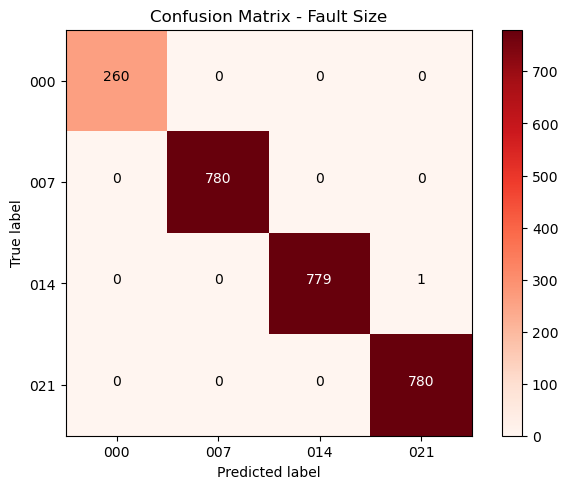

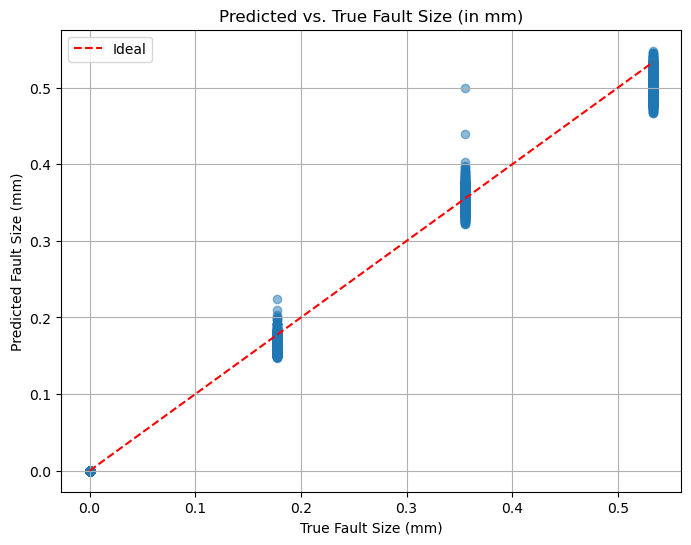

[I 2025-11-19 14:49:02,049] Trial 4 finished with value: 0.001887909574024059 and parameters: {'batch_size': 128, 'learning_rate': 0.001065490462501084}. Best is trial 0 with value: 0.0012805968684367925.



📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9996
  ➤ Fault Size Accuracy: 0.9996

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0019
Mean Absolute Error (MAE): 0.0325
R2 Score: 0.9823
Mean Absolute Percentage Error (MAPE): 0.0510

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.71it/s]



✅ Epoch 1/10 Completed:
Train Loss: 1.0076, Val Loss: 0.0984
Validation - Type Acc: 0.9990, Size: 0.9990, MSE - Size: 0.0136


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.69it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.0945, Val Loss: 0.0187
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0098


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.86it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.0481, Val Loss: 0.0118
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0087


Validating: 100%|██████████| 33/33 [00:03<00:00,  8.98it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0289, Val Loss: 0.0129
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0102


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.06it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0245, Val Loss: 0.0110
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0086


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.30it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0168, Val Loss: 0.0050
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0025


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.23it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0140, Val Loss: 0.0042
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0038


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.25it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0114, Val Loss: 0.0036
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0031


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.39it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0098, Val Loss: 0.0071
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0043


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.13it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0118, Val Loss: 0.0048
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0045
📊 Evaluating on test set...


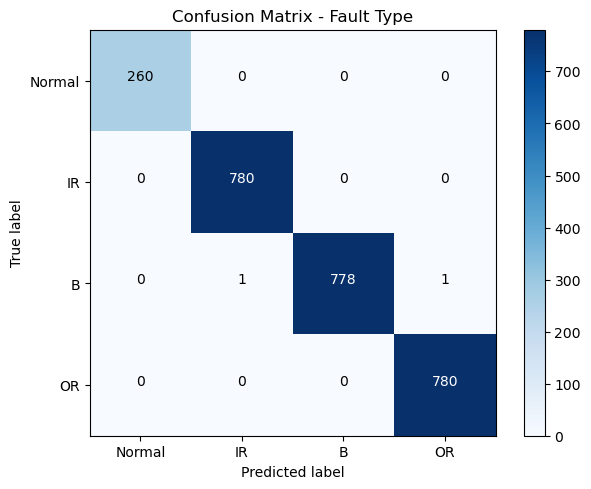

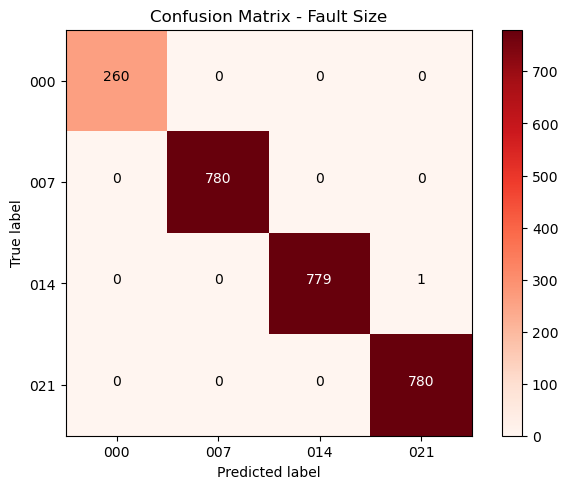

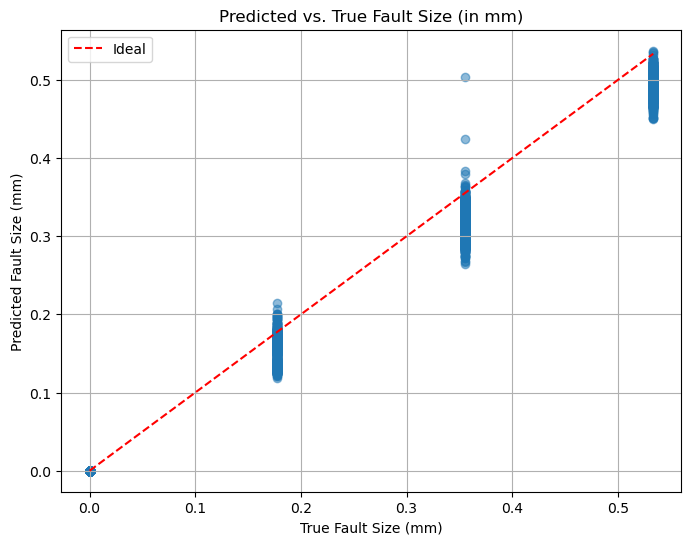

[I 2025-11-19 14:51:11,385] Trial 5 finished with value: 0.004719869462474735 and parameters: {'batch_size': 64, 'learning_rate': 0.00020618271797284972}. Best is trial 0 with value: 0.0012805968684367925.



📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9992
  ➤ Fault Size Accuracy: 0.9996

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0047
Mean Absolute Error (MAE): 0.0572
R2 Score: 0.9558
Mean Absolute Percentage Error (MAPE): 0.0954

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.14it/s]



✅ Epoch 1/10 Completed:
Train Loss: 2.6951, Val Loss: 2.3092
Validation - Type Acc: 0.8106, Size: 0.8106, MSE - Size: 0.0516


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.03it/s]



✅ Epoch 2/10 Completed:
Train Loss: 2.0922, Val Loss: 1.7179
Validation - Type Acc: 0.8933, Size: 0.8933, MSE - Size: 0.0333


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.01it/s]



✅ Epoch 3/10 Completed:
Train Loss: 1.5320, Val Loss: 1.1455
Validation - Type Acc: 0.9764, Size: 0.9764, MSE - Size: 0.0241


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]



✅ Epoch 4/10 Completed:
Train Loss: 1.0580, Val Loss: 0.7300
Validation - Type Acc: 0.9885, Size: 0.9885, MSE - Size: 0.0232


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.96it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.7343, Val Loss: 0.4863
Validation - Type Acc: 0.9894, Size: 0.9894, MSE - Size: 0.0269


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.42it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.5248, Val Loss: 0.3209
Validation - Type Acc: 0.9942, Size: 0.9942, MSE - Size: 0.0183


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.3908, Val Loss: 0.2264
Validation - Type Acc: 0.9976, Size: 0.9976, MSE - Size: 0.0160


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.90it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.2949, Val Loss: 0.1517
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0120


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.2235, Val Loss: 0.1110
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0167


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.1822, Val Loss: 0.0791
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0137
📊 Evaluating on test set...


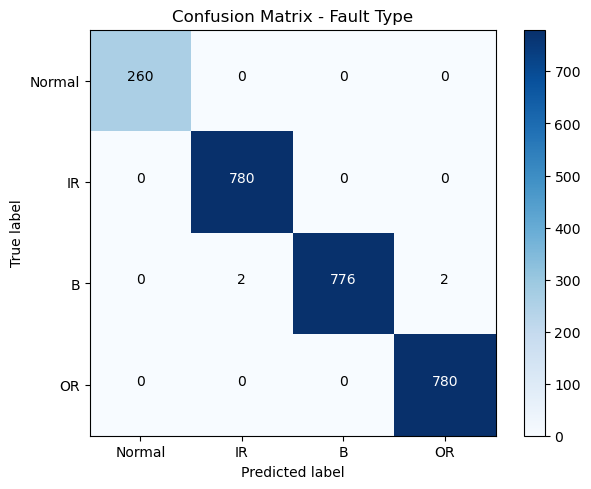

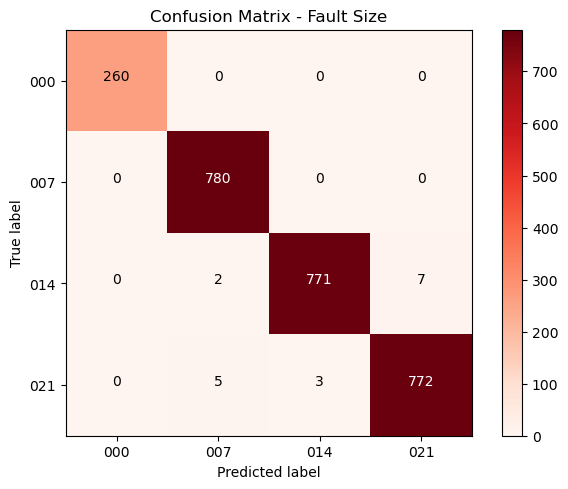

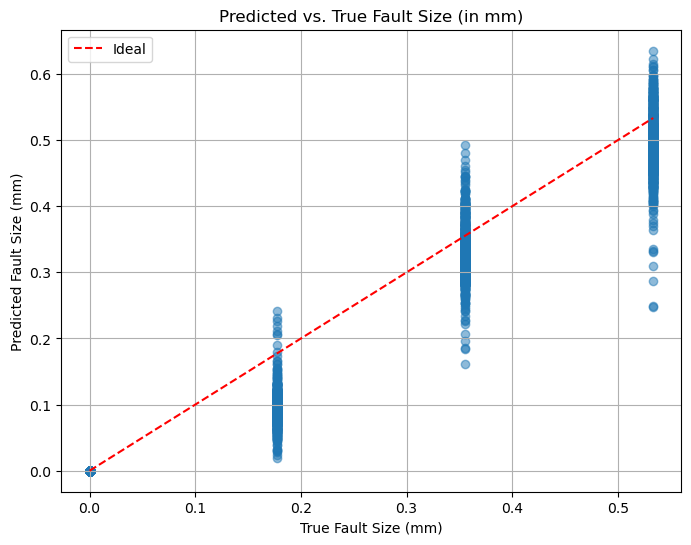

[I 2025-11-19 14:53:14,678] Trial 6 finished with value: 0.014017639990375022 and parameters: {'batch_size': 128, 'learning_rate': 2.5661117355747323e-05}. Best is trial 0 with value: 0.0012805968684367925.



📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9985
  ➤ Fault Size Accuracy: 0.9935

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0140
Mean Absolute Error (MAE): 0.0967
R2 Score: 0.8686
Mean Absolute Percentage Error (MAPE): 0.1995

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.56it/s]



✅ Epoch 1/10 Completed:
Train Loss: 0.3274, Val Loss: 0.0365
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0263


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.26it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.0399, Val Loss: 0.0118
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0061


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.85it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.0311, Val Loss: 0.0230
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0218


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.03it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0084, Val Loss: 0.0087
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0085


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.31it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0893, Val Loss: 0.0088
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0068


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.56it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0127, Val Loss: 0.0051
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0040


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.32it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0157, Val Loss: 0.0036
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0020


Validating: 100%|██████████| 33/33 [00:03<00:00, 10.22it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0047, Val Loss: 0.0019
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0015


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.87it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0044, Val Loss: 0.0042
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0030


Validating: 100%|██████████| 33/33 [00:03<00:00,  9.90it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0043, Val Loss: 0.0038
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0036
📊 Evaluating on test set...


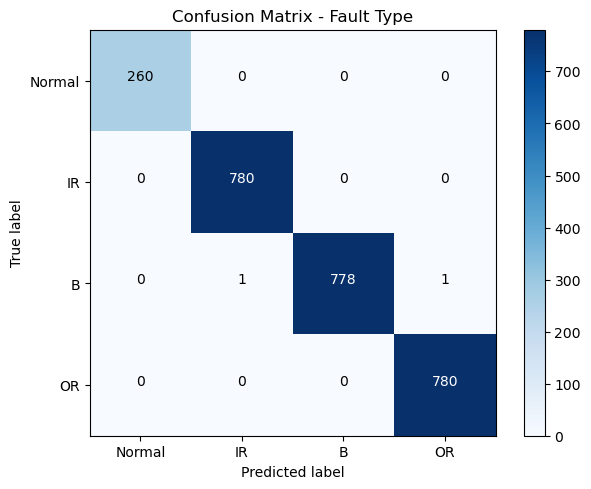

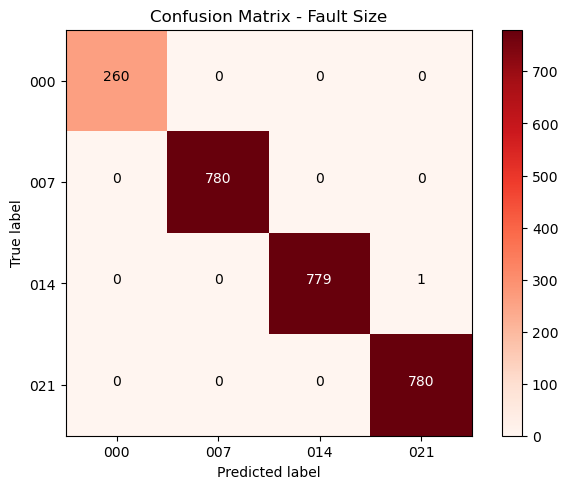

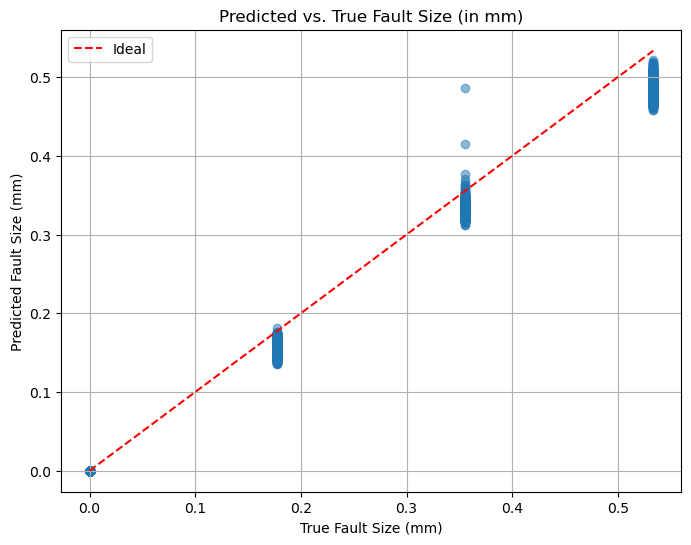

[I 2025-11-19 14:55:24,706] Trial 7 finished with value: 0.0036423631260767307 and parameters: {'batch_size': 64, 'learning_rate': 0.0017940262936967976}. Best is trial 0 with value: 0.0012805968684367925.



📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9992
  ➤ Fault Size Accuracy: 0.9996

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0036
Mean Absolute Error (MAE): 0.0500
R2 Score: 0.9659
Mean Absolute Percentage Error (MAPE): 0.0768

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.18it/s]



✅ Epoch 1/10 Completed:
Train Loss: 3.1181, Val Loss: 2.9588
Validation - Type Acc: 0.5966, Size: 0.5966, MSE - Size: 0.4667


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]



✅ Epoch 2/10 Completed:
Train Loss: 2.8415, Val Loss: 2.6284
Validation - Type Acc: 0.8760, Size: 0.8760, MSE - Size: 0.4667


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.04it/s]



✅ Epoch 3/10 Completed:
Train Loss: 2.4975, Val Loss: 2.2392
Validation - Type Acc: 0.9375, Size: 0.9375, MSE - Size: 0.4667


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]



✅ Epoch 4/10 Completed:
Train Loss: 2.1504, Val Loss: 1.8953
Validation - Type Acc: 0.9726, Size: 0.9726, MSE - Size: 0.4667


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]



✅ Epoch 5/10 Completed:
Train Loss: 1.7813, Val Loss: 1.2921
Validation - Type Acc: 0.9827, Size: 0.9827, MSE - Size: 0.1347


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.78it/s]



✅ Epoch 6/10 Completed:
Train Loss: 1.2785, Val Loss: 1.0001
Validation - Type Acc: 0.9865, Size: 0.9865, MSE - Size: 0.0345


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.12it/s]



✅ Epoch 7/10 Completed:
Train Loss: 1.0566, Val Loss: 0.8265
Validation - Type Acc: 0.9938, Size: 0.9938, MSE - Size: 0.0251


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.09it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.8972, Val Loss: 0.6698
Validation - Type Acc: 0.9938, Size: 0.9938, MSE - Size: 0.0215


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.16it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.7581, Val Loss: 0.5479
Validation - Type Acc: 0.9966, Size: 0.9966, MSE - Size: 0.0185


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.04it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.6469, Val Loss: 0.4508
Validation - Type Acc: 0.9976, Size: 0.9976, MSE - Size: 0.0152
📊 Evaluating on test set...


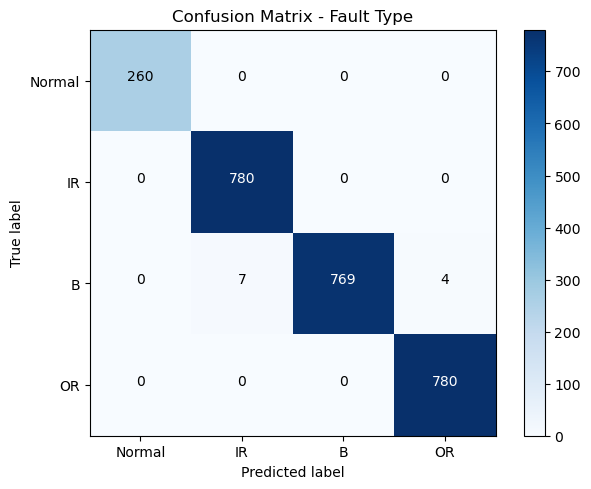

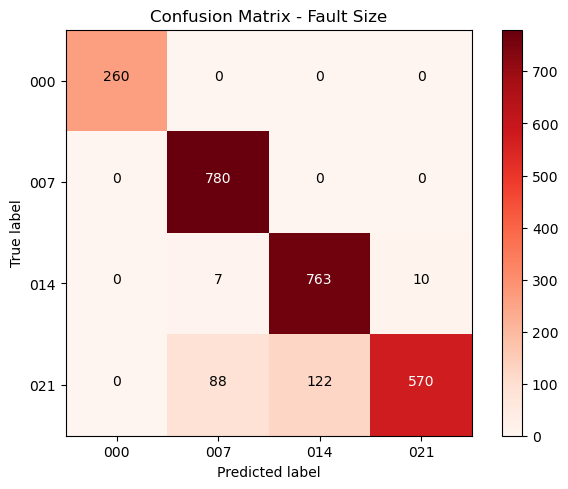

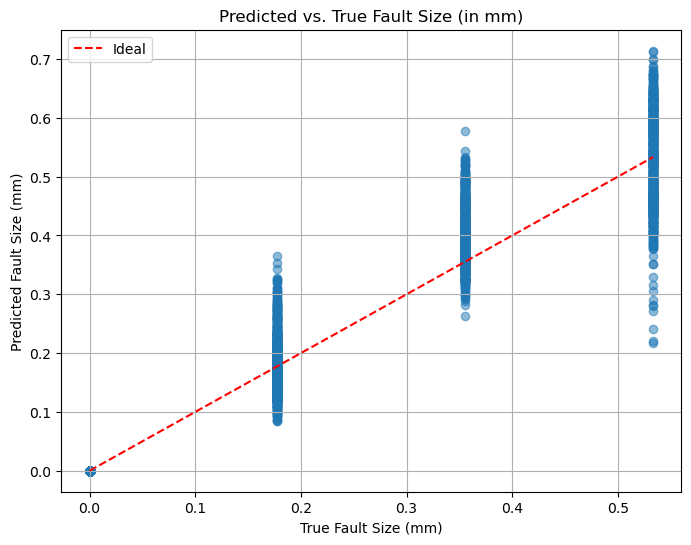

[I 2025-11-19 14:57:28,761] Trial 8 finished with value: 0.014825586551314733 and parameters: {'batch_size': 128, 'learning_rate': 1.1813503599060348e-05}. Best is trial 0 with value: 0.0012805968684367925.



📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9958
  ➤ Fault Size Accuracy: 0.9127

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0148
Mean Absolute Error (MAE): 0.0919
R2 Score: 0.8610
Mean Absolute Percentage Error (MAPE): 0.1514

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.18it/s]



✅ Epoch 1/10 Completed:
Train Loss: 2.9653, Val Loss: 2.6535
Validation - Type Acc: 0.5591, Size: 0.5591, MSE - Size: 0.1044


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.01it/s]



✅ Epoch 2/10 Completed:
Train Loss: 2.4951, Val Loss: 2.2310
Validation - Type Acc: 0.8058, Size: 0.8058, MSE - Size: 0.0554


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.10it/s]



✅ Epoch 3/10 Completed:
Train Loss: 2.1356, Val Loss: 1.8760
Validation - Type Acc: 0.8635, Size: 0.8635, MSE - Size: 0.0441


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.57it/s]



✅ Epoch 4/10 Completed:
Train Loss: 1.8290, Val Loss: 1.5863
Validation - Type Acc: 0.8971, Size: 0.8971, MSE - Size: 0.0398


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.86it/s]



✅ Epoch 5/10 Completed:
Train Loss: 1.5742, Val Loss: 1.3424
Validation - Type Acc: 0.9543, Size: 0.9543, MSE - Size: 0.0369


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]



✅ Epoch 6/10 Completed:
Train Loss: 1.3490, Val Loss: 1.1199
Validation - Type Acc: 0.9865, Size: 0.9865, MSE - Size: 0.0316


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.03it/s]



✅ Epoch 7/10 Completed:
Train Loss: 1.1429, Val Loss: 0.9200
Validation - Type Acc: 0.9947, Size: 0.9947, MSE - Size: 0.0243


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.08it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.9514, Val Loss: 0.7195
Validation - Type Acc: 0.9957, Size: 0.9957, MSE - Size: 0.0180


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.94it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.7866, Val Loss: 0.5764
Validation - Type Acc: 0.9957, Size: 0.9957, MSE - Size: 0.0140


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.6449, Val Loss: 0.4477
Validation - Type Acc: 0.9966, Size: 0.9966, MSE - Size: 0.0121
📊 Evaluating on test set...


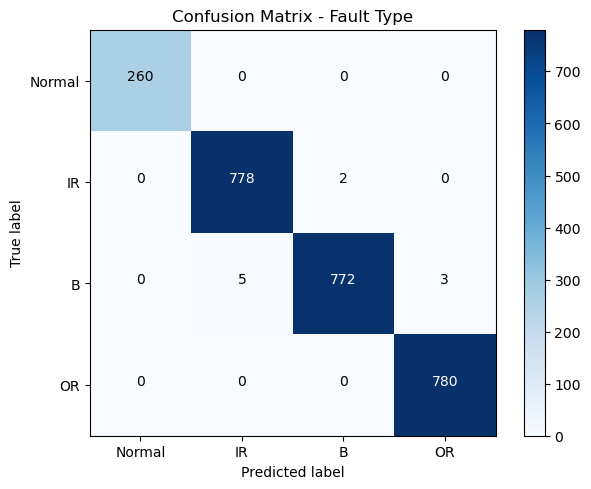

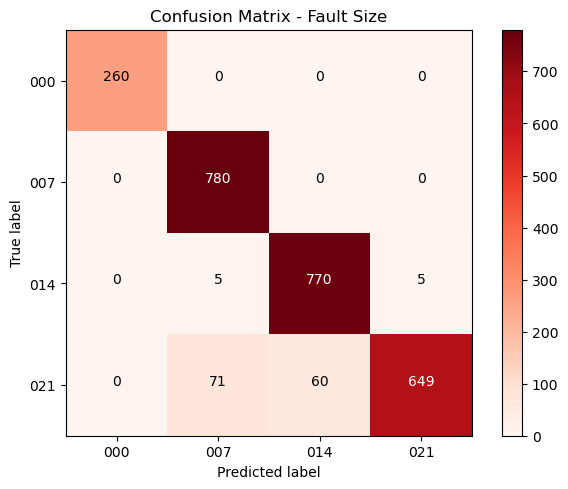

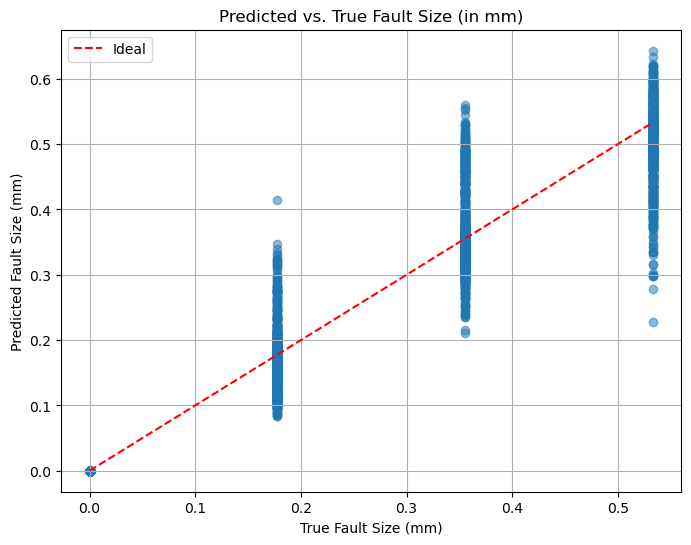

[I 2025-11-19 14:59:34,351] Trial 9 finished with value: 0.01298272007505565 and parameters: {'batch_size': 128, 'learning_rate': 1.4193904438596727e-05}. Best is trial 0 with value: 0.0012805968684367925.



📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 0.9962
  ➤ Fault Size Accuracy: 0.9458

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0130
Mean Absolute Error (MAE): 0.0815
R2 Score: 0.8783
Mean Absolute Percentage Error (MAPE): 0.1404

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv
Best trial: {'batch_size': 128, 'learning_rate': 0.001193729822076992}
Best validation accuracy: 0.0012805968684367925


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]



✅ Epoch 1/10 Completed:
Train Loss: 0.5239, Val Loss: 0.0765
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0427


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.18it/s]



✅ Epoch 2/10 Completed:
Train Loss: 0.0343, Val Loss: 0.0184
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0170


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]



✅ Epoch 3/10 Completed:
Train Loss: 0.0178, Val Loss: 0.0042
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0030


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.12it/s]



✅ Epoch 4/10 Completed:
Train Loss: 0.0121, Val Loss: 0.0066
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0055


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.68it/s]



✅ Epoch 5/10 Completed:
Train Loss: 0.0138, Val Loss: 0.0077
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0073


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.15it/s]



✅ Epoch 6/10 Completed:
Train Loss: 0.0109, Val Loss: 0.0139
Validation - Type Acc: 0.9995, Size: 0.9995, MSE - Size: 0.0084


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]



✅ Epoch 7/10 Completed:
Train Loss: 0.0126, Val Loss: 0.0058
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0051


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.08it/s]



✅ Epoch 8/10 Completed:
Train Loss: 0.0047, Val Loss: 0.0017
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0015


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.11it/s]



✅ Epoch 9/10 Completed:
Train Loss: 0.0037, Val Loss: 0.0025
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0024


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.97it/s]



✅ Epoch 10/10 Completed:
Train Loss: 0.0044, Val Loss: 0.0045
Validation - Type Acc: 1.0000, Size: 1.0000, MSE - Size: 0.0044
📊 Evaluating on test set...


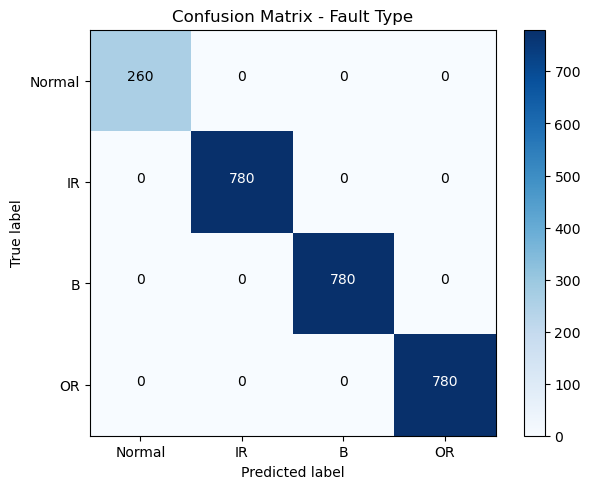

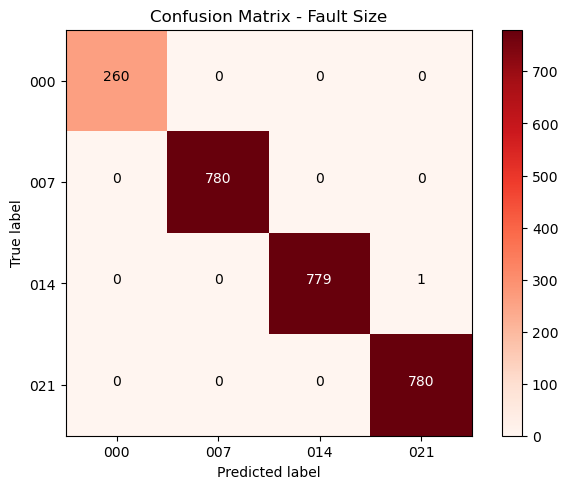

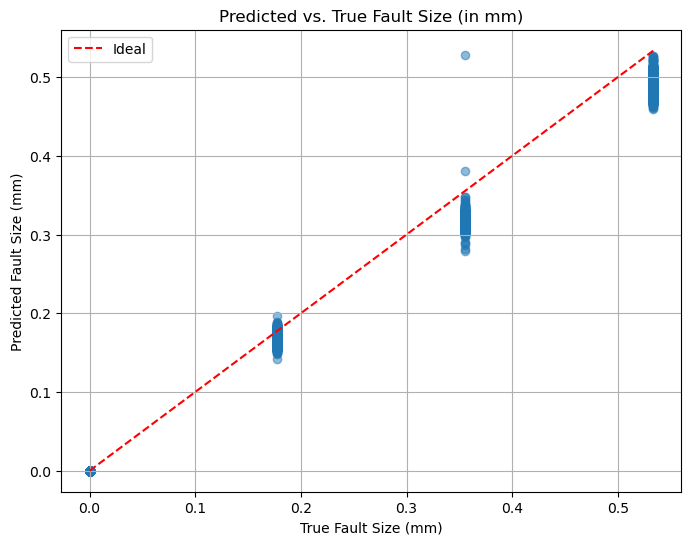


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9000
  ➤ Fault Type Accuracy: 1.0000
  ➤ Fault Size Accuracy: 0.9996

📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0044
Mean Absolute Error (MAE): 0.0553
R2 Score: 0.9584
Mean Absolute Percentage Error (MAPE): 0.0799

📂 Model saved to ./output\PyTorch/dict_models\DenseResNet1D_pt.pth
📂 Model saved to ./output\PyTorch/full_models\DenseResNet1D_pt.pt

📄 Training/Validation history saved to ./output\PyTorch/metrics\DenseResNet1D_pt_train_val_history.csv
📄 Test results saved to ./output\PyTorch/metrics\DenseResNet1D_pt_test_results.csv
Best Model Evaluation Metrics: {'fault_check_acc': 0.9, 'fault_type_acc': 1.0, 'fault_size_acc': 0.9996153846153846, 'fault_size_mse': 0.00443528189330255, 'fault_size_rmse': 0.06659791207915268, 'fault_size_mae': 0.055289483586182964, 'fault_size_r2': 0.9584192319404877, 'fault_size_mape': 0.07989990217417145}


In [28]:
import optuna
import torch
from torch.utils.data import DataLoader

# Define the objective function for optimization
def objective(trial):
    # Updated hyperparameter suggestions
    batch_size = trial.suggest_categorical('batch_size', [64, 128])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)  # Log-scale LR

    # Initialize model
    denseresnet_model = DenseResNet1D_pt(input_size=INPUT_DIM, num_classes=NUM_CLASSES).to(device)

    # Load data with current trial's batch size
    train_loader, val_loader, test_loader = generate_dataloaders_pt(
        'DenseResNet1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, batch_size
    )

    # Train and evaluate
    _, denseresnet_metrics = train_evaluate_model_pt(
        model=denseresnet_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS,
        learning_rate=learning_rate,
        device=device
    )

    # Objective: minimize fault size MSE (or use val_loss for minimization)
    return denseresnet_metrics['fault_size_mse']

# Define the study for optimization (mionimize MSE, MAPE, MAE)
study = optuna.create_study(direction='minimize')  # Or 'minimize' if you want to minimize loss
study.optimize(objective, n_trials=10)  # Number of trials to run

# Print the best trial's hyperparameters and results
print(f"Best trial: {study.best_trial.params}")
print(f"Best validation accuracy: {study.best_trial.value}")

# Optionally, you can save the best model with the best hyperparameters
best_trial_params = study.best_trial.params
best_batch_size = best_trial_params['batch_size']
best_lr = best_trial_params['learning_rate']

# Retrain the model with the best hyperparameters
best_model = DenseResNet1D_pt(input_size=INPUT_DIM, num_classes=NUM_CLASSES).to(device)
best_train_loader, best_val_loader, best_test_loader = generate_dataloaders_pt(
    'DenseResNet1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, best_batch_size
)

best_history, best_metrics = train_evaluate_model_pt(
    model=best_model,
    train_loader=best_train_loader,
    val_loader=best_val_loader,
    test_loader=best_test_loader,
    epochs=EPOCHS,
    learning_rate=best_lr,
    device=device
)

print(f"Best Model Evaluation Metrics: {best_metrics}")


### **Summary**

In [29]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.palettes import Category10, Category20
from bokeh.layouts import layout
from bokeh.transform import dodge
from itertools import cycle
import copy

def plot_training_time_bar(pt_histories):
    model_names = []
    train_times = []

    for model_name, history in pt_histories.items():
        if 'train_time' in history:
            # print(f"{model_name} has train_time:", history['train_time'])  # Debug print
            model_names.append(model_name)
            train_times.append(history['train_time'][0] if isinstance(history['train_time'], list) else history['train_time'])
        else:
            print(f"{model_name} has no train_time.")  # Debug print

    if not model_names:
        print("No models have valid 'train_time'.")
        return

    # Sorting and plotting (safe now)
    sorted_data = sorted(zip(train_times, model_names), reverse=True)
    train_times, model_names = zip(*sorted_data)

    from itertools import cycle
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.models import ColumnDataSource
    from bokeh.palettes import Category20

    colors = cycle(Category20[20])
    color_list = [next(colors) for _ in model_names]

    source = ColumnDataSource(data=dict(
        models=model_names,
        times=train_times,
        color=color_list
    ))

    p = figure(
        y_range=list(model_names),
        x_axis_label='Training Time (s)',
        title='Training Time per Model',
        width=800,
        height=30 * len(model_names) + 100,
        tools="pan,box_zoom,reset,save"
    )

    p.hbar(
        y='models', right='times', height=0.6,
        source=source, color='color'
    )

    p.ygrid.grid_line_color = None
    p.x_range.start = 0

    output_notebook()
    show(p)


def plot_final_metrics_bar(pt_histories, metric_names):
    """
    Plots the final (last epoch) values of specified metrics for multiple models.

    Args:
        pt_histories (dict): Dictionary of model histories.
        metric_names (list): List of metric names to plot (e.g., ['val_type_acc', 'val_size_r2']).
    """
    model_names = []
    metric_values = {metric: [] for metric in metric_names}  # Store values for each metric

    for model_name, history in pt_histories.items():
        model_names.append(model_name)
        for metric in metric_names:
            if metric in history and history[metric]:  # Check if metric exists and has values
                metric_values[metric].append(history[metric][-1])  # Get the last value
            else:
                metric_values[metric].append(0)  # Handle missing metric or empty list

    # Create ColumnDataSource with model names, metric values, and colors
    data = {'models': model_names}
    data.update(metric_values)  # Add metric values to the data dictionary
    data['color'] = Category20[len(model_names)]
    source = ColumnDataSource(data=data)

    # Create figure
    p = figure(
        y_range=model_names,
        x_axis_label='Metric Value',
        title=f'Final Values of {", ".join(metric_names)}',
        width=800,
        height=30 * len(model_names) + 100,
        tools="pan,box_zoom,reset,save"
    )

    # Plot bars for each metric
    for i, metric in enumerate(metric_names):
        p.hbar(
            y='models', right=metric, height=0.6,
            source=source, color='color', legend_label=metric
        )
        p.legend.location = "top_right"

    p.ygrid.grid_line_color = None
    p.x_range.start = 0

    output_notebook() 
    show(p)

def plot_model_history(history_list, model_names):
    p = figure(title='Model Loss Comparison', x_axis_label='Epoch', y_axis_label='Loss', width=800, height=400)
    legend_items = []  # Store legend items
    colors = Category10[10]  # Get 10 colors from Category10 palette

    for i, history in enumerate(history_list):
        # ❌ Remove or comment out these lines:
        # if 'train_time' in history:
        #    history['train_time'] = [history['train_time']]

        # Ensure all columns have the same length (e.g., using epoch length)
        epoch_len = len(history['epoch'])  # Or any other key with epoch length
        for key in history:
            if len(history[key]) == 1 and key != 'epoch':  # Assuming single values need to be extended
                history[key] = history[key] * epoch_len
            # Special case: 'epoch' should remain sequential values
            if key == 'epoch':
                history[key] = list(range(1, epoch_len + 1))


        # Create ColumnDataSource
        source = ColumnDataSource(data=history)

        # Plot train loss
        train_line = p.line(x='epoch', y='train_loss', source=source, color=colors[i % len(colors)], line_width=2)  # Use color from palette
        legend_items.append((f"{model_names[i]} - Train Loss", [train_line]))

        # Plot validation loss
        val_line = p.line(x='epoch', y='val_loss', source=source, color=colors[i % len(colors)], line_width=2, line_dash='dashed')  # Use color from palette
        legend_items.append((f"{model_names[i]} - Validation Loss", [val_line]))

    # Add legend
    legend = Legend(items=legend_items, location='top_right')
    p.add_layout(legend, 'right')
    p.legend.click_policy = "hide"  # Allow clicking on legend to hide/show lines
    
    output_notebook() 
    show(p)

def plot_model_metric(history_list, model_names, metric_name):
    """
    Plots a specified metric for multiple models using Bokeh.

    Args:
        history_list (list): List of history dictionaries for each model.
        model_names (list): List of model names.
        metric_name (str): The name of the metric to plot (e.g., 'train_loss', 'val_size_r2', 'val_type_acc').
    """

    # Determine title and y-axis label based on metric name
    if metric_name == 'train_loss' or metric_name == 'val_loss':
        title = 'Model Loss Comparison'
        y_label = 'Loss'
    elif metric_name == 'val_size_r2':
        title = 'Model R² Comparison'
        y_label = 'R²'
    elif metric_name == 'val_type_acc':
        title = 'Model Accuracy Comparison'
        y_label = 'Accuracy'
    else:
        title = f'Model {metric_name} Comparison'
        y_label = metric_name

    p = figure(title=title, x_axis_label='Epoch', y_axis_label=y_label, width=800, height=400)
    legend_items = []
    colors = Category10[10]

    for i, history in enumerate(history_list):
        # Ensure all columns have the same length
        epoch_len = len(history['epoch'])  # You might need to adjust this based on your history data structure
        for key in history:
            if len(history[key]) == 1 and key != 'epoch':
                history[key] = history[key] * epoch_len
            if key == 'epoch':
                history[key] = list(range(1, epoch_len + 1))

        source = ColumnDataSource(data=history)

        # Plot the specified metric
        line = p.line(x='epoch', y=metric_name, source=source, color=colors[i % len(colors)], line_width=2)
        legend_items.append((f"{model_names[i]} - {metric_name}", [line]))

    legend = Legend(items=legend_items, location='top_right')
    p.add_layout(legend, 'right')
    p.legend.click_policy = "hide"
    
    output_notebook() 
    show(p)

pt_histories = {
    "MLP": mlp_history,
    "CNN1D": cnn_history,
    "ResNet1D": resnet_history,
    "LSTM1D": lstm_history,
    "GRU1D": gru_history,
    "BiLSTM1D": bilstm_history,
    "Transformer1D": transformer_history,
    "DenseNet1D": densenet_history,
    "TinyVGG1D": tinyvgg_history,
    "Xception1D": xception_history,
    "Inception1D": inception_history,
    "MobileNet1D": mobilenet_history,
    "EfficientNet1D": efficientnet_history,
    "DeepCNN1D": deepcnn_history,
    "MEAT_pt": meat_history,
    "DenseResNet1D_pt": denseresnet_history
}

# To correctly iterate through a dictionary and get both keys and values,
# you should use pt_histories.items():

history_list = []
model_names = []

for key, history in pt_histories.items():
    # Create a deep copy so original dict is untouched
    history_copy = copy.deepcopy(history)
    
    # Add epoch key
    history_copy['epoch'] = list(range(1, len(history_copy['train_loss']) + 1))
    
    # Remove 'train_time' if it exists
    history_copy.pop('train_time', None)
    
    history_list.append(history_copy)
    model_names.append(key)

**Train vs Validation Loss**

In [30]:
plot_model_history(history_list, model_names)

Loading BokehJS ...

In [31]:
plot_training_time_bar(pt_histories)

Loading BokehJS ...

In [32]:
# Call the new function to plot final metrics:
plot_final_metrics_bar(pt_histories, ['val_type_acc'])

Loading BokehJS ...

In [33]:
# Call the new function to plot final metrics:
plot_final_metrics_bar(pt_histories, ['val_size_acc'])

Loading BokehJS ...

Validation - Fault Size R2 (Final Value)

In [34]:
# Call the new function to plot final metrics:
plot_final_metrics_bar(pt_histories, ['val_size_mse'])

Loading BokehJS ...

In [35]:
# Call the new function to plot final metrics:
plot_final_metrics_bar(pt_histories, ['val_size_mae'])

Loading BokehJS ...

In [36]:
# Call the new function to plot final metrics:
plot_final_metrics_bar(pt_histories, ['val_size_r2'])

Loading BokehJS ...

Training - Fault Type Accuracy

In [37]:
plot_model_metric(history_list, model_names, 'val_type_acc') # Plot validation type accuracy

Loading BokehJS ...

In [38]:
plot_model_metric(history_list, model_names, 'val_size_acc')  # Plot validation Size Accuracy

Loading BokehJS ...

In [39]:
plot_model_metric(history_list, model_names, 'val_size_mse')  # Plot validation MSE

Loading BokehJS ...

In [40]:
plot_model_metric(history_list, model_names, 'val_size_mae')  # Plot validation MAE

Loading BokehJS ...

In [41]:
plot_model_metric(history_list, model_names, 'val_size_r2')  # Plot validation R²

Loading BokehJS ...

In [42]:
plot_model_metric(history_list, model_names, 'val_size_mape')  # Plot validation MAPE

Loading BokehJS ...

### **Testing Comparison**

In [43]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.palettes import Category10, Category20
from bokeh.transform import dodge

def plot_test_metrics_bar(_metrics, metric_names):
    """
    Plots the test metrics (e.g., fault_check_acc, fault_type_acc, fault_size_r2)
    for all models in a grouped bar chart using Bokeh.

    Args:
        _metrics (dict): Dictionary containing model names as keys and a dictionary of test metrics as values.
        metric_names (list): List of metric names to plot (e.g., ['fault_check_acc', 'fault_type_acc', 'fault_size_r2']).
    """
    model_names = list(_metrics.keys())
    num_metrics = len(metric_names)
    
    # Fallback color palette depending on number of metrics
    colors = Category20[num_metrics] if num_metrics > 10 else Category10[10]

    # Collect metrics for each model
    data = {'models': model_names}
    for metric in metric_names:
        data[metric] = [model_metrics.get(metric, 0) for model_metrics in _metrics.values()]  # Fallback to 0 if missing

    # Prepare source for grouped bar chart
    source = ColumnDataSource(data=data)

    p = figure(
        x_range=model_names,
        y_axis_label='Metric Value',
        title='Test Metrics per Model',
        width=1000,
        height=500,
        tools="pan,box_zoom,reset,save"
    )

    # Add bars for each metric with dodge
    bar_width = 0.2
    for i, metric in enumerate(metric_names):
        p.vbar(
            x=dodge('models', -0.3 + i * bar_width, range=p.x_range),
            top=metric,
            width=bar_width,
            source=source,
            color=colors[i % len(colors)],
            legend_label=metric
        )

    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    p.xaxis.major_label_orientation = 1  # Vertical label rotation
    p.legend.location = "top_left"
    p.legend.click_policy = "hide"

    output_notebook()
    show(p)

pt_metrics = {
    "MLP": mlp_metrics,
    "CNN1D": cnn_metrics,
    "ResNet1D": resnet_metrics,
    "LSTM1D": lstm_metrics,
    "GRU1D": gru_metrics,
    "BiLSTM1D": bilstm_metrics,
    "Transformer1D": transformer_metrics,
    "DenseNet1D": densenet_metrics,
    "TinyVGG1D": tinyvgg_metrics,
    "Xception1D": xception_metrics,
    "Inception1D": inception_metrics,
    "MobileNet1D": mobilenet_metrics,
    "EfficientNet1D": efficientnet_metrics,
    "DeepCNN1D": deepcnn_metrics,
    "MEAT_pt": meat_metrics,
    "DenseResNet1D_pt": denseresnet_metrics
}

Testing Metrics Comparison

In [44]:
plot_test_metrics_bar(pt_metrics, ['fault_check_acc', 'fault_type_acc', 'fault_size_r2'])

Loading BokehJS ...

In [45]:
plot_test_metrics_bar(pt_metrics, ['fault_size_mse', 'fault_size_rmse', 'fault_size_mae'])

Loading BokehJS ...

In [46]:
plot_test_metrics_bar(pt_metrics, ['fault_size_mape'])

Loading BokehJS ...

### **Download**

In [47]:
import shutil

# Define source and destination
source_folder = os.path.join(save_dir, "PyTorch")
output_zip = os.path.join(save_dir, "PyTorch.zip")

try:
    if not os.path.exists(source_folder):
        raise FileNotFoundError(f"Source folder does not exist: {source_folder}")
    
    # Zip the folder
    # shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=source_folder)
    print(f"✅ Zipping complete! You can now download '{os.path.basename(output_zip)}' from the side panel. Click Refresh if required.")
except Exception as e:
    print(f"❌ Error during zipping: {e}")


✅ Zipping complete! You can now download 'PyTorch.zip' from the side panel. Click Refresh if required.
